# MNIST Deep Convolutional Generative Adversarial Network
A Generative Adversarial Network (GAN) is capable of finding the probability distribution of a dataset and sample from it to produce new images very close to the original dataset.

In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

/home/hughmarch/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Preprocessing for MNIST

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
(55000, 28, 28, 1)


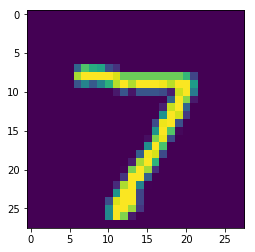

In [2]:
# Load MNIST data from tf examples

image_height = 28
image_width = 28

color_channels = 1

model_name = "mnist"

mnist = tf.contrib.learn.datasets.load_dataset("mnist")

train_data = mnist.train.images
train_data = np.reshape(train_data, (-1, image_height, image_width, color_channels))
 
print(train_data.shape)

## Creating the discriminator network
The discriminator network takes images as an input and is trained to find the probability that the given image is fake, or created by the generator, or real, pulled out of the dataset. It uses convolutional layers, leaky relu activations and batch normalization to increase training speed.

In [138]:
# Discriminator
def create_discriminator(image, reuse=False):

    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        w1 = tf.get_variable("conv1weights", 
                             shape=[5, 5, color_channels, 16], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable("conv1biases", 
                             shape=[16],  
                             initializer=tf.constant_initializer(0))
        conv1 = tf.nn.conv2d(image, w1, [1, 1, 1, 1], "SAME") + b1
        norm_conv1 = tf.nn.leaky_relu(tf.contrib.layers.batch_norm(conv1, epsilon=1e-5))
        pool1 = tf.layers.max_pooling2d(norm_conv1, [2, 2], [2, 2], "SAME")
        
        w2 = tf.get_variable("conv2weights", 
                             shape=[5, 5, 16, 32], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable("conv2biases", 
                             shape=[32], 
                             initializer=tf.constant_initializer(0))
        conv2 = tf.nn.conv2d(pool1, w2, [1, 1, 1, 1], "SAME") + b2
        norm_conv2 = tf.nn.leaky_relu(tf.contrib.layers.batch_norm(conv2, epsilon=1e-5))
        pool2 = tf.layers.max_pooling2d(norm_conv2, [2, 2], [2, 2], "SAME")
        
        w3 = tf.get_variable("conv3weights", 
                             shape=[5, 5, 32, 64], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b3 = tf.get_variable("conv3biases", 
                             shape=[64], 
                             initializer=tf.constant_initializer(0))
        conv3 = tf.nn.conv2d(pool2, w3, [1, 1, 1, 1], "SAME") + b3
        norm_conv3 = tf.nn.leaky_relu(tf.contrib.layers.batch_norm(conv3, epsilon=1e-5))
        pool3 = tf.layers.max_pooling2d(norm_conv3, [2, 2], [2, 2], "SAME")
        flatten = tf.layers.flatten(pool3)
        
        w5 = tf.get_variable("dense1weights", 
                             shape=[1024, 1], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b5 = tf.get_variable("dense1biases", 
                             shape=[1, 1], 
                             initializer=tf.constant_initializer(0))
        output = tf.sigmoid(tf.matmul(flatten, w5) + b5)
        
    return output

## Creating the generator network
The generator network takes in a sample 'z' from the normal distribution as a 100-D vector and applies transpose convolutions with relu and, once again, batch normalization to essentially transform the normal distribution into the distribution of the dataset.

In [139]:
# Generator
def create_generator(z, reuse=False):
    with tf.variable_scope("generator", reuse=reuse) as scope:
        batch_size = tf.shape(z)[0]
        
        w1 = tf.get_variable("dense1weights", 
                             shape=[noise_length, 4096], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable("dense1biases", 
                             shape=[1, 4096], 
                             initializer=tf.constant_initializer(0))
        dense1 = tf.matmul(z, w1) + b1
        norm_dense1 = tf.nn.relu(tf.contrib.layers.batch_norm(dense1))
        
        
        conv_input = tf.reshape(norm_dense1, shape=[-1, 4, 4, 256])
        
        w2 = tf.get_variable("conv1weights", 
                             shape=[5, 5, 64, 256], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable("conv1biases",
                             shape=[64],
                             initializer=tf.constant_initializer(0))
        conv1 = tf.nn.conv2d_transpose(conv_input, w2, [batch_size, 8, 8, 64], [1, 2, 2, 1]) + b2
        norm_conv1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv1))
        
        w3 = tf.get_variable("conv2weights", 
                             shape=[5, 5, 32, 64], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b3 = tf.get_variable("conv2biases",
                             shape=[32],
                             initializer=tf.constant_initializer(0))
        conv2 = tf.nn.conv2d_transpose(norm_conv1, w3, [batch_size, 16, 16, 32], [1, 2, 2, 1]) + b3
        norm_conv2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2))
        
        w4 = tf.get_variable("conv3weights", 
                             shape=[5, 5, 16, 32], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b4 = tf.get_variable("conv3biases",
                             shape=[16],
                             initializer=tf.constant_initializer(0))
        conv3 = tf.nn.conv2d_transpose(norm_conv2, w4, [batch_size, 32, 32, 16], [1, 2, 2, 1]) + b4
        norm_conv3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv3))
        
        w5 = tf.get_variable("conv4weights", 
                             shape=[32, 32, color_channels, 16], 
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b5 = tf.get_variable("conv4biases",
                             shape=[color_channels],
                             initializer=tf.constant_initializer(0))
        conv4 = tf.nn.conv2d_transpose(norm_conv3, w5, [batch_size, 32, 32, color_channels], [1, 1, 1, 1]) + b5
        output = tf.sigmoid(conv4)
        
    return output

# Adversarial loss
The discriminator is given both real images from the MNIST dataset and fake images created by the generator. The discriminator is optimized to distinguish between real and fake, while the generator is trying to maximize the loss of the discriminator. This creates an adversary, making convergence extremely difficult, however allowing the generator to get closer and closer to finding the probability distribution of the data.

In [140]:
# Building the model

tf.reset_default_graph()

img_height = 32
img_width = 32
color_channels = 1
noise_length = 100

# Placeholders
x_images = tf.placeholder(dtype=tf.float32, shape=[None, img_height, img_width, color_channels])
noise = tf.placeholder(dtype=tf.float32, shape=[None, noise_length])

# Minimax
real = create_discriminator(x_images)
fake = create_discriminator(create_generator(noise), reuse=True)

gen_loss = -tf.reduce_mean(tf.log(fake))
disc_loss = -tf.reduce_mean(tf.log(real) + tf.log(1 - fake))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="discriminator")

train_gen = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(gen_loss, var_list=gen_vars)
train_disc = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(disc_loss, var_list=disc_vars)

## Training the model

In [ ]:
# Training
load_checkpoint = True
path = "GAN checkpoints/"
saver = tf.train.Saver(max_to_keep=8)

batch_size = 100
epochs = 50000
display_step = 10

init = tf.global_variables_initializer()
sess = tf.Session()
if load_checkpoint:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())

current_batch_index = 0

test_gen = create_generator(np.random.uniform(-1.0, 1.0, size=[16, noise_length]).astype(np.float32), reuse=True)

for epoch in range(10000, epochs):
    batch_xs = np.array(train_data[current_batch_index:current_batch_index + batch_size])
    batch_xs = np.lib.pad(batch_xs, ((0,0),(2,2),(2,2),(0,0)),'constant')
    
    if current_batch_index + batch_size >= len(train_data):
        current_batch_index = 0
    else:
        current_batch_index += batch_size
        
    zs = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_length]).astype(np.float32)
        
    if epoch % display_step == 0:
        a = np.array(sess.run(test_gen))
        save_sample(a, "Generated/" + str(epoch) + ".bmp", [4, 4])
        saver.save(sess, path + model_name, epoch)
        
    sess.run(train_disc, feed_dict={x_images: batch_xs, noise: zs})
    sess.run(train_gen, feed_dict={noise: zs})
    sess.run(train_gen, feed_dict={noise: zs})
    
    print("Epoch", 
          epoch, 
          "Generator Loss", 
          sess.run(gen_loss, 
                   feed_dict={noise: zs}), 
          "Discriminator Loss", 
          sess.run(disc_loss, 
                   feed_dict={x_images: batch_xs, noise: zs}))
    
saver.save(sess, path + model_name, epoch)

INFO:tensorflow:Restoring parameters from GAN checkpoints/mnist-9999
Epoch 10000 Generator Loss 1.7956178 Discriminator Loss 0.4178351
Epoch 10001 Generator Loss 1.7689254 Discriminator Loss 0.42210513
Epoch 10002 Generator Loss 1.8125349 Discriminator Loss 0.46547136
Epoch 10003 Generator Loss 1.4492424 Discriminator Loss 0.45683888
Epoch 10004 Generator Loss 1.9290326 Discriminator Loss 0.4231186
Epoch 10005 Generator Loss 1.6021831 Discriminator Loss 0.45818946
Epoch 10006 Generator Loss 1.5265547 Discriminator Loss 0.44324765
Epoch 10007 Generator Loss 2.1334298 Discriminator Loss 0.36532226
Epoch 10008 Generator Loss 2.096385 Discriminator Loss 0.28665727
Epoch 10009 Generator Loss 0.79019946 Discriminator Loss 0.7755211
Epoch 10010 Generator Loss 2.8778238 Discriminator Loss 0.5174458
Epoch 10011 Generator Loss 1.927409 Discriminator Loss 0.37602913
Epoch 10012 Generator Loss 1.0721617 Discriminator Loss 0.63212943
Epoch 10013 Generator Loss 2.8205853 Discriminator Loss 0.3935142

Epoch 10123 Generator Loss 2.059556 Discriminator Loss 0.24317469
Epoch 10124 Generator Loss 2.1464224 Discriminator Loss 0.28267053
Epoch 10125 Generator Loss 1.2527357 Discriminator Loss 0.4718444
Epoch 10126 Generator Loss 2.1604307 Discriminator Loss 0.2600347
Epoch 10127 Generator Loss 2.301616 Discriminator Loss 0.28863603
Epoch 10128 Generator Loss 2.1543589 Discriminator Loss 0.23609227
Epoch 10129 Generator Loss 2.04964 Discriminator Loss 0.24280035
Epoch 10130 Generator Loss 2.3905795 Discriminator Loss 0.18332393
Epoch 10131 Generator Loss 2.3097353 Discriminator Loss 0.2364141
Epoch 10132 Generator Loss 1.4624667 Discriminator Loss 0.47334725
Epoch 10133 Generator Loss 2.1574166 Discriminator Loss 0.31568408
Epoch 10134 Generator Loss 2.205976 Discriminator Loss 0.3338175
Epoch 10135 Generator Loss 1.7889738 Discriminator Loss 0.40270603
Epoch 10136 Generator Loss 1.5548991 Discriminator Loss 0.39065787
Epoch 10137 Generator Loss 2.0767243 Discriminator Loss 0.27976426
Epoc

Epoch 10249 Generator Loss 2.509677 Discriminator Loss 0.2871928
Epoch 10250 Generator Loss 2.196867 Discriminator Loss 0.34660557
Epoch 10251 Generator Loss 1.9018128 Discriminator Loss 0.3607505
Epoch 10252 Generator Loss 1.0431981 Discriminator Loss 0.6851752
Epoch 10253 Generator Loss 2.8954258 Discriminator Loss 0.588871
Epoch 10254 Generator Loss 1.3186952 Discriminator Loss 0.62997806
Epoch 10255 Generator Loss 1.7813376 Discriminator Loss 0.42877427
Epoch 10256 Generator Loss 2.5382829 Discriminator Loss 0.22016853
Epoch 10257 Generator Loss 1.7418839 Discriminator Loss 0.5113936
Epoch 10258 Generator Loss 1.0825771 Discriminator Loss 0.7671114
Epoch 10259 Generator Loss 1.2835201 Discriminator Loss 0.56021327
Epoch 10260 Generator Loss 2.201247 Discriminator Loss 0.53740984
Epoch 10261 Generator Loss 2.120465 Discriminator Loss 0.31877992
Epoch 10262 Generator Loss 1.5635086 Discriminator Loss 0.3981123
Epoch 10263 Generator Loss 1.8677003 Discriminator Loss 0.3155265
Epoch 10

Epoch 10373 Generator Loss 1.9481788 Discriminator Loss 0.40426672
Epoch 10374 Generator Loss 1.560544 Discriminator Loss 0.4774016
Epoch 10375 Generator Loss 2.2192447 Discriminator Loss 0.4578368
Epoch 10376 Generator Loss 1.5620481 Discriminator Loss 0.47504163
Epoch 10377 Generator Loss 1.6592238 Discriminator Loss 0.4747349
Epoch 10378 Generator Loss 3.2284546 Discriminator Loss 0.27079734
Epoch 10379 Generator Loss 1.4703088 Discriminator Loss 0.391316
Epoch 10380 Generator Loss 2.231499 Discriminator Loss 0.47673434
Epoch 10381 Generator Loss 1.9345686 Discriminator Loss 0.31633604
Epoch 10382 Generator Loss 1.1224885 Discriminator Loss 0.61983544
Epoch 10383 Generator Loss 2.3252108 Discriminator Loss 0.4784981
Epoch 10384 Generator Loss 1.7905698 Discriminator Loss 0.4205576
Epoch 10385 Generator Loss 1.2110734 Discriminator Loss 0.555607
Epoch 10386 Generator Loss 1.4605441 Discriminator Loss 0.61594164
Epoch 10387 Generator Loss 1.964411 Discriminator Loss 0.43021524
Epoch 1

Epoch 10499 Generator Loss 2.1569238 Discriminator Loss 0.30612665
Epoch 10500 Generator Loss 2.8994327 Discriminator Loss 0.15460142
Epoch 10501 Generator Loss 2.7078614 Discriminator Loss 0.2041553
Epoch 10502 Generator Loss 2.3128376 Discriminator Loss 0.21885172
Epoch 10503 Generator Loss 1.8954115 Discriminator Loss 0.3229579
Epoch 10504 Generator Loss 1.4031087 Discriminator Loss 0.5247985
Epoch 10505 Generator Loss 1.3762496 Discriminator Loss 0.6622623
Epoch 10506 Generator Loss 1.386044 Discriminator Loss 0.7303162
Epoch 10507 Generator Loss 2.5910566 Discriminator Loss 0.49634153
Epoch 10508 Generator Loss 0.846719 Discriminator Loss 0.7764814
Epoch 10509 Generator Loss 3.1265779 Discriminator Loss 0.53707576
Epoch 10510 Generator Loss 1.5132712 Discriminator Loss 0.46677616
Epoch 10511 Generator Loss 0.89091307 Discriminator Loss 0.7972301
Epoch 10512 Generator Loss 3.687923 Discriminator Loss 0.40414098
Epoch 10513 Generator Loss 1.0594987 Discriminator Loss 0.6327217
Epoch

Epoch 10623 Generator Loss 2.107509 Discriminator Loss 0.25709546
Epoch 10624 Generator Loss 2.8918576 Discriminator Loss 0.11607234
Epoch 10625 Generator Loss 3.3702989 Discriminator Loss 0.09672634
Epoch 10626 Generator Loss 2.885376 Discriminator Loss 0.1259112
Epoch 10627 Generator Loss 2.8234613 Discriminator Loss 0.13458826
Epoch 10628 Generator Loss 2.7774324 Discriminator Loss 0.13633472
Epoch 10629 Generator Loss 1.0724514 Discriminator Loss 0.58990085
Epoch 10630 Generator Loss 2.395856 Discriminator Loss 0.2999839
Epoch 10631 Generator Loss 3.039187 Discriminator Loss 0.21404417
Epoch 10632 Generator Loss 3.0792038 Discriminator Loss 0.11876386
Epoch 10633 Generator Loss 2.6440284 Discriminator Loss 0.15217976
Epoch 10634 Generator Loss 2.3462734 Discriminator Loss 0.17447922
Epoch 10635 Generator Loss 2.3088655 Discriminator Loss 0.19906692
Epoch 10636 Generator Loss 2.232001 Discriminator Loss 0.23621063
Epoch 10637 Generator Loss 2.6931458 Discriminator Loss 0.1930992
Epo

Epoch 10749 Generator Loss 1.6348698 Discriminator Loss 0.37768734
Epoch 10750 Generator Loss 2.3350403 Discriminator Loss 0.2134144
Epoch 10751 Generator Loss 2.500321 Discriminator Loss 0.26421237
Epoch 10752 Generator Loss 1.8675183 Discriminator Loss 0.4608055
Epoch 10753 Generator Loss 0.99628884 Discriminator Loss 0.77302605
Epoch 10754 Generator Loss 3.187873 Discriminator Loss 0.59494966
Epoch 10755 Generator Loss 2.3432393 Discriminator Loss 0.3584031
Epoch 10756 Generator Loss 1.7606778 Discriminator Loss 0.4102185
Epoch 10757 Generator Loss 2.313636 Discriminator Loss 0.35550743
Epoch 10758 Generator Loss 1.7140622 Discriminator Loss 0.45938218
Epoch 10759 Generator Loss 1.8071692 Discriminator Loss 0.37312564
Epoch 10760 Generator Loss 2.6551034 Discriminator Loss 0.28679585
Epoch 10761 Generator Loss 1.6576228 Discriminator Loss 0.4023159
Epoch 10762 Generator Loss 1.9962121 Discriminator Loss 0.42902878
Epoch 10763 Generator Loss 2.128493 Discriminator Loss 0.38672554
Epo

Epoch 10873 Generator Loss 2.5197124 Discriminator Loss 0.80498576
Epoch 10874 Generator Loss 0.64818484 Discriminator Loss 1.0440338
Epoch 10875 Generator Loss 2.9719322 Discriminator Loss 0.3885366
Epoch 10876 Generator Loss 2.384451 Discriminator Loss 0.3571829
Epoch 10877 Generator Loss 0.19080085 Discriminator Loss 1.9640131
Epoch 10878 Generator Loss 4.0889163 Discriminator Loss 1.127606
Epoch 10879 Generator Loss 2.5413642 Discriminator Loss 0.6055236
Epoch 10880 Generator Loss 1.2542915 Discriminator Loss 0.58699465
Epoch 10881 Generator Loss 1.6415524 Discriminator Loss 0.57214755
Epoch 10882 Generator Loss 2.2682781 Discriminator Loss 0.31245834
Epoch 10883 Generator Loss 2.418435 Discriminator Loss 0.25651124
Epoch 10884 Generator Loss 2.1737046 Discriminator Loss 0.28618884
Epoch 10885 Generator Loss 1.592441 Discriminator Loss 0.42299956
Epoch 10886 Generator Loss 1.8354673 Discriminator Loss 0.3417954
Epoch 10887 Generator Loss 2.473936 Discriminator Loss 0.22607687
Epoch

Epoch 10999 Generator Loss 1.8883042 Discriminator Loss 0.5031756
Epoch 11000 Generator Loss 2.5692804 Discriminator Loss 0.3602411
Epoch 11001 Generator Loss 2.271404 Discriminator Loss 0.26294467
Epoch 11002 Generator Loss 2.2242436 Discriminator Loss 0.25133651
Epoch 11003 Generator Loss 1.2011162 Discriminator Loss 0.67895067
Epoch 11004 Generator Loss 2.471269 Discriminator Loss 0.4722027
Epoch 11005 Generator Loss 2.4608915 Discriminator Loss 0.35252962
Epoch 11006 Generator Loss 1.5914148 Discriminator Loss 0.48063064
Epoch 11007 Generator Loss 0.9991175 Discriminator Loss 0.6662358
Epoch 11008 Generator Loss 2.6315763 Discriminator Loss 0.38615036
Epoch 11009 Generator Loss 3.6221814 Discriminator Loss 0.18351705
Epoch 11010 Generator Loss 2.830235 Discriminator Loss 0.13900803
Epoch 11011 Generator Loss 1.3885504 Discriminator Loss 0.46791705
Epoch 11012 Generator Loss 2.0251708 Discriminator Loss 0.39306355
Epoch 11013 Generator Loss 2.4934816 Discriminator Loss 0.29017895
Ep

Epoch 11123 Generator Loss 1.3229895 Discriminator Loss 0.5658693
Epoch 11124 Generator Loss 1.9135001 Discriminator Loss 0.3132339
Epoch 11125 Generator Loss 2.200668 Discriminator Loss 0.3841945
Epoch 11126 Generator Loss 0.8896639 Discriminator Loss 0.86695236
Epoch 11127 Generator Loss 0.8097982 Discriminator Loss 1.0919032
Epoch 11128 Generator Loss 1.6068839 Discriminator Loss 0.7999952
Epoch 11129 Generator Loss 1.2632595 Discriminator Loss 0.8896928
Epoch 11130 Generator Loss 0.8737668 Discriminator Loss 0.8632767
Epoch 11131 Generator Loss 1.8794861 Discriminator Loss 0.6897521
Epoch 11132 Generator Loss 1.4970534 Discriminator Loss 0.7015735
Epoch 11133 Generator Loss 1.4572629 Discriminator Loss 0.5485415
Epoch 11134 Generator Loss 1.3549248 Discriminator Loss 0.6749337
Epoch 11135 Generator Loss 2.2982378 Discriminator Loss 0.52968365
Epoch 11136 Generator Loss 2.1153457 Discriminator Loss 0.3442395
Epoch 11137 Generator Loss 0.93644965 Discriminator Loss 0.8036866
Epoch 11

Epoch 11249 Generator Loss 0.9710659 Discriminator Loss 0.68354493
Epoch 11250 Generator Loss 2.757832 Discriminator Loss 0.4372798
Epoch 11251 Generator Loss 2.4831474 Discriminator Loss 0.3320345
Epoch 11252 Generator Loss 1.4699435 Discriminator Loss 0.4412178
Epoch 11253 Generator Loss 2.5568798 Discriminator Loss 0.26175335
Epoch 11254 Generator Loss 2.7647486 Discriminator Loss 0.25845346
Epoch 11255 Generator Loss 1.9079769 Discriminator Loss 0.3264069
Epoch 11256 Generator Loss 2.321998 Discriminator Loss 0.2577046
Epoch 11257 Generator Loss 2.3849485 Discriminator Loss 0.28266314
Epoch 11258 Generator Loss 2.6587262 Discriminator Loss 0.16082548
Epoch 11259 Generator Loss 2.2254848 Discriminator Loss 0.2741471
Epoch 11260 Generator Loss 2.2303033 Discriminator Loss 0.23482952
Epoch 11261 Generator Loss 2.393484 Discriminator Loss 0.18629818
Epoch 11262 Generator Loss 2.3763652 Discriminator Loss 0.19887371
Epoch 11263 Generator Loss 1.6663758 Discriminator Loss 0.392474
Epoch 

Epoch 11373 Generator Loss 1.495549 Discriminator Loss 0.5497775
Epoch 11374 Generator Loss 1.9619669 Discriminator Loss 0.48804748
Epoch 11375 Generator Loss 2.2404253 Discriminator Loss 0.3875136
Epoch 11376 Generator Loss 1.7090988 Discriminator Loss 0.3849497
Epoch 11377 Generator Loss 1.4387674 Discriminator Loss 0.4909909
Epoch 11378 Generator Loss 2.5726318 Discriminator Loss 0.24680328
Epoch 11379 Generator Loss 2.3667965 Discriminator Loss 0.27268413
Epoch 11380 Generator Loss 1.5594579 Discriminator Loss 0.46894473
Epoch 11381 Generator Loss 1.1438644 Discriminator Loss 0.6918559
Epoch 11382 Generator Loss 2.0858402 Discriminator Loss 0.4623388
Epoch 11383 Generator Loss 1.975849 Discriminator Loss 0.393716
Epoch 11384 Generator Loss 1.6053694 Discriminator Loss 0.44108027
Epoch 11385 Generator Loss 2.3408315 Discriminator Loss 0.35964826
Epoch 11386 Generator Loss 2.110403 Discriminator Loss 0.4676345
Epoch 11387 Generator Loss 1.4217976 Discriminator Loss 0.5549707
Epoch 11

Epoch 11499 Generator Loss 2.242838 Discriminator Loss 0.24058376
Epoch 11500 Generator Loss 2.0614924 Discriminator Loss 0.26322356
Epoch 11501 Generator Loss 2.795191 Discriminator Loss 0.12680736
Epoch 11502 Generator Loss 3.2527924 Discriminator Loss 0.10239612
Epoch 11503 Generator Loss 3.0512073 Discriminator Loss 0.119974
Epoch 11504 Generator Loss 2.3564413 Discriminator Loss 0.21066818
Epoch 11505 Generator Loss 2.1281462 Discriminator Loss 0.20342976
Epoch 11506 Generator Loss 2.6262906 Discriminator Loss 0.1543915
Epoch 11507 Generator Loss 2.1271791 Discriminator Loss 0.26427633
Epoch 11508 Generator Loss 1.7515787 Discriminator Loss 0.32615012
Epoch 11509 Generator Loss 2.588056 Discriminator Loss 0.24610855
Epoch 11510 Generator Loss 1.8568578 Discriminator Loss 0.35709655
Epoch 11511 Generator Loss 2.7885847 Discriminator Loss 0.14377503
Epoch 11512 Generator Loss 2.7637877 Discriminator Loss 0.13444526
Epoch 11513 Generator Loss 3.6451783 Discriminator Loss 0.14469005
E

Epoch 11623 Generator Loss 1.6500701 Discriminator Loss 0.3945461
Epoch 11624 Generator Loss 2.0234797 Discriminator Loss 0.33898494
Epoch 11625 Generator Loss 2.173972 Discriminator Loss 0.330812
Epoch 11626 Generator Loss 1.6179713 Discriminator Loss 0.36878693
Epoch 11627 Generator Loss 1.5768569 Discriminator Loss 0.5488641
Epoch 11628 Generator Loss 1.7667938 Discriminator Loss 0.40512413
Epoch 11629 Generator Loss 1.2646827 Discriminator Loss 0.57455385
Epoch 11630 Generator Loss 2.3262339 Discriminator Loss 0.39433843
Epoch 11631 Generator Loss 2.3283465 Discriminator Loss 0.36965966
Epoch 11632 Generator Loss 1.993056 Discriminator Loss 0.39838845
Epoch 11633 Generator Loss 2.7087939 Discriminator Loss 0.23506317
Epoch 11634 Generator Loss 0.9098986 Discriminator Loss 0.8266647
Epoch 11635 Generator Loss 2.099616 Discriminator Loss 0.6135561
Epoch 11636 Generator Loss 3.0628052 Discriminator Loss 0.19439737
Epoch 11637 Generator Loss 3.3829708 Discriminator Loss 0.10871521
Epoc

Epoch 11749 Generator Loss 1.1154513 Discriminator Loss 0.7130612
Epoch 11750 Generator Loss 2.3279476 Discriminator Loss 0.43405795
Epoch 11751 Generator Loss 1.7798233 Discriminator Loss 0.44215438
Epoch 11752 Generator Loss 1.265996 Discriminator Loss 0.6382609
Epoch 11753 Generator Loss 1.9203972 Discriminator Loss 0.39344987
Epoch 11754 Generator Loss 1.8534553 Discriminator Loss 0.40370643
Epoch 11755 Generator Loss 1.7059355 Discriminator Loss 0.3748896
Epoch 11756 Generator Loss 1.6342139 Discriminator Loss 0.46135437
Epoch 11757 Generator Loss 1.8793542 Discriminator Loss 0.31863225
Epoch 11758 Generator Loss 1.8255821 Discriminator Loss 0.4378211
Epoch 11759 Generator Loss 0.74017626 Discriminator Loss 0.8508587
Epoch 11760 Generator Loss 2.294434 Discriminator Loss 0.3433215
Epoch 11761 Generator Loss 2.987769 Discriminator Loss 0.2891842
Epoch 11762 Generator Loss 2.6878042 Discriminator Loss 0.17566025
Epoch 11763 Generator Loss 2.2054114 Discriminator Loss 0.21010973
Epoc

Epoch 11873 Generator Loss 2.4429913 Discriminator Loss 0.20180503
Epoch 11874 Generator Loss 2.1753387 Discriminator Loss 0.23604974
Epoch 11875 Generator Loss 1.3998134 Discriminator Loss 0.44367602
Epoch 11876 Generator Loss 3.413276 Discriminator Loss 0.4982966
Epoch 11877 Generator Loss 2.926798 Discriminator Loss 0.24626069
Epoch 11878 Generator Loss 1.0640855 Discriminator Loss 0.62625265
Epoch 11879 Generator Loss 1.719093 Discriminator Loss 0.48685336
Epoch 11880 Generator Loss 2.601798 Discriminator Loss 0.32564747
Epoch 11881 Generator Loss 1.9459398 Discriminator Loss 0.34202072
Epoch 11882 Generator Loss 1.4387835 Discriminator Loss 0.4210851
Epoch 11883 Generator Loss 2.2422256 Discriminator Loss 0.34935308
Epoch 11884 Generator Loss 2.273095 Discriminator Loss 0.29340237
Epoch 11885 Generator Loss 1.5522704 Discriminator Loss 0.50753623
Epoch 11886 Generator Loss 2.9513352 Discriminator Loss 0.25768077
Epoch 11887 Generator Loss 2.5430243 Discriminator Loss 0.27255556
Ep

Epoch 11999 Generator Loss 3.2814713 Discriminator Loss 0.12257678
Epoch 12000 Generator Loss 2.8915174 Discriminator Loss 0.12835008
Epoch 12001 Generator Loss 2.7604494 Discriminator Loss 0.11666232
Epoch 12002 Generator Loss 2.7416396 Discriminator Loss 0.1450777
Epoch 12003 Generator Loss 2.9697628 Discriminator Loss 0.1382702
Epoch 12004 Generator Loss 2.651124 Discriminator Loss 0.17161337
Epoch 12005 Generator Loss 2.184516 Discriminator Loss 0.26588812
Epoch 12006 Generator Loss 2.7203412 Discriminator Loss 0.17466103
Epoch 12007 Generator Loss 3.0411696 Discriminator Loss 0.12803021
Epoch 12008 Generator Loss 3.6549752 Discriminator Loss 0.06641031
Epoch 12009 Generator Loss 3.1791034 Discriminator Loss 0.112216175
Epoch 12010 Generator Loss 2.183813 Discriminator Loss 0.20914948
Epoch 12011 Generator Loss 2.0354812 Discriminator Loss 0.27235457
Epoch 12012 Generator Loss 2.6020145 Discriminator Loss 0.18125717
Epoch 12013 Generator Loss 2.885777 Discriminator Loss 0.21317893


Epoch 12123 Generator Loss 2.8639026 Discriminator Loss 0.17331554
Epoch 12124 Generator Loss 2.6555133 Discriminator Loss 0.19368276
Epoch 12125 Generator Loss 3.164518 Discriminator Loss 0.10141938
Epoch 12126 Generator Loss 2.8024435 Discriminator Loss 0.17703569
Epoch 12127 Generator Loss 2.1578465 Discriminator Loss 0.23619738
Epoch 12128 Generator Loss 1.7630223 Discriminator Loss 0.35664025
Epoch 12129 Generator Loss 3.3023336 Discriminator Loss 0.25040132
Epoch 12130 Generator Loss 2.1352847 Discriminator Loss 0.23283699
Epoch 12131 Generator Loss 2.3668814 Discriminator Loss 0.18045738
Epoch 12132 Generator Loss 3.1506493 Discriminator Loss 0.115430795
Epoch 12133 Generator Loss 3.5253239 Discriminator Loss 0.1128536
Epoch 12134 Generator Loss 2.3835442 Discriminator Loss 0.25826228
Epoch 12135 Generator Loss 2.6253114 Discriminator Loss 0.22264461
Epoch 12136 Generator Loss 3.516813 Discriminator Loss 0.1760777
Epoch 12137 Generator Loss 3.3234115 Discriminator Loss 0.1581106

Epoch 12249 Generator Loss 1.6261917 Discriminator Loss 0.46209502
Epoch 12250 Generator Loss 1.2051387 Discriminator Loss 0.71924096
Epoch 12251 Generator Loss 2.4077423 Discriminator Loss 0.44611117
Epoch 12252 Generator Loss 0.10728482 Discriminator Loss 2.4942331
Epoch 12253 Generator Loss 5.8034215 Discriminator Loss 0.2578798
Epoch 12254 Generator Loss 6.6006837 Discriminator Loss 0.55622864
Epoch 12255 Generator Loss 3.2123816 Discriminator Loss 0.2724156
Epoch 12256 Generator Loss 2.2800226 Discriminator Loss 0.4712914
Epoch 12257 Generator Loss 3.0549967 Discriminator Loss 0.28884858
Epoch 12258 Generator Loss 3.166334 Discriminator Loss 0.35087514
Epoch 12259 Generator Loss 1.6056591 Discriminator Loss 0.5652489
Epoch 12260 Generator Loss 3.0592263 Discriminator Loss 0.5540324
Epoch 12261 Generator Loss 1.5025985 Discriminator Loss 0.5867065
Epoch 12262 Generator Loss 1.3048568 Discriminator Loss 0.62862414
Epoch 12263 Generator Loss 2.115772 Discriminator Loss 0.45166188
Epo

Epoch 12373 Generator Loss 3.61911 Discriminator Loss 0.9909019
Epoch 12374 Generator Loss 1.0843068 Discriminator Loss 0.701463
Epoch 12375 Generator Loss 1.3720261 Discriminator Loss 0.5307211
Epoch 12376 Generator Loss 2.6813984 Discriminator Loss 0.5011679
Epoch 12377 Generator Loss 1.838134 Discriminator Loss 0.4821766
Epoch 12378 Generator Loss 1.3227228 Discriminator Loss 0.5231938
Epoch 12379 Generator Loss 2.2102973 Discriminator Loss 0.37282017
Epoch 12380 Generator Loss 1.7357576 Discriminator Loss 0.4764947
Epoch 12381 Generator Loss 1.6592892 Discriminator Loss 0.44336534
Epoch 12382 Generator Loss 1.8946041 Discriminator Loss 0.47249728
Epoch 12383 Generator Loss 2.2733345 Discriminator Loss 0.30146417
Epoch 12384 Generator Loss 2.0616846 Discriminator Loss 0.30947646
Epoch 12385 Generator Loss 2.0464602 Discriminator Loss 0.34659436
Epoch 12386 Generator Loss 2.515136 Discriminator Loss 0.25062394
Epoch 12387 Generator Loss 1.1155543 Discriminator Loss 0.60818726
Epoch 1

Epoch 12499 Generator Loss 1.9336052 Discriminator Loss 0.32840195
Epoch 12500 Generator Loss 2.176007 Discriminator Loss 0.28539655
Epoch 12501 Generator Loss 1.9898334 Discriminator Loss 0.3457018
Epoch 12502 Generator Loss 1.43932 Discriminator Loss 0.47107002
Epoch 12503 Generator Loss 2.102997 Discriminator Loss 0.42972508
Epoch 12504 Generator Loss 2.4742286 Discriminator Loss 0.28638914
Epoch 12505 Generator Loss 1.6930795 Discriminator Loss 0.3804024
Epoch 12506 Generator Loss 2.0490932 Discriminator Loss 0.3666478
Epoch 12507 Generator Loss 2.0179162 Discriminator Loss 0.31012702
Epoch 12508 Generator Loss 2.1479635 Discriminator Loss 0.25632378
Epoch 12509 Generator Loss 2.6363962 Discriminator Loss 0.25934008
Epoch 12510 Generator Loss 2.2226062 Discriminator Loss 0.2999609
Epoch 12511 Generator Loss 2.2101915 Discriminator Loss 0.265505
Epoch 12512 Generator Loss 2.3946736 Discriminator Loss 0.22759855
Epoch 12513 Generator Loss 2.1316926 Discriminator Loss 0.26906744
Epoch

Epoch 12623 Generator Loss 2.2295358 Discriminator Loss 0.55962056
Epoch 12624 Generator Loss 1.0267702 Discriminator Loss 0.6797569
Epoch 12625 Generator Loss 1.5646776 Discriminator Loss 0.448558
Epoch 12626 Generator Loss 0.79676414 Discriminator Loss 0.9707252
Epoch 12627 Generator Loss 2.2901466 Discriminator Loss 0.4438134
Epoch 12628 Generator Loss 1.9836066 Discriminator Loss 0.5285078
Epoch 12629 Generator Loss 1.1791574 Discriminator Loss 0.5764183
Epoch 12630 Generator Loss 1.1977935 Discriminator Loss 0.6853624
Epoch 12631 Generator Loss 2.0247731 Discriminator Loss 0.5521542
Epoch 12632 Generator Loss 1.0749131 Discriminator Loss 0.7099768
Epoch 12633 Generator Loss 1.4368126 Discriminator Loss 0.55845207
Epoch 12634 Generator Loss 1.6683795 Discriminator Loss 0.535783
Epoch 12635 Generator Loss 1.9379337 Discriminator Loss 0.49441528
Epoch 12636 Generator Loss 1.4088255 Discriminator Loss 0.58093923
Epoch 12637 Generator Loss 1.0540334 Discriminator Loss 0.81918764
Epoch 

Epoch 12749 Generator Loss 1.5774035 Discriminator Loss 0.48639792
Epoch 12750 Generator Loss 1.1446478 Discriminator Loss 0.80923414
Epoch 12751 Generator Loss 2.6168165 Discriminator Loss 0.4405519
Epoch 12752 Generator Loss 2.7002256 Discriminator Loss 0.33119053
Epoch 12753 Generator Loss 1.6372368 Discriminator Loss 0.46188217
Epoch 12754 Generator Loss 1.7152286 Discriminator Loss 0.4390295
Epoch 12755 Generator Loss 2.525555 Discriminator Loss 0.47201616
Epoch 12756 Generator Loss 1.5712852 Discriminator Loss 0.45008287
Epoch 12757 Generator Loss 1.5347377 Discriminator Loss 0.5009253
Epoch 12758 Generator Loss 1.9712486 Discriminator Loss 0.47950867
Epoch 12759 Generator Loss 1.7684216 Discriminator Loss 0.5258107
Epoch 12760 Generator Loss 1.3966606 Discriminator Loss 0.63059855
Epoch 12761 Generator Loss 1.8331715 Discriminator Loss 0.59154916
Epoch 12762 Generator Loss 1.6542157 Discriminator Loss 0.5366733
Epoch 12763 Generator Loss 1.781509 Discriminator Loss 0.43598542
Ep

Epoch 12873 Generator Loss 1.2956625 Discriminator Loss 0.41322222
Epoch 12874 Generator Loss 2.1946943 Discriminator Loss 0.31528443
Epoch 12875 Generator Loss 1.2034341 Discriminator Loss 0.5511466
Epoch 12876 Generator Loss 1.5317608 Discriminator Loss 0.41486245
Epoch 12877 Generator Loss 1.4127333 Discriminator Loss 0.5450148
Epoch 12878 Generator Loss 1.1561509 Discriminator Loss 0.5825782
Epoch 12879 Generator Loss 1.8488613 Discriminator Loss 0.38704956
Epoch 12880 Generator Loss 2.1438825 Discriminator Loss 0.30292562
Epoch 12881 Generator Loss 1.5443333 Discriminator Loss 0.38545457
Epoch 12882 Generator Loss 1.3129452 Discriminator Loss 0.4810472
Epoch 12883 Generator Loss 1.7712042 Discriminator Loss 0.39229888
Epoch 12884 Generator Loss 1.5494716 Discriminator Loss 0.5215796
Epoch 12885 Generator Loss 1.8229066 Discriminator Loss 0.2990094
Epoch 12886 Generator Loss 1.9029197 Discriminator Loss 0.40434492
Epoch 12887 Generator Loss 1.6399083 Discriminator Loss 0.44144237
E

Epoch 12999 Generator Loss 2.192948 Discriminator Loss 0.34144282
Epoch 13000 Generator Loss 1.674113 Discriminator Loss 0.4152816
Epoch 13001 Generator Loss 1.5240594 Discriminator Loss 0.5145787
Epoch 13002 Generator Loss 1.8575536 Discriminator Loss 0.49111897
Epoch 13003 Generator Loss 2.1203501 Discriminator Loss 0.32277694
Epoch 13004 Generator Loss 1.358951 Discriminator Loss 0.5195879
Epoch 13005 Generator Loss 1.3636279 Discriminator Loss 0.5659575
Epoch 13006 Generator Loss 2.3363662 Discriminator Loss 0.48435357
Epoch 13007 Generator Loss 2.0998676 Discriminator Loss 0.53563523
Epoch 13008 Generator Loss 1.6563139 Discriminator Loss 0.45534405
Epoch 13009 Generator Loss 2.2057683 Discriminator Loss 0.332506
Epoch 13010 Generator Loss 1.8858042 Discriminator Loss 0.42183158
Epoch 13011 Generator Loss 1.9803932 Discriminator Loss 0.35779473
Epoch 13012 Generator Loss 2.0287302 Discriminator Loss 0.3502835
Epoch 13013 Generator Loss 1.1372313 Discriminator Loss 0.5794607
Epoch 

Epoch 13123 Generator Loss 2.5896559 Discriminator Loss 0.23485588
Epoch 13124 Generator Loss 2.4035094 Discriminator Loss 0.27361655
Epoch 13125 Generator Loss 1.841247 Discriminator Loss 0.32093975
Epoch 13126 Generator Loss 2.044394 Discriminator Loss 0.25490412
Epoch 13127 Generator Loss 2.1381104 Discriminator Loss 0.29709926
Epoch 13128 Generator Loss 1.671823 Discriminator Loss 0.4361867
Epoch 13129 Generator Loss 1.8844713 Discriminator Loss 0.40949836
Epoch 13130 Generator Loss 0.5682405 Discriminator Loss 1.0517462
Epoch 13131 Generator Loss 3.782757 Discriminator Loss 0.4278912
Epoch 13132 Generator Loss 2.8875525 Discriminator Loss 0.35569924
Epoch 13133 Generator Loss 1.661488 Discriminator Loss 0.3457352
Epoch 13134 Generator Loss 2.164206 Discriminator Loss 0.21441098
Epoch 13135 Generator Loss 2.4140785 Discriminator Loss 0.27231047
Epoch 13136 Generator Loss 2.2428455 Discriminator Loss 0.3063368
Epoch 13137 Generator Loss 1.4409775 Discriminator Loss 0.46087235
Epoch 

Epoch 13249 Generator Loss 1.861477 Discriminator Loss 0.3382729
Epoch 13250 Generator Loss 2.6944253 Discriminator Loss 0.29199615
Epoch 13251 Generator Loss 2.793506 Discriminator Loss 0.21806848
Epoch 13252 Generator Loss 1.8843995 Discriminator Loss 0.3118248
Epoch 13253 Generator Loss 2.117036 Discriminator Loss 0.29390764
Epoch 13254 Generator Loss 2.1809177 Discriminator Loss 0.2735173
Epoch 13255 Generator Loss 1.7204105 Discriminator Loss 0.38301635
Epoch 13256 Generator Loss 1.7889724 Discriminator Loss 0.3828727
Epoch 13257 Generator Loss 2.1966343 Discriminator Loss 0.27625868
Epoch 13258 Generator Loss 2.0653389 Discriminator Loss 0.27014905
Epoch 13259 Generator Loss 2.4428961 Discriminator Loss 0.19633001
Epoch 13260 Generator Loss 1.7995983 Discriminator Loss 0.3665923
Epoch 13261 Generator Loss 2.0052292 Discriminator Loss 0.34690467
Epoch 13262 Generator Loss 1.693585 Discriminator Loss 0.4764205
Epoch 13263 Generator Loss 1.9140776 Discriminator Loss 0.4834059
Epoch 

Epoch 13373 Generator Loss 1.7823901 Discriminator Loss 0.3897065
Epoch 13374 Generator Loss 1.8797504 Discriminator Loss 0.37003112
Epoch 13375 Generator Loss 2.1771672 Discriminator Loss 0.36823276
Epoch 13376 Generator Loss 2.3958936 Discriminator Loss 0.29593349
Epoch 13377 Generator Loss 1.7485397 Discriminator Loss 0.4457877
Epoch 13378 Generator Loss 1.6582836 Discriminator Loss 0.38643837
Epoch 13379 Generator Loss 1.0360074 Discriminator Loss 0.74188894
Epoch 13380 Generator Loss 1.905365 Discriminator Loss 0.5862722
Epoch 13381 Generator Loss 2.0193694 Discriminator Loss 0.41420123
Epoch 13382 Generator Loss 2.1904504 Discriminator Loss 0.29573044
Epoch 13383 Generator Loss 2.1738422 Discriminator Loss 0.34135327
Epoch 13384 Generator Loss 1.819602 Discriminator Loss 0.37839958
Epoch 13385 Generator Loss 1.7966766 Discriminator Loss 0.45984372
Epoch 13386 Generator Loss 1.3091522 Discriminator Loss 0.7401688
Epoch 13387 Generator Loss 2.111319 Discriminator Loss 0.6054018
Epo

Epoch 13499 Generator Loss 2.4849517 Discriminator Loss 0.2645983
Epoch 13500 Generator Loss 2.9663916 Discriminator Loss 0.21047808
Epoch 13501 Generator Loss 3.2368798 Discriminator Loss 0.19681345
Epoch 13502 Generator Loss 1.550955 Discriminator Loss 0.44621336
Epoch 13503 Generator Loss 0.8164134 Discriminator Loss 0.9397743
Epoch 13504 Generator Loss 4.711493 Discriminator Loss 0.70700693
Epoch 13505 Generator Loss 4.448118 Discriminator Loss 0.2994463
Epoch 13506 Generator Loss 1.4702321 Discriminator Loss 0.57895046
Epoch 13507 Generator Loss 2.6918125 Discriminator Loss 0.16592798
Epoch 13508 Generator Loss 1.7431073 Discriminator Loss 0.4107712
Epoch 13509 Generator Loss 1.8728813 Discriminator Loss 0.32264128
Epoch 13510 Generator Loss 2.885627 Discriminator Loss 0.29982555
Epoch 13511 Generator Loss 3.1599648 Discriminator Loss 0.17922631
Epoch 13512 Generator Loss 1.4198302 Discriminator Loss 0.4479164
Epoch 13513 Generator Loss 2.9895506 Discriminator Loss 0.1573014
Epoch

Epoch 13623 Generator Loss 2.5205753 Discriminator Loss 0.30574936
Epoch 13624 Generator Loss 2.529562 Discriminator Loss 0.24319027
Epoch 13625 Generator Loss 2.152908 Discriminator Loss 0.23783036
Epoch 13626 Generator Loss 2.3909843 Discriminator Loss 0.23825589
Epoch 13627 Generator Loss 2.953924 Discriminator Loss 0.16260517
Epoch 13628 Generator Loss 1.3886676 Discriminator Loss 0.5021229
Epoch 13629 Generator Loss 2.0174673 Discriminator Loss 0.33881095
Epoch 13630 Generator Loss 2.319983 Discriminator Loss 0.3865531
Epoch 13631 Generator Loss 1.77352 Discriminator Loss 0.4134654
Epoch 13632 Generator Loss 1.6480453 Discriminator Loss 0.4426009
Epoch 13633 Generator Loss 1.1525158 Discriminator Loss 0.73579866
Epoch 13634 Generator Loss 2.5092769 Discriminator Loss 0.3997794
Epoch 13635 Generator Loss 2.1583695 Discriminator Loss 0.48904598
Epoch 13636 Generator Loss 1.9722276 Discriminator Loss 0.29255244
Epoch 13637 Generator Loss 1.7914078 Discriminator Loss 0.37875775
Epoch 

Epoch 13749 Generator Loss 1.9623924 Discriminator Loss 0.47478485
Epoch 13750 Generator Loss 1.2106153 Discriminator Loss 0.57252824
Epoch 13751 Generator Loss 2.2905316 Discriminator Loss 0.42880616
Epoch 13752 Generator Loss 2.2215328 Discriminator Loss 0.3761598
Epoch 13753 Generator Loss 0.91649365 Discriminator Loss 0.76604956
Epoch 13754 Generator Loss 2.265842 Discriminator Loss 0.40428886
Epoch 13755 Generator Loss 3.0324488 Discriminator Loss 0.28543758
Epoch 13756 Generator Loss 1.9012402 Discriminator Loss 0.36471233
Epoch 13757 Generator Loss 0.47346142 Discriminator Loss 1.1570629
Epoch 13758 Generator Loss 2.6022367 Discriminator Loss 0.6837493
Epoch 13759 Generator Loss 2.4294822 Discriminator Loss 0.46067154
Epoch 13760 Generator Loss 1.6391156 Discriminator Loss 0.44254956
Epoch 13761 Generator Loss 1.7313242 Discriminator Loss 0.48848855
Epoch 13762 Generator Loss 1.9272373 Discriminator Loss 0.4638378
Epoch 13763 Generator Loss 2.209329 Discriminator Loss 0.33818486

Epoch 13873 Generator Loss 1.4369441 Discriminator Loss 0.43977097
Epoch 13874 Generator Loss 3.7635314 Discriminator Loss 0.14186741
Epoch 13875 Generator Loss 3.209343 Discriminator Loss 0.18977648
Epoch 13876 Generator Loss 0.86633956 Discriminator Loss 0.700988
Epoch 13877 Generator Loss 2.734943 Discriminator Loss 0.35976547
Epoch 13878 Generator Loss 1.5885603 Discriminator Loss 0.41091624
Epoch 13879 Generator Loss 2.5804594 Discriminator Loss 0.2941165
Epoch 13880 Generator Loss 1.8996586 Discriminator Loss 0.33367229
Epoch 13881 Generator Loss 2.357101 Discriminator Loss 0.24573022
Epoch 13882 Generator Loss 1.8979913 Discriminator Loss 0.3488761
Epoch 13883 Generator Loss 1.9209964 Discriminator Loss 0.40053463
Epoch 13884 Generator Loss 1.0060292 Discriminator Loss 0.6636529
Epoch 13885 Generator Loss 3.8427017 Discriminator Loss 0.6740504
Epoch 13886 Generator Loss 1.6985414 Discriminator Loss 0.47725788
Epoch 13887 Generator Loss 1.7456889 Discriminator Loss 0.35745195
Epo

Epoch 13999 Generator Loss 2.1214395 Discriminator Loss 0.3626705
Epoch 14000 Generator Loss 2.5473413 Discriminator Loss 0.20986386
Epoch 14001 Generator Loss 2.7168474 Discriminator Loss 0.23108444
Epoch 14002 Generator Loss 2.2655401 Discriminator Loss 0.32002318
Epoch 14003 Generator Loss 2.1296523 Discriminator Loss 0.36049145
Epoch 14004 Generator Loss 2.1301684 Discriminator Loss 0.34656098
Epoch 14005 Generator Loss 2.0854192 Discriminator Loss 0.32292902
Epoch 14006 Generator Loss 2.1268053 Discriminator Loss 0.3438974
Epoch 14007 Generator Loss 1.8527461 Discriminator Loss 0.4443073
Epoch 14008 Generator Loss 2.2106085 Discriminator Loss 0.27938914
Epoch 14009 Generator Loss 2.3767793 Discriminator Loss 0.32899356
Epoch 14010 Generator Loss 2.6362805 Discriminator Loss 0.21377122
Epoch 14011 Generator Loss 2.25493 Discriminator Loss 0.35364065
Epoch 14012 Generator Loss 2.6483612 Discriminator Loss 0.29711407
Epoch 14013 Generator Loss 2.6557827 Discriminator Loss 0.45037022


Epoch 14123 Generator Loss 1.9716953 Discriminator Loss 0.32254106
Epoch 14124 Generator Loss 1.8008742 Discriminator Loss 0.34027496
Epoch 14125 Generator Loss 3.1074545 Discriminator Loss 0.2422977
Epoch 14126 Generator Loss 3.1319451 Discriminator Loss 0.19741333
Epoch 14127 Generator Loss 2.7276938 Discriminator Loss 0.2043964
Epoch 14128 Generator Loss 2.701579 Discriminator Loss 0.18145284
Epoch 14129 Generator Loss 2.598929 Discriminator Loss 0.15031451
Epoch 14130 Generator Loss 2.3195074 Discriminator Loss 0.24824144
Epoch 14131 Generator Loss 2.5896094 Discriminator Loss 0.18589136
Epoch 14132 Generator Loss 2.7365272 Discriminator Loss 0.17096838
Epoch 14133 Generator Loss 2.8738585 Discriminator Loss 0.18744579
Epoch 14134 Generator Loss 2.462512 Discriminator Loss 0.22753097
Epoch 14135 Generator Loss 2.1014767 Discriminator Loss 0.23940222
Epoch 14136 Generator Loss 2.1857047 Discriminator Loss 0.29664448
Epoch 14137 Generator Loss 1.7541815 Discriminator Loss 0.4089351
E

Epoch 14249 Generator Loss 1.7789466 Discriminator Loss 0.45666495
Epoch 14250 Generator Loss 2.7023785 Discriminator Loss 0.27638572
Epoch 14251 Generator Loss 2.4324543 Discriminator Loss 0.21533346
Epoch 14252 Generator Loss 2.1706245 Discriminator Loss 0.20383213
Epoch 14253 Generator Loss 1.8356278 Discriminator Loss 0.28714928
Epoch 14254 Generator Loss 1.4541508 Discriminator Loss 0.53116035
Epoch 14255 Generator Loss 1.3758135 Discriminator Loss 0.6970236
Epoch 14256 Generator Loss 1.1374427 Discriminator Loss 0.6306782
Epoch 14257 Generator Loss 0.6578252 Discriminator Loss 1.0508599
Epoch 14258 Generator Loss 2.7537992 Discriminator Loss 1.0405538
Epoch 14259 Generator Loss 1.057004 Discriminator Loss 0.6825238
Epoch 14260 Generator Loss 1.1549357 Discriminator Loss 0.6820347
Epoch 14261 Generator Loss 2.0073657 Discriminator Loss 0.5216867
Epoch 14262 Generator Loss 1.4012336 Discriminator Loss 0.56450903
Epoch 14263 Generator Loss 1.1477327 Discriminator Loss 0.5102522
Epoc

Epoch 14373 Generator Loss 2.6324546 Discriminator Loss 0.15354149
Epoch 14374 Generator Loss 2.6199515 Discriminator Loss 0.1722455
Epoch 14375 Generator Loss 2.3706667 Discriminator Loss 0.20811749
Epoch 14376 Generator Loss 2.748282 Discriminator Loss 0.16149957
Epoch 14377 Generator Loss 2.2888372 Discriminator Loss 0.28436807
Epoch 14378 Generator Loss 2.7813058 Discriminator Loss 0.16086413
Epoch 14379 Generator Loss 2.6345866 Discriminator Loss 0.18854645
Epoch 14380 Generator Loss 2.2800467 Discriminator Loss 0.2213265
Epoch 14381 Generator Loss 1.8051149 Discriminator Loss 0.37427646
Epoch 14382 Generator Loss 2.5113022 Discriminator Loss 0.27912617
Epoch 14383 Generator Loss 0.97809255 Discriminator Loss 0.65545744
Epoch 14384 Generator Loss 2.6613255 Discriminator Loss 0.24869107
Epoch 14385 Generator Loss 2.7531338 Discriminator Loss 0.26454693
Epoch 14386 Generator Loss 2.3848612 Discriminator Loss 0.2087488
Epoch 14387 Generator Loss 2.516386 Discriminator Loss 0.16100211

Epoch 14499 Generator Loss 1.3112059 Discriminator Loss 0.48148972
Epoch 14500 Generator Loss 2.6013856 Discriminator Loss 0.2983847
Epoch 14501 Generator Loss 2.2374797 Discriminator Loss 0.3879755
Epoch 14502 Generator Loss 1.6090698 Discriminator Loss 0.37622216
Epoch 14503 Generator Loss 2.1622252 Discriminator Loss 0.27063605
Epoch 14504 Generator Loss 2.259605 Discriminator Loss 0.3138147
Epoch 14505 Generator Loss 2.1305444 Discriminator Loss 0.26286486
Epoch 14506 Generator Loss 1.5981853 Discriminator Loss 0.3937213
Epoch 14507 Generator Loss 1.5243094 Discriminator Loss 0.42797753
Epoch 14508 Generator Loss 1.3674333 Discriminator Loss 0.56395894
Epoch 14509 Generator Loss 0.5539666 Discriminator Loss 1.0654486
Epoch 14510 Generator Loss 2.9367568 Discriminator Loss 0.75370157
Epoch 14511 Generator Loss 1.0679528 Discriminator Loss 0.6288474
Epoch 14512 Generator Loss 1.9578488 Discriminator Loss 0.26361507
Epoch 14513 Generator Loss 2.159806 Discriminator Loss 0.3469358
Epoc

Epoch 14623 Generator Loss 2.452608 Discriminator Loss 0.22500935
Epoch 14624 Generator Loss 2.9494104 Discriminator Loss 0.24522586
Epoch 14625 Generator Loss 2.9767282 Discriminator Loss 0.19676365
Epoch 14626 Generator Loss 1.9628445 Discriminator Loss 0.25999114
Epoch 14627 Generator Loss 2.1320195 Discriminator Loss 0.25278318
Epoch 14628 Generator Loss 2.7753012 Discriminator Loss 0.1581185
Epoch 14629 Generator Loss 2.2628253 Discriminator Loss 0.24623436
Epoch 14630 Generator Loss 2.113755 Discriminator Loss 0.260399
Epoch 14631 Generator Loss 2.2276907 Discriminator Loss 0.23199572
Epoch 14632 Generator Loss 2.12865 Discriminator Loss 0.2628999
Epoch 14633 Generator Loss 1.9258193 Discriminator Loss 0.3049196
Epoch 14634 Generator Loss 2.7557254 Discriminator Loss 0.14798553
Epoch 14635 Generator Loss 2.1864855 Discriminator Loss 0.2962971
Epoch 14636 Generator Loss 1.6585203 Discriminator Loss 0.38024548
Epoch 14637 Generator Loss 2.0657775 Discriminator Loss 0.29684207
Epoch

Epoch 14749 Generator Loss 1.7995567 Discriminator Loss 0.55811334
Epoch 14750 Generator Loss 1.7152176 Discriminator Loss 0.5006085
Epoch 14751 Generator Loss 2.1006243 Discriminator Loss 0.33781627
Epoch 14752 Generator Loss 0.89609635 Discriminator Loss 0.7705561
Epoch 14753 Generator Loss 1.7417755 Discriminator Loss 0.46339998
Epoch 14754 Generator Loss 0.73496366 Discriminator Loss 1.0023646
Epoch 14755 Generator Loss 2.0761752 Discriminator Loss 0.6644661
Epoch 14756 Generator Loss 2.2776062 Discriminator Loss 0.33554894
Epoch 14757 Generator Loss 1.5043433 Discriminator Loss 0.4315767
Epoch 14758 Generator Loss 1.3782077 Discriminator Loss 0.5081374
Epoch 14759 Generator Loss 2.505433 Discriminator Loss 0.44353718
Epoch 14760 Generator Loss 1.8140929 Discriminator Loss 0.39755967
Epoch 14761 Generator Loss 0.7664887 Discriminator Loss 0.8451664
Epoch 14762 Generator Loss 3.9437761 Discriminator Loss 0.65247214
Epoch 14763 Generator Loss 2.2534196 Discriminator Loss 0.33770004
E

Epoch 14873 Generator Loss 0.691852 Discriminator Loss 0.8650219
Epoch 14874 Generator Loss 2.6494787 Discriminator Loss 0.4283626
Epoch 14875 Generator Loss 2.3956423 Discriminator Loss 0.37131408
Epoch 14876 Generator Loss 1.1831999 Discriminator Loss 0.5471647
Epoch 14877 Generator Loss 1.0554847 Discriminator Loss 0.5898035
Epoch 14878 Generator Loss 1.948977 Discriminator Loss 0.5120918
Epoch 14879 Generator Loss 0.66654235 Discriminator Loss 0.87283546
Epoch 14880 Generator Loss 2.1442022 Discriminator Loss 0.3299115
Epoch 14881 Generator Loss 2.308034 Discriminator Loss 0.36663038
Epoch 14882 Generator Loss 1.5678891 Discriminator Loss 0.40502343
Epoch 14883 Generator Loss 2.2768219 Discriminator Loss 0.25384322
Epoch 14884 Generator Loss 2.6527984 Discriminator Loss 0.25785834
Epoch 14885 Generator Loss 1.9990091 Discriminator Loss 0.33443984
Epoch 14886 Generator Loss 2.107977 Discriminator Loss 0.30239856
Epoch 14887 Generator Loss 1.9872231 Discriminator Loss 0.326652
Epoch 

Epoch 14999 Generator Loss 1.8068591 Discriminator Loss 0.38033867
Epoch 15000 Generator Loss 1.1212059 Discriminator Loss 0.7768209
Epoch 15001 Generator Loss 1.4537845 Discriminator Loss 0.6337045
Epoch 15002 Generator Loss 0.6283552 Discriminator Loss 1.027391
Epoch 15003 Generator Loss 4.146964 Discriminator Loss 0.48791167
Epoch 15004 Generator Loss 2.7745326 Discriminator Loss 0.33968502
Epoch 15005 Generator Loss 1.2357662 Discriminator Loss 0.5056546
Epoch 15006 Generator Loss 2.0373712 Discriminator Loss 0.37044442
Epoch 15007 Generator Loss 1.6915154 Discriminator Loss 0.51138127
Epoch 15008 Generator Loss 1.2519914 Discriminator Loss 0.595318
Epoch 15009 Generator Loss 1.9034046 Discriminator Loss 0.693328
Epoch 15010 Generator Loss 0.87629485 Discriminator Loss 0.80399114
Epoch 15011 Generator Loss 2.3753264 Discriminator Loss 0.8893858
Epoch 15012 Generator Loss 1.5820996 Discriminator Loss 0.45337147
Epoch 15013 Generator Loss 1.0202286 Discriminator Loss 0.7203536
Epoch 

Epoch 15123 Generator Loss 3.1160789 Discriminator Loss 0.35088196
Epoch 15124 Generator Loss 1.6743518 Discriminator Loss 0.40501946
Epoch 15125 Generator Loss 1.9621502 Discriminator Loss 0.30786496
Epoch 15126 Generator Loss 2.287126 Discriminator Loss 0.3665152
Epoch 15127 Generator Loss 1.2835839 Discriminator Loss 0.75946623
Epoch 15128 Generator Loss 2.6046705 Discriminator Loss 0.23199852
Epoch 15129 Generator Loss 2.5327237 Discriminator Loss 0.2558027
Epoch 15130 Generator Loss 1.4683502 Discriminator Loss 0.4293322
Epoch 15131 Generator Loss 1.911595 Discriminator Loss 0.46296203
Epoch 15132 Generator Loss 2.1291203 Discriminator Loss 0.34250468
Epoch 15133 Generator Loss 2.1070724 Discriminator Loss 0.2803063
Epoch 15134 Generator Loss 1.1803495 Discriminator Loss 0.60523134
Epoch 15135 Generator Loss 3.14865 Discriminator Loss 0.19117627
Epoch 15136 Generator Loss 3.8239727 Discriminator Loss 0.16750056
Epoch 15137 Generator Loss 2.3071177 Discriminator Loss 0.22295696
Epo

Epoch 15249 Generator Loss 2.431791 Discriminator Loss 0.1855783
Epoch 15250 Generator Loss 2.2832403 Discriminator Loss 0.2184312
Epoch 15251 Generator Loss 2.9679728 Discriminator Loss 0.15207605
Epoch 15252 Generator Loss 2.63587 Discriminator Loss 0.14308874
Epoch 15253 Generator Loss 1.855679 Discriminator Loss 0.32854694
Epoch 15254 Generator Loss 2.0279822 Discriminator Loss 0.22517216
Epoch 15255 Generator Loss 2.4169803 Discriminator Loss 0.22710049
Epoch 15256 Generator Loss 2.613064 Discriminator Loss 0.19955027
Epoch 15257 Generator Loss 1.5084786 Discriminator Loss 0.41106403
Epoch 15258 Generator Loss 1.950618 Discriminator Loss 0.2432322
Epoch 15259 Generator Loss 2.8972168 Discriminator Loss 0.252534
Epoch 15260 Generator Loss 2.1634727 Discriminator Loss 0.2699794
Epoch 15261 Generator Loss 1.3683337 Discriminator Loss 0.47550777
Epoch 15262 Generator Loss 1.2983137 Discriminator Loss 0.5272746
Epoch 15263 Generator Loss 2.8282678 Discriminator Loss 0.42262837
Epoch 15

Epoch 15373 Generator Loss 2.0713844 Discriminator Loss 0.3063525
Epoch 15374 Generator Loss 2.370755 Discriminator Loss 0.34964386
Epoch 15375 Generator Loss 1.6470355 Discriminator Loss 0.43556988
Epoch 15376 Generator Loss 1.7971693 Discriminator Loss 0.36414832
Epoch 15377 Generator Loss 2.816461 Discriminator Loss 0.1955888
Epoch 15378 Generator Loss 2.9682827 Discriminator Loss 0.19743642
Epoch 15379 Generator Loss 1.3278799 Discriminator Loss 0.48685145
Epoch 15380 Generator Loss 1.8899889 Discriminator Loss 0.41424572
Epoch 15381 Generator Loss 2.8412647 Discriminator Loss 0.22653128
Epoch 15382 Generator Loss 2.7819564 Discriminator Loss 0.19617552
Epoch 15383 Generator Loss 1.6467937 Discriminator Loss 0.38989994
Epoch 15384 Generator Loss 2.087921 Discriminator Loss 0.290894
Epoch 15385 Generator Loss 2.5835946 Discriminator Loss 0.26707876
Epoch 15386 Generator Loss 2.6415024 Discriminator Loss 0.20466669
Epoch 15387 Generator Loss 2.1127799 Discriminator Loss 0.25229806
Ep

Epoch 15499 Generator Loss 2.8662646 Discriminator Loss 0.19970736
Epoch 15500 Generator Loss 3.5990133 Discriminator Loss 0.16816658
Epoch 15501 Generator Loss 2.6410558 Discriminator Loss 0.17860189
Epoch 15502 Generator Loss 2.0532746 Discriminator Loss 0.25970244
Epoch 15503 Generator Loss 2.223221 Discriminator Loss 0.26218978
Epoch 15504 Generator Loss 2.2887394 Discriminator Loss 0.2891135
Epoch 15505 Generator Loss 3.3029504 Discriminator Loss 0.12266901
Epoch 15506 Generator Loss 2.5338228 Discriminator Loss 0.22466189
Epoch 15507 Generator Loss 1.1520973 Discriminator Loss 0.67573977
Epoch 15508 Generator Loss 2.333492 Discriminator Loss 0.23595724
Epoch 15509 Generator Loss 1.7931546 Discriminator Loss 0.46058258
Epoch 15510 Generator Loss 1.2943285 Discriminator Loss 0.5439583
Epoch 15511 Generator Loss 1.947259 Discriminator Loss 0.42699918
Epoch 15512 Generator Loss 1.9889835 Discriminator Loss 0.42266393
Epoch 15513 Generator Loss 2.2423437 Discriminator Loss 0.4853588
E

Epoch 15623 Generator Loss 2.5669773 Discriminator Loss 0.22730438
Epoch 15624 Generator Loss 2.110453 Discriminator Loss 0.40847802
Epoch 15625 Generator Loss 1.0065991 Discriminator Loss 0.6967577
Epoch 15626 Generator Loss 3.3161454 Discriminator Loss 0.32283774
Epoch 15627 Generator Loss 1.8529309 Discriminator Loss 0.4020861
Epoch 15628 Generator Loss 1.4109844 Discriminator Loss 0.37028027
Epoch 15629 Generator Loss 2.4994981 Discriminator Loss 0.22312145
Epoch 15630 Generator Loss 2.9543052 Discriminator Loss 0.223754
Epoch 15631 Generator Loss 1.609927 Discriminator Loss 0.3908704
Epoch 15632 Generator Loss 1.715168 Discriminator Loss 0.37925452
Epoch 15633 Generator Loss 1.9966 Discriminator Loss 0.46284455
Epoch 15634 Generator Loss 2.8119957 Discriminator Loss 0.41696388
Epoch 15635 Generator Loss 2.748925 Discriminator Loss 0.22575104
Epoch 15636 Generator Loss 1.8457707 Discriminator Loss 0.3499692
Epoch 15637 Generator Loss 1.7381859 Discriminator Loss 0.3817362
Epoch 156

Epoch 15749 Generator Loss 1.1685412 Discriminator Loss 0.56714135
Epoch 15750 Generator Loss 2.5863822 Discriminator Loss 0.22046585
Epoch 15751 Generator Loss 2.4612627 Discriminator Loss 0.31945744
Epoch 15752 Generator Loss 0.2039071 Discriminator Loss 1.9397557
Epoch 15753 Generator Loss 5.3630123 Discriminator Loss 1.6319162
Epoch 15754 Generator Loss 3.073922 Discriminator Loss 0.34953377
Epoch 15755 Generator Loss 1.3257719 Discriminator Loss 0.4711374
Epoch 15756 Generator Loss 2.5702076 Discriminator Loss 0.19206858
Epoch 15757 Generator Loss 3.5140257 Discriminator Loss 0.15506639
Epoch 15758 Generator Loss 1.2920423 Discriminator Loss 0.5875259
Epoch 15759 Generator Loss 2.0693712 Discriminator Loss 0.3945537
Epoch 15760 Generator Loss 1.29813 Discriminator Loss 0.770855
Epoch 15761 Generator Loss 1.4640226 Discriminator Loss 0.6638538
Epoch 15762 Generator Loss 3.8098276 Discriminator Loss 0.2543582
Epoch 15763 Generator Loss 3.1152408 Discriminator Loss 0.22198547
Epoch 1

Epoch 15873 Generator Loss 0.83507484 Discriminator Loss 0.9425533
Epoch 15874 Generator Loss 1.469732 Discriminator Loss 0.74890935
Epoch 15875 Generator Loss 1.3789742 Discriminator Loss 0.81600165
Epoch 15876 Generator Loss 1.4355518 Discriminator Loss 0.47580022
Epoch 15877 Generator Loss 2.6404858 Discriminator Loss 0.44542298
Epoch 15878 Generator Loss 1.7264081 Discriminator Loss 0.5109728
Epoch 15879 Generator Loss 0.9615248 Discriminator Loss 0.76041913
Epoch 15880 Generator Loss 2.0776725 Discriminator Loss 0.49324596
Epoch 15881 Generator Loss 2.0365973 Discriminator Loss 0.36012092
Epoch 15882 Generator Loss 1.9262438 Discriminator Loss 0.3930758
Epoch 15883 Generator Loss 2.0275052 Discriminator Loss 0.24754591
Epoch 15884 Generator Loss 1.7930877 Discriminator Loss 0.39118928
Epoch 15885 Generator Loss 1.9987702 Discriminator Loss 0.31863078
Epoch 15886 Generator Loss 1.3919145 Discriminator Loss 0.53408164
Epoch 15887 Generator Loss 0.99233186 Discriminator Loss 0.750413

Epoch 15999 Generator Loss 1.6656837 Discriminator Loss 0.3409183
Epoch 16000 Generator Loss 2.3176682 Discriminator Loss 0.33710307
Epoch 16001 Generator Loss 1.5628836 Discriminator Loss 0.45093906
Epoch 16002 Generator Loss 1.5167699 Discriminator Loss 0.38936198
Epoch 16003 Generator Loss 1.7444696 Discriminator Loss 0.48892224
Epoch 16004 Generator Loss 1.7920169 Discriminator Loss 0.35899872
Epoch 16005 Generator Loss 1.1261159 Discriminator Loss 0.66397506
Epoch 16006 Generator Loss 1.4994872 Discriminator Loss 0.51227385
Epoch 16007 Generator Loss 1.5658202 Discriminator Loss 0.43369725
Epoch 16008 Generator Loss 1.5527741 Discriminator Loss 0.47954026
Epoch 16009 Generator Loss 2.7889738 Discriminator Loss 0.36074826
Epoch 16010 Generator Loss 1.5082655 Discriminator Loss 0.40992412
Epoch 16011 Generator Loss 2.0545456 Discriminator Loss 0.35411376
Epoch 16012 Generator Loss 1.3060126 Discriminator Loss 0.53846115
Epoch 16013 Generator Loss 0.9982687 Discriminator Loss 0.65882

Epoch 16123 Generator Loss 0.97864145 Discriminator Loss 0.7656852
Epoch 16124 Generator Loss 0.7873848 Discriminator Loss 0.9440068
Epoch 16125 Generator Loss 3.419136 Discriminator Loss 0.83547956
Epoch 16126 Generator Loss 1.6686882 Discriminator Loss 0.44629183
Epoch 16127 Generator Loss 0.3741847 Discriminator Loss 1.4253764
Epoch 16128 Generator Loss 3.3521574 Discriminator Loss 0.6297994
Epoch 16129 Generator Loss 1.127709 Discriminator Loss 0.74644476
Epoch 16130 Generator Loss 0.72165036 Discriminator Loss 1.025912
Epoch 16131 Generator Loss 2.370111 Discriminator Loss 0.7905003
Epoch 16132 Generator Loss 1.7870994 Discriminator Loss 0.56593925
Epoch 16133 Generator Loss 1.0630217 Discriminator Loss 0.66894233
Epoch 16134 Generator Loss 1.8151474 Discriminator Loss 0.7670511
Epoch 16135 Generator Loss 1.1474597 Discriminator Loss 0.84860015
Epoch 16136 Generator Loss 0.47749004 Discriminator Loss 1.4901646
Epoch 16137 Generator Loss 1.2356595 Discriminator Loss 1.2019742
Epoch

Epoch 16249 Generator Loss 1.2164136 Discriminator Loss 0.6941559
Epoch 16250 Generator Loss 1.3189751 Discriminator Loss 0.8018276
Epoch 16251 Generator Loss 1.6424676 Discriminator Loss 0.45807493
Epoch 16252 Generator Loss 2.0591853 Discriminator Loss 0.45967075
Epoch 16253 Generator Loss 0.64483964 Discriminator Loss 1.0150167
Epoch 16254 Generator Loss 0.9052936 Discriminator Loss 0.82513994
Epoch 16255 Generator Loss 3.285987 Discriminator Loss 0.60814494
Epoch 16256 Generator Loss 2.796521 Discriminator Loss 0.5109916
Epoch 16257 Generator Loss 1.184223 Discriminator Loss 0.56778663
Epoch 16258 Generator Loss 0.9159278 Discriminator Loss 0.82486045
Epoch 16259 Generator Loss 2.3096273 Discriminator Loss 0.36846924
Epoch 16260 Generator Loss 3.140307 Discriminator Loss 0.34268162
Epoch 16261 Generator Loss 0.98996294 Discriminator Loss 0.6786508
Epoch 16262 Generator Loss 1.8197122 Discriminator Loss 0.32882464
Epoch 16263 Generator Loss 2.4822702 Discriminator Loss 0.2621702
Epo

Epoch 16373 Generator Loss 2.2083535 Discriminator Loss 0.5135627
Epoch 16374 Generator Loss 1.8369485 Discriminator Loss 0.3947717
Epoch 16375 Generator Loss 1.0155406 Discriminator Loss 0.7684189
Epoch 16376 Generator Loss 1.2238014 Discriminator Loss 0.7341355
Epoch 16377 Generator Loss 1.3079764 Discriminator Loss 0.7932391
Epoch 16378 Generator Loss 1.4655582 Discriminator Loss 0.59695476
Epoch 16379 Generator Loss 1.4035697 Discriminator Loss 0.6467157
Epoch 16380 Generator Loss 1.5152332 Discriminator Loss 0.5047122
Epoch 16381 Generator Loss 0.7996404 Discriminator Loss 0.8890714
Epoch 16382 Generator Loss 1.1662965 Discriminator Loss 0.8187352
Epoch 16383 Generator Loss 1.1562431 Discriminator Loss 0.7158149
Epoch 16384 Generator Loss 1.5054622 Discriminator Loss 0.5417464
Epoch 16385 Generator Loss 0.7029861 Discriminator Loss 0.99303484
Epoch 16386 Generator Loss 2.311227 Discriminator Loss 0.43026534
Epoch 16387 Generator Loss 1.0556601 Discriminator Loss 0.72618395
Epoch 1

Epoch 16499 Generator Loss 1.6011629 Discriminator Loss 0.37036458
Epoch 16500 Generator Loss 2.0891323 Discriminator Loss 0.27229452
Epoch 16501 Generator Loss 2.1425414 Discriminator Loss 0.29686868
Epoch 16502 Generator Loss 2.5101268 Discriminator Loss 0.26057
Epoch 16503 Generator Loss 1.439149 Discriminator Loss 0.48538962
Epoch 16504 Generator Loss 1.7509516 Discriminator Loss 0.42784503
Epoch 16505 Generator Loss 2.2825575 Discriminator Loss 0.2510046
Epoch 16506 Generator Loss 3.1988184 Discriminator Loss 0.13488652
Epoch 16507 Generator Loss 1.1715344 Discriminator Loss 0.52239776
Epoch 16508 Generator Loss 1.5991921 Discriminator Loss 0.4371297
Epoch 16509 Generator Loss 2.562342 Discriminator Loss 0.22334413
Epoch 16510 Generator Loss 3.052282 Discriminator Loss 0.20453547
Epoch 16511 Generator Loss 1.7489829 Discriminator Loss 0.3563795
Epoch 16512 Generator Loss 1.2304398 Discriminator Loss 0.51063335
Epoch 16513 Generator Loss 2.6073453 Discriminator Loss 0.26095527
Epoc

Epoch 16623 Generator Loss 1.462835 Discriminator Loss 0.53292745
Epoch 16624 Generator Loss 1.6921754 Discriminator Loss 0.43441632
Epoch 16625 Generator Loss 2.504582 Discriminator Loss 0.4673895
Epoch 16626 Generator Loss 1.4140956 Discriminator Loss 0.6290765
Epoch 16627 Generator Loss 1.5702939 Discriminator Loss 0.33206618
Epoch 16628 Generator Loss 2.2833757 Discriminator Loss 0.40748703
Epoch 16629 Generator Loss 1.6436878 Discriminator Loss 0.45444545
Epoch 16630 Generator Loss 1.6968967 Discriminator Loss 0.390395
Epoch 16631 Generator Loss 2.492854 Discriminator Loss 0.29593766
Epoch 16632 Generator Loss 2.474411 Discriminator Loss 0.29957092
Epoch 16633 Generator Loss 2.3092203 Discriminator Loss 0.22640957
Epoch 16634 Generator Loss 1.4270425 Discriminator Loss 0.4591894
Epoch 16635 Generator Loss 1.6941664 Discriminator Loss 0.36750016
Epoch 16636 Generator Loss 2.7823718 Discriminator Loss 0.27088857
Epoch 16637 Generator Loss 2.2100616 Discriminator Loss 0.373309
Epoch 

Epoch 16749 Generator Loss 1.552041 Discriminator Loss 0.38416442
Epoch 16750 Generator Loss 1.7048988 Discriminator Loss 0.39103496
Epoch 16751 Generator Loss 2.4451308 Discriminator Loss 0.282336
Epoch 16752 Generator Loss 2.199606 Discriminator Loss 0.27229
Epoch 16753 Generator Loss 1.4562831 Discriminator Loss 0.3871824
Epoch 16754 Generator Loss 2.4749029 Discriminator Loss 0.20958418
Epoch 16755 Generator Loss 2.395814 Discriminator Loss 0.35348716
Epoch 16756 Generator Loss 1.0443457 Discriminator Loss 0.6688083
Epoch 16757 Generator Loss 1.8152568 Discriminator Loss 0.40248534
Epoch 16758 Generator Loss 1.8114264 Discriminator Loss 0.3962006
Epoch 16759 Generator Loss 2.1039693 Discriminator Loss 0.29358706
Epoch 16760 Generator Loss 1.7108554 Discriminator Loss 0.3482983
Epoch 16761 Generator Loss 2.1344357 Discriminator Loss 0.34209833
Epoch 16762 Generator Loss 2.2620325 Discriminator Loss 0.3423529
Epoch 16763 Generator Loss 0.4491515 Discriminator Loss 1.4748384
Epoch 167

Epoch 16873 Generator Loss 1.4733624 Discriminator Loss 0.5462707
Epoch 16874 Generator Loss 1.9023454 Discriminator Loss 0.46413943
Epoch 16875 Generator Loss 2.3295913 Discriminator Loss 0.29149163
Epoch 16876 Generator Loss 2.4960701 Discriminator Loss 0.2235208
Epoch 16877 Generator Loss 1.5957475 Discriminator Loss 0.48842904
Epoch 16878 Generator Loss 1.9196948 Discriminator Loss 0.3294493
Epoch 16879 Generator Loss 2.5076334 Discriminator Loss 0.20180663
Epoch 16880 Generator Loss 1.8700703 Discriminator Loss 0.32828605
Epoch 16881 Generator Loss 1.4750258 Discriminator Loss 0.4343316
Epoch 16882 Generator Loss 1.4366792 Discriminator Loss 0.487831
Epoch 16883 Generator Loss 1.9725872 Discriminator Loss 0.59000826
Epoch 16884 Generator Loss 2.217244 Discriminator Loss 0.37944442
Epoch 16885 Generator Loss 1.5852481 Discriminator Loss 0.4354477
Epoch 16886 Generator Loss 1.3410686 Discriminator Loss 0.48549384
Epoch 16887 Generator Loss 0.8835315 Discriminator Loss 0.79716146
Epo

Epoch 16999 Generator Loss 1.438856 Discriminator Loss 0.44417915
Epoch 17000 Generator Loss 2.4870527 Discriminator Loss 0.22546421
Epoch 17001 Generator Loss 2.999348 Discriminator Loss 0.22634375
Epoch 17002 Generator Loss 3.1715918 Discriminator Loss 0.16617988
Epoch 17003 Generator Loss 2.5467477 Discriminator Loss 0.177741
Epoch 17004 Generator Loss 2.5113344 Discriminator Loss 0.21726787
Epoch 17005 Generator Loss 2.632105 Discriminator Loss 0.204115
Epoch 17006 Generator Loss 2.0557098 Discriminator Loss 0.34047157
Epoch 17007 Generator Loss 2.1771827 Discriminator Loss 0.37316298
Epoch 17008 Generator Loss 1.7136847 Discriminator Loss 0.47920108
Epoch 17009 Generator Loss 2.5263991 Discriminator Loss 0.36503044
Epoch 17010 Generator Loss 1.9081687 Discriminator Loss 0.45898733
Epoch 17011 Generator Loss 1.831093 Discriminator Loss 0.47930297
Epoch 17012 Generator Loss 2.3906946 Discriminator Loss 0.26379088
Epoch 17013 Generator Loss 2.6537592 Discriminator Loss 0.22549677
Epo

Epoch 17123 Generator Loss 2.6785374 Discriminator Loss 0.42216805
Epoch 17124 Generator Loss 1.5488263 Discriminator Loss 0.4832528
Epoch 17125 Generator Loss 1.411626 Discriminator Loss 0.4820555
Epoch 17126 Generator Loss 3.026531 Discriminator Loss 0.55313486
Epoch 17127 Generator Loss 1.2443929 Discriminator Loss 0.6366298
Epoch 17128 Generator Loss 2.228997 Discriminator Loss 0.27612153
Epoch 17129 Generator Loss 2.755588 Discriminator Loss 0.2713033
Epoch 17130 Generator Loss 1.686943 Discriminator Loss 0.35393634
Epoch 17131 Generator Loss 2.519053 Discriminator Loss 0.24508457
Epoch 17132 Generator Loss 3.473209 Discriminator Loss 0.124608144
Epoch 17133 Generator Loss 1.9557418 Discriminator Loss 0.29795516
Epoch 17134 Generator Loss 0.90714926 Discriminator Loss 0.7773401
Epoch 17135 Generator Loss 3.3823426 Discriminator Loss 0.3603278
Epoch 17136 Generator Loss 2.4229667 Discriminator Loss 0.32516328
Epoch 17137 Generator Loss 2.889401 Discriminator Loss 0.09766231
Epoch 1

Epoch 17249 Generator Loss 2.6407068 Discriminator Loss 0.22048461
Epoch 17250 Generator Loss 2.602135 Discriminator Loss 0.23052132
Epoch 17251 Generator Loss 2.4876864 Discriminator Loss 0.25752172
Epoch 17252 Generator Loss 1.9107351 Discriminator Loss 0.3004847
Epoch 17253 Generator Loss 1.8362677 Discriminator Loss 0.33093587
Epoch 17254 Generator Loss 2.3824062 Discriminator Loss 0.25885785
Epoch 17255 Generator Loss 2.1064334 Discriminator Loss 0.37734193
Epoch 17256 Generator Loss 2.3723028 Discriminator Loss 0.2941912
Epoch 17257 Generator Loss 2.404142 Discriminator Loss 0.25821322
Epoch 17258 Generator Loss 2.2574134 Discriminator Loss 0.30236608
Epoch 17259 Generator Loss 0.87404037 Discriminator Loss 0.91614145
Epoch 17260 Generator Loss 2.2295501 Discriminator Loss 0.39008677
Epoch 17261 Generator Loss 3.354076 Discriminator Loss 0.19791938
Epoch 17262 Generator Loss 2.5763059 Discriminator Loss 0.3141896
Epoch 17263 Generator Loss 2.9620895 Discriminator Loss 0.17125246


Epoch 17373 Generator Loss 2.9813392 Discriminator Loss 0.42678905
Epoch 17374 Generator Loss 1.9962394 Discriminator Loss 0.32491285
Epoch 17375 Generator Loss 0.90519625 Discriminator Loss 0.74878114
Epoch 17376 Generator Loss 2.0613372 Discriminator Loss 0.40938142
Epoch 17377 Generator Loss 1.5760041 Discriminator Loss 0.6253401
Epoch 17378 Generator Loss 1.0968488 Discriminator Loss 0.6912261
Epoch 17379 Generator Loss 1.4119027 Discriminator Loss 0.71605873
Epoch 17380 Generator Loss 1.6544428 Discriminator Loss 0.55796075
Epoch 17381 Generator Loss 1.152729 Discriminator Loss 0.67459655
Epoch 17382 Generator Loss 2.0388567 Discriminator Loss 0.49423638
Epoch 17383 Generator Loss 1.2192831 Discriminator Loss 0.5765937
Epoch 17384 Generator Loss 2.5875273 Discriminator Loss 0.46637765
Epoch 17385 Generator Loss 1.0253878 Discriminator Loss 0.72301364
Epoch 17386 Generator Loss 2.1021657 Discriminator Loss 0.49938697
Epoch 17387 Generator Loss 1.462107 Discriminator Loss 0.4981367


Epoch 17499 Generator Loss 1.8191506 Discriminator Loss 0.33403584
Epoch 17500 Generator Loss 2.1398787 Discriminator Loss 0.2717694
Epoch 17501 Generator Loss 2.2667112 Discriminator Loss 0.2956142
Epoch 17502 Generator Loss 2.7631214 Discriminator Loss 0.16148558
Epoch 17503 Generator Loss 2.2732747 Discriminator Loss 0.21287474
Epoch 17504 Generator Loss 1.6352692 Discriminator Loss 0.44494838
Epoch 17505 Generator Loss 1.7755264 Discriminator Loss 0.39117473
Epoch 17506 Generator Loss 2.8064444 Discriminator Loss 0.2334024
Epoch 17507 Generator Loss 3.262779 Discriminator Loss 0.22828297
Epoch 17508 Generator Loss 2.0306578 Discriminator Loss 0.29502293
Epoch 17509 Generator Loss 1.3438779 Discriminator Loss 0.49364826
Epoch 17510 Generator Loss 2.8771408 Discriminator Loss 0.2845051
Epoch 17511 Generator Loss 3.381141 Discriminator Loss 0.21626268
Epoch 17512 Generator Loss 3.4793842 Discriminator Loss 0.12539004
Epoch 17513 Generator Loss 1.6075855 Discriminator Loss 0.32798657
E

Epoch 17623 Generator Loss 2.27358 Discriminator Loss 0.24150188
Epoch 17624 Generator Loss 1.0322093 Discriminator Loss 0.62974703
Epoch 17625 Generator Loss 2.7527828 Discriminator Loss 0.19485615
Epoch 17626 Generator Loss 2.3988678 Discriminator Loss 0.3001767
Epoch 17627 Generator Loss 1.8143487 Discriminator Loss 0.27439222
Epoch 17628 Generator Loss 1.3763603 Discriminator Loss 0.4881227
Epoch 17629 Generator Loss 1.7854333 Discriminator Loss 0.40449622
Epoch 17630 Generator Loss 2.0945947 Discriminator Loss 0.42269775
Epoch 17631 Generator Loss 1.4205099 Discriminator Loss 0.42912066
Epoch 17632 Generator Loss 1.9111263 Discriminator Loss 0.3072276
Epoch 17633 Generator Loss 2.1692886 Discriminator Loss 0.36932102
Epoch 17634 Generator Loss 1.5563694 Discriminator Loss 0.49916843
Epoch 17635 Generator Loss 1.8651792 Discriminator Loss 0.34620637
Epoch 17636 Generator Loss 2.841745 Discriminator Loss 0.32255864
Epoch 17637 Generator Loss 1.7983804 Discriminator Loss 0.37696528
E

Epoch 17749 Generator Loss 2.3759332 Discriminator Loss 0.20593199
Epoch 17750 Generator Loss 1.6849375 Discriminator Loss 0.5378643
Epoch 17751 Generator Loss 1.881568 Discriminator Loss 0.48192492
Epoch 17752 Generator Loss 0.6301422 Discriminator Loss 0.9862584
Epoch 17753 Generator Loss 3.7448697 Discriminator Loss 0.19807963
Epoch 17754 Generator Loss 4.647546 Discriminator Loss 0.27459252
Epoch 17755 Generator Loss 2.483449 Discriminator Loss 0.24358362
Epoch 17756 Generator Loss 1.7698495 Discriminator Loss 0.32272452
Epoch 17757 Generator Loss 2.3831568 Discriminator Loss 0.19560394
Epoch 17758 Generator Loss 2.5249612 Discriminator Loss 0.20700403
Epoch 17759 Generator Loss 1.9981489 Discriminator Loss 0.37687626
Epoch 17760 Generator Loss 2.5091903 Discriminator Loss 0.14860803
Epoch 17761 Generator Loss 2.4784765 Discriminator Loss 0.24284865
Epoch 17762 Generator Loss 2.8573737 Discriminator Loss 0.18291482
Epoch 17763 Generator Loss 2.0916805 Discriminator Loss 0.26900822


Epoch 17873 Generator Loss 1.3586866 Discriminator Loss 0.4936935
Epoch 17874 Generator Loss 1.6497399 Discriminator Loss 0.46116146
Epoch 17875 Generator Loss 3.0948043 Discriminator Loss 0.4369616
Epoch 17876 Generator Loss 2.638404 Discriminator Loss 0.30705202
Epoch 17877 Generator Loss 1.3521986 Discriminator Loss 0.50079423
Epoch 17878 Generator Loss 2.5129104 Discriminator Loss 0.43978786
Epoch 17879 Generator Loss 3.0397222 Discriminator Loss 0.28351226
Epoch 17880 Generator Loss 1.4418728 Discriminator Loss 0.45639488
Epoch 17881 Generator Loss 1.352895 Discriminator Loss 0.525185
Epoch 17882 Generator Loss 1.5820034 Discriminator Loss 0.5278562
Epoch 17883 Generator Loss 2.1267757 Discriminator Loss 0.3188992
Epoch 17884 Generator Loss 0.9237098 Discriminator Loss 0.7545317
Epoch 17885 Generator Loss 2.7137463 Discriminator Loss 0.62019396
Epoch 17886 Generator Loss 1.6584349 Discriminator Loss 0.5320801
Epoch 17887 Generator Loss 1.1004477 Discriminator Loss 0.65813506
Epoch

Epoch 17999 Generator Loss 2.7113225 Discriminator Loss 0.19360499
Epoch 18000 Generator Loss 2.233701 Discriminator Loss 0.30920798
Epoch 18001 Generator Loss 2.6661468 Discriminator Loss 0.1653454
Epoch 18002 Generator Loss 2.1864107 Discriminator Loss 0.257826
Epoch 18003 Generator Loss 1.9982599 Discriminator Loss 0.36557853
Epoch 18004 Generator Loss 1.7898113 Discriminator Loss 0.52148974
Epoch 18005 Generator Loss 2.2064862 Discriminator Loss 0.2684724
Epoch 18006 Generator Loss 2.967934 Discriminator Loss 0.23661041
Epoch 18007 Generator Loss 1.2816174 Discriminator Loss 0.49082008
Epoch 18008 Generator Loss 1.7074025 Discriminator Loss 0.38038966
Epoch 18009 Generator Loss 2.2625303 Discriminator Loss 0.27860227
Epoch 18010 Generator Loss 2.4592397 Discriminator Loss 0.2554853
Epoch 18011 Generator Loss 2.4727323 Discriminator Loss 0.21712485
Epoch 18012 Generator Loss 1.6713996 Discriminator Loss 0.37673986
Epoch 18013 Generator Loss 2.1705391 Discriminator Loss 0.28552753
Ep

Epoch 18123 Generator Loss 1.8936403 Discriminator Loss 0.42553237
Epoch 18124 Generator Loss 1.6212626 Discriminator Loss 0.48365268
Epoch 18125 Generator Loss 1.6415745 Discriminator Loss 0.4750761
Epoch 18126 Generator Loss 2.0609705 Discriminator Loss 0.36062366
Epoch 18127 Generator Loss 2.5043252 Discriminator Loss 0.31654423
Epoch 18128 Generator Loss 1.88834 Discriminator Loss 0.37150025
Epoch 18129 Generator Loss 1.0161986 Discriminator Loss 0.6915965
Epoch 18130 Generator Loss 2.4670098 Discriminator Loss 0.58600235
Epoch 18131 Generator Loss 2.1183133 Discriminator Loss 0.46895167
Epoch 18132 Generator Loss 1.4659004 Discriminator Loss 0.58687854
Epoch 18133 Generator Loss 0.93640715 Discriminator Loss 0.96386427
Epoch 18134 Generator Loss 2.3271518 Discriminator Loss 0.5507851
Epoch 18135 Generator Loss 0.8485039 Discriminator Loss 0.8112464
Epoch 18136 Generator Loss 2.3166535 Discriminator Loss 0.4233923
Epoch 18137 Generator Loss 0.78040123 Discriminator Loss 1.004924
Ep

Epoch 18249 Generator Loss 2.6337912 Discriminator Loss 0.15231094
Epoch 18250 Generator Loss 2.3934247 Discriminator Loss 0.20188934
Epoch 18251 Generator Loss 2.4027565 Discriminator Loss 0.27124524
Epoch 18252 Generator Loss 2.73413 Discriminator Loss 0.22860557
Epoch 18253 Generator Loss 2.4055836 Discriminator Loss 0.36312023
Epoch 18254 Generator Loss 1.0488243 Discriminator Loss 0.61149114
Epoch 18255 Generator Loss 2.6983318 Discriminator Loss 0.33135757
Epoch 18256 Generator Loss 2.3285794 Discriminator Loss 0.29754302
Epoch 18257 Generator Loss 2.0981464 Discriminator Loss 0.28600252
Epoch 18258 Generator Loss 2.0421052 Discriminator Loss 0.33051503
Epoch 18259 Generator Loss 2.0238962 Discriminator Loss 0.35838047
Epoch 18260 Generator Loss 0.9605295 Discriminator Loss 0.75893587
Epoch 18261 Generator Loss 2.615403 Discriminator Loss 0.24906424
Epoch 18262 Generator Loss 1.454796 Discriminator Loss 0.50918245
Epoch 18263 Generator Loss 2.5319414 Discriminator Loss 0.4835332


Epoch 18373 Generator Loss 2.3950927 Discriminator Loss 0.21796599
Epoch 18374 Generator Loss 2.100821 Discriminator Loss 0.21826029
Epoch 18375 Generator Loss 1.502018 Discriminator Loss 0.43272552
Epoch 18376 Generator Loss 1.9597261 Discriminator Loss 0.3229283
Epoch 18377 Generator Loss 1.2685776 Discriminator Loss 0.543726
Epoch 18378 Generator Loss 2.214179 Discriminator Loss 0.39992663
Epoch 18379 Generator Loss 2.0031447 Discriminator Loss 0.3603291
Epoch 18380 Generator Loss 1.9320337 Discriminator Loss 0.35002124
Epoch 18381 Generator Loss 1.6720412 Discriminator Loss 0.43238452
Epoch 18382 Generator Loss 2.0649893 Discriminator Loss 0.3752324
Epoch 18383 Generator Loss 1.4862256 Discriminator Loss 0.53125453
Epoch 18384 Generator Loss 1.7567916 Discriminator Loss 0.5551076
Epoch 18385 Generator Loss 2.4238398 Discriminator Loss 0.33851978
Epoch 18386 Generator Loss 2.3816864 Discriminator Loss 0.26634818
Epoch 18387 Generator Loss 1.9918296 Discriminator Loss 0.25689495
Epoc

Epoch 18499 Generator Loss 1.7148194 Discriminator Loss 0.37379637
Epoch 18500 Generator Loss 2.8594782 Discriminator Loss 0.2526548
Epoch 18501 Generator Loss 2.0661232 Discriminator Loss 0.3785636
Epoch 18502 Generator Loss 0.44684714 Discriminator Loss 1.2536473
Epoch 18503 Generator Loss 3.2502584 Discriminator Loss 1.1449997
Epoch 18504 Generator Loss 1.7019888 Discriminator Loss 0.61637807
Epoch 18505 Generator Loss 1.290836 Discriminator Loss 0.45638877
Epoch 18506 Generator Loss 1.9414629 Discriminator Loss 0.26995456
Epoch 18507 Generator Loss 2.9356515 Discriminator Loss 0.20962866
Epoch 18508 Generator Loss 1.6142414 Discriminator Loss 0.46781135
Epoch 18509 Generator Loss 1.6006172 Discriminator Loss 0.49690714
Epoch 18510 Generator Loss 2.116342 Discriminator Loss 0.31985834
Epoch 18511 Generator Loss 1.8386005 Discriminator Loss 0.4135084
Epoch 18512 Generator Loss 2.4579036 Discriminator Loss 0.26700604
Epoch 18513 Generator Loss 2.301053 Discriminator Loss 0.28169253
Ep

Epoch 18623 Generator Loss 2.2860193 Discriminator Loss 0.25544846
Epoch 18624 Generator Loss 2.4868581 Discriminator Loss 0.21731214
Epoch 18625 Generator Loss 2.2385979 Discriminator Loss 0.23185034
Epoch 18626 Generator Loss 2.0427446 Discriminator Loss 0.25206643
Epoch 18627 Generator Loss 2.0604632 Discriminator Loss 0.25108492
Epoch 18628 Generator Loss 2.5619352 Discriminator Loss 0.18365276
Epoch 18629 Generator Loss 2.6198142 Discriminator Loss 0.21983033
Epoch 18630 Generator Loss 1.2906308 Discriminator Loss 0.5428108
Epoch 18631 Generator Loss 2.1230614 Discriminator Loss 0.2650788
Epoch 18632 Generator Loss 2.9780352 Discriminator Loss 0.24455187
Epoch 18633 Generator Loss 2.3678477 Discriminator Loss 0.24482828
Epoch 18634 Generator Loss 1.8469456 Discriminator Loss 0.36339626
Epoch 18635 Generator Loss 1.6373658 Discriminator Loss 0.41304386
Epoch 18636 Generator Loss 1.9671822 Discriminator Loss 0.42168397
Epoch 18637 Generator Loss 1.561537 Discriminator Loss 0.4557629

Epoch 18749 Generator Loss 2.4256957 Discriminator Loss 0.86781234
Epoch 18750 Generator Loss 0.6503285 Discriminator Loss 1.0623292
Epoch 18751 Generator Loss 1.9964757 Discriminator Loss 0.57498366
Epoch 18752 Generator Loss 0.931164 Discriminator Loss 0.8202722
Epoch 18753 Generator Loss 1.0606989 Discriminator Loss 0.6366312
Epoch 18754 Generator Loss 1.8052865 Discriminator Loss 0.6467316
Epoch 18755 Generator Loss 0.9135211 Discriminator Loss 1.0537899
Epoch 18756 Generator Loss 1.3075222 Discriminator Loss 0.8187244
Epoch 18757 Generator Loss 1.9417179 Discriminator Loss 0.5602261
Epoch 18758 Generator Loss 0.81661624 Discriminator Loss 0.89468825
Epoch 18759 Generator Loss 2.7542691 Discriminator Loss 0.6355215
Epoch 18760 Generator Loss 2.068626 Discriminator Loss 0.48777762
Epoch 18761 Generator Loss 1.26615 Discriminator Loss 0.5330925
Epoch 18762 Generator Loss 1.3597332 Discriminator Loss 0.6189652
Epoch 18763 Generator Loss 1.5313481 Discriminator Loss 0.7793669
Epoch 187

Epoch 18873 Generator Loss 2.3930569 Discriminator Loss 0.33893684
Epoch 18874 Generator Loss 2.340462 Discriminator Loss 0.42562294
Epoch 18875 Generator Loss 2.0965693 Discriminator Loss 0.37472427
Epoch 18876 Generator Loss 2.317192 Discriminator Loss 0.24551924
Epoch 18877 Generator Loss 1.5208937 Discriminator Loss 0.5433451
Epoch 18878 Generator Loss 1.7316933 Discriminator Loss 0.4154847
Epoch 18879 Generator Loss 1.1920216 Discriminator Loss 0.70015305
Epoch 18880 Generator Loss 2.2069204 Discriminator Loss 0.5340705
Epoch 18881 Generator Loss 2.312593 Discriminator Loss 0.29023635
Epoch 18882 Generator Loss 2.0924692 Discriminator Loss 0.22640023
Epoch 18883 Generator Loss 1.9063743 Discriminator Loss 0.26506075
Epoch 18884 Generator Loss 1.6227548 Discriminator Loss 0.40515652
Epoch 18885 Generator Loss 2.2141464 Discriminator Loss 0.29135668
Epoch 18886 Generator Loss 1.0470287 Discriminator Loss 0.74916184
Epoch 18887 Generator Loss 2.2537775 Discriminator Loss 0.57615995
E

Epoch 18999 Generator Loss 1.7444904 Discriminator Loss 0.4888863
Epoch 19000 Generator Loss 2.0833786 Discriminator Loss 0.44845623
Epoch 19001 Generator Loss 1.5652685 Discriminator Loss 0.52962637
Epoch 19002 Generator Loss 1.3835292 Discriminator Loss 0.57456803
Epoch 19003 Generator Loss 0.74958956 Discriminator Loss 0.92351776
Epoch 19004 Generator Loss 3.1039507 Discriminator Loss 0.75655246
Epoch 19005 Generator Loss 2.6189094 Discriminator Loss 0.38395652
Epoch 19006 Generator Loss 1.2067461 Discriminator Loss 0.58149016
Epoch 19007 Generator Loss 1.8876587 Discriminator Loss 0.45487592
Epoch 19008 Generator Loss 1.6818043 Discriminator Loss 0.5002115
Epoch 19009 Generator Loss 1.7977285 Discriminator Loss 0.34203437
Epoch 19010 Generator Loss 1.7488756 Discriminator Loss 0.3927014
Epoch 19011 Generator Loss 1.7457956 Discriminator Loss 0.3914507
Epoch 19012 Generator Loss 1.8044602 Discriminator Loss 0.42260045
Epoch 19013 Generator Loss 2.2197187 Discriminator Loss 0.3578518

Epoch 19123 Generator Loss 2.631591 Discriminator Loss 0.22959885
Epoch 19124 Generator Loss 2.2437196 Discriminator Loss 0.24111974
Epoch 19125 Generator Loss 2.0244606 Discriminator Loss 0.30092394
Epoch 19126 Generator Loss 1.9127213 Discriminator Loss 0.2830412
Epoch 19127 Generator Loss 2.3474548 Discriminator Loss 0.25647858
Epoch 19128 Generator Loss 2.0214198 Discriminator Loss 0.28858447
Epoch 19129 Generator Loss 1.7390857 Discriminator Loss 0.37415895
Epoch 19130 Generator Loss 2.3831844 Discriminator Loss 0.2187543
Epoch 19131 Generator Loss 2.033843 Discriminator Loss 0.38756925
Epoch 19132 Generator Loss 1.7257837 Discriminator Loss 0.40417454
Epoch 19133 Generator Loss 1.2924522 Discriminator Loss 0.592669
Epoch 19134 Generator Loss 2.1751962 Discriminator Loss 0.33717003
Epoch 19135 Generator Loss 1.8902802 Discriminator Loss 0.37684956
Epoch 19136 Generator Loss 1.9236226 Discriminator Loss 0.3175824
Epoch 19137 Generator Loss 2.2885447 Discriminator Loss 0.25172803
Ep

Epoch 19249 Generator Loss 1.5273265 Discriminator Loss 0.5854475
Epoch 19250 Generator Loss 2.883751 Discriminator Loss 0.58017045
Epoch 19251 Generator Loss 1.6567765 Discriminator Loss 0.45584297
Epoch 19252 Generator Loss 1.710342 Discriminator Loss 0.44917336
Epoch 19253 Generator Loss 1.1010909 Discriminator Loss 0.73622024
Epoch 19254 Generator Loss 1.634657 Discriminator Loss 0.5503695
Epoch 19255 Generator Loss 3.3394887 Discriminator Loss 0.29704645
Epoch 19256 Generator Loss 1.4117045 Discriminator Loss 0.55622876
Epoch 19257 Generator Loss 1.2518502 Discriminator Loss 0.5473328
Epoch 19258 Generator Loss 2.523169 Discriminator Loss 0.37332872
Epoch 19259 Generator Loss 3.1263113 Discriminator Loss 0.2214687
Epoch 19260 Generator Loss 2.3428235 Discriminator Loss 0.2560814
Epoch 19261 Generator Loss 1.0201533 Discriminator Loss 0.7017933
Epoch 19262 Generator Loss 1.7997032 Discriminator Loss 0.58578384
Epoch 19263 Generator Loss 1.642302 Discriminator Loss 0.49059373
Epoch 

Epoch 19373 Generator Loss 3.4393373 Discriminator Loss 0.59248406
Epoch 19374 Generator Loss 1.8193679 Discriminator Loss 0.37820676
Epoch 19375 Generator Loss 1.0509479 Discriminator Loss 0.6315247
Epoch 19376 Generator Loss 1.7061453 Discriminator Loss 0.5722355
Epoch 19377 Generator Loss 2.0560489 Discriminator Loss 0.4929599
Epoch 19378 Generator Loss 0.53519416 Discriminator Loss 1.0444646
Epoch 19379 Generator Loss 3.0386055 Discriminator Loss 0.6862237
Epoch 19380 Generator Loss 1.4532783 Discriminator Loss 0.52691436
Epoch 19381 Generator Loss 1.1913433 Discriminator Loss 0.6235013
Epoch 19382 Generator Loss 2.0015233 Discriminator Loss 0.51215744
Epoch 19383 Generator Loss 1.6900041 Discriminator Loss 0.41069794
Epoch 19384 Generator Loss 1.5648144 Discriminator Loss 0.4293841
Epoch 19385 Generator Loss 1.100761 Discriminator Loss 0.63552225
Epoch 19386 Generator Loss 2.6746304 Discriminator Loss 0.38159803
Epoch 19387 Generator Loss 1.2400522 Discriminator Loss 0.6993354
Epo

Epoch 19499 Generator Loss 1.8447526 Discriminator Loss 0.3360357
Epoch 19500 Generator Loss 2.0906708 Discriminator Loss 0.30834484
Epoch 19501 Generator Loss 2.4497535 Discriminator Loss 0.25712812
Epoch 19502 Generator Loss 1.5046074 Discriminator Loss 0.44627553
Epoch 19503 Generator Loss 1.8237625 Discriminator Loss 0.31535548
Epoch 19504 Generator Loss 2.4212275 Discriminator Loss 0.20554864
Epoch 19505 Generator Loss 1.7581025 Discriminator Loss 0.33578092
Epoch 19506 Generator Loss 1.6857095 Discriminator Loss 0.33817226
Epoch 19507 Generator Loss 2.3389018 Discriminator Loss 0.2628036
Epoch 19508 Generator Loss 1.5145406 Discriminator Loss 0.41239297
Epoch 19509 Generator Loss 1.7474223 Discriminator Loss 0.3664333
Epoch 19510 Generator Loss 2.8094745 Discriminator Loss 0.16305763
Epoch 19511 Generator Loss 3.1919796 Discriminator Loss 0.15464553
Epoch 19512 Generator Loss 4.847103 Discriminator Loss 0.06556573
Epoch 19513 Generator Loss 2.735089 Discriminator Loss 0.16705231


Epoch 19623 Generator Loss 1.2088677 Discriminator Loss 0.53898954
Epoch 19624 Generator Loss 0.49344426 Discriminator Loss 1.1168981
Epoch 19625 Generator Loss 4.9337926 Discriminator Loss 0.7416785
Epoch 19626 Generator Loss 4.7290654 Discriminator Loss 0.4725926
Epoch 19627 Generator Loss 1.5811148 Discriminator Loss 0.5131202
Epoch 19628 Generator Loss 1.5685132 Discriminator Loss 0.4094406
Epoch 19629 Generator Loss 2.5995371 Discriminator Loss 0.31528005
Epoch 19630 Generator Loss 1.568227 Discriminator Loss 0.5331988
Epoch 19631 Generator Loss 1.439786 Discriminator Loss 0.5123944
Epoch 19632 Generator Loss 3.0197325 Discriminator Loss 0.3770018
Epoch 19633 Generator Loss 2.366919 Discriminator Loss 0.432274
Epoch 19634 Generator Loss 1.0091532 Discriminator Loss 0.77187467
Epoch 19635 Generator Loss 3.0753655 Discriminator Loss 0.77453697
Epoch 19636 Generator Loss 2.259101 Discriminator Loss 0.38131866
Epoch 19637 Generator Loss 1.0051979 Discriminator Loss 0.8591262
Epoch 196

Epoch 19749 Generator Loss 0.6596347 Discriminator Loss 0.97888434
Epoch 19750 Generator Loss 3.0777938 Discriminator Loss 0.3496989
Epoch 19751 Generator Loss 3.3132894 Discriminator Loss 0.28209206
Epoch 19752 Generator Loss 2.7190378 Discriminator Loss 0.20781165
Epoch 19753 Generator Loss 2.9227884 Discriminator Loss 0.15170129
Epoch 19754 Generator Loss 1.90267 Discriminator Loss 0.38396716
Epoch 19755 Generator Loss 1.7914003 Discriminator Loss 0.47419015
Epoch 19756 Generator Loss 2.4476538 Discriminator Loss 0.2647088
Epoch 19757 Generator Loss 1.8100067 Discriminator Loss 0.5353341
Epoch 19758 Generator Loss 2.517107 Discriminator Loss 0.32159695
Epoch 19759 Generator Loss 2.1638596 Discriminator Loss 0.40662783
Epoch 19760 Generator Loss 1.7352862 Discriminator Loss 0.44220135
Epoch 19761 Generator Loss 3.117059 Discriminator Loss 0.2794741
Epoch 19762 Generator Loss 3.5511441 Discriminator Loss 0.15520492
Epoch 19763 Generator Loss 2.40141 Discriminator Loss 0.19078855
Epoch

Epoch 19873 Generator Loss 2.0164804 Discriminator Loss 0.35613158
Epoch 19874 Generator Loss 1.9187188 Discriminator Loss 0.33977574
Epoch 19875 Generator Loss 1.2281024 Discriminator Loss 0.6585947
Epoch 19876 Generator Loss 3.300776 Discriminator Loss 0.46405143
Epoch 19877 Generator Loss 2.1027863 Discriminator Loss 0.41024873
Epoch 19878 Generator Loss 1.5145856 Discriminator Loss 0.38725117
Epoch 19879 Generator Loss 2.7637703 Discriminator Loss 0.22875829
Epoch 19880 Generator Loss 2.5700045 Discriminator Loss 0.34849954
Epoch 19881 Generator Loss 2.0605679 Discriminator Loss 0.3367224
Epoch 19882 Generator Loss 1.6343755 Discriminator Loss 0.41176552
Epoch 19883 Generator Loss 2.1852815 Discriminator Loss 0.2900704
Epoch 19884 Generator Loss 1.5856695 Discriminator Loss 0.45511913
Epoch 19885 Generator Loss 1.3709211 Discriminator Loss 0.5875545
Epoch 19886 Generator Loss 1.5290378 Discriminator Loss 0.61618394
Epoch 19887 Generator Loss 2.7134783 Discriminator Loss 0.25936306


Epoch 19999 Generator Loss 1.7883508 Discriminator Loss 0.4349711
Epoch 20000 Generator Loss 2.2268376 Discriminator Loss 0.39442703
Epoch 20001 Generator Loss 1.677456 Discriminator Loss 0.5218946
Epoch 20002 Generator Loss 1.4850662 Discriminator Loss 0.5412167
Epoch 20003 Generator Loss 2.0000684 Discriminator Loss 0.4155396
Epoch 20004 Generator Loss 2.2249155 Discriminator Loss 0.33974922
Epoch 20005 Generator Loss 1.2965114 Discriminator Loss 0.5624487
Epoch 20006 Generator Loss 2.4807262 Discriminator Loss 0.28917798
Epoch 20007 Generator Loss 1.6081418 Discriminator Loss 0.45451638
Epoch 20008 Generator Loss 1.7419777 Discriminator Loss 0.36882386
Epoch 20009 Generator Loss 1.6092422 Discriminator Loss 0.49515304
Epoch 20010 Generator Loss 1.4639418 Discriminator Loss 0.5054344
Epoch 20011 Generator Loss 2.4685264 Discriminator Loss 0.31077737
Epoch 20012 Generator Loss 2.273613 Discriminator Loss 0.3770463
Epoch 20013 Generator Loss 1.1956463 Discriminator Loss 0.5980854
Epoch

Epoch 20123 Generator Loss 2.4559798 Discriminator Loss 0.26117104
Epoch 20124 Generator Loss 1.9482737 Discriminator Loss 0.42152205
Epoch 20125 Generator Loss 2.1374547 Discriminator Loss 0.27230036
Epoch 20126 Generator Loss 2.4995408 Discriminator Loss 0.34463292
Epoch 20127 Generator Loss 1.9749794 Discriminator Loss 0.4638011
Epoch 20128 Generator Loss 1.7304718 Discriminator Loss 0.38179797
Epoch 20129 Generator Loss 2.6502514 Discriminator Loss 0.29417855
Epoch 20130 Generator Loss 1.9969405 Discriminator Loss 0.32554635
Epoch 20131 Generator Loss 1.4937149 Discriminator Loss 0.4273228
Epoch 20132 Generator Loss 1.4918735 Discriminator Loss 0.52084094
Epoch 20133 Generator Loss 2.0635788 Discriminator Loss 0.36644563
Epoch 20134 Generator Loss 2.1191194 Discriminator Loss 0.3444499
Epoch 20135 Generator Loss 1.9395638 Discriminator Loss 0.31869823
Epoch 20136 Generator Loss 1.6409093 Discriminator Loss 0.4939316
Epoch 20137 Generator Loss 2.104777 Discriminator Loss 0.40803865


Epoch 20249 Generator Loss 1.7941278 Discriminator Loss 0.46486312
Epoch 20250 Generator Loss 1.2888348 Discriminator Loss 0.601702
Epoch 20251 Generator Loss 2.3229165 Discriminator Loss 0.46095136
Epoch 20252 Generator Loss 2.095088 Discriminator Loss 0.35616603
Epoch 20253 Generator Loss 1.5308137 Discriminator Loss 0.3804783
Epoch 20254 Generator Loss 1.9802583 Discriminator Loss 0.3337487
Epoch 20255 Generator Loss 2.7399085 Discriminator Loss 0.25305614
Epoch 20256 Generator Loss 2.397891 Discriminator Loss 0.23819612
Epoch 20257 Generator Loss 1.993992 Discriminator Loss 0.2908407
Epoch 20258 Generator Loss 2.720516 Discriminator Loss 0.21110152
Epoch 20259 Generator Loss 2.0535405 Discriminator Loss 0.3621595
Epoch 20260 Generator Loss 1.7215112 Discriminator Loss 0.36332107
Epoch 20261 Generator Loss 2.5128815 Discriminator Loss 0.28735703
Epoch 20262 Generator Loss 3.002343 Discriminator Loss 0.23281364
Epoch 20263 Generator Loss 2.5780692 Discriminator Loss 0.23069577
Epoch 

Epoch 20373 Generator Loss 2.5889366 Discriminator Loss 0.28828603
Epoch 20374 Generator Loss 1.7002602 Discriminator Loss 0.4231635
Epoch 20375 Generator Loss 2.2063308 Discriminator Loss 0.26130134
Epoch 20376 Generator Loss 2.707429 Discriminator Loss 0.26803595
Epoch 20377 Generator Loss 1.8716031 Discriminator Loss 0.3710252
Epoch 20378 Generator Loss 1.5924776 Discriminator Loss 0.43766046
Epoch 20379 Generator Loss 1.3012677 Discriminator Loss 0.5122703
Epoch 20380 Generator Loss 2.806196 Discriminator Loss 0.26385957
Epoch 20381 Generator Loss 2.890609 Discriminator Loss 0.21806656
Epoch 20382 Generator Loss 2.0300608 Discriminator Loss 0.28425366
Epoch 20383 Generator Loss 2.8816612 Discriminator Loss 0.1400176
Epoch 20384 Generator Loss 3.0289743 Discriminator Loss 0.19169398
Epoch 20385 Generator Loss 2.9281192 Discriminator Loss 0.17612043
Epoch 20386 Generator Loss 1.8461292 Discriminator Loss 0.3773297
Epoch 20387 Generator Loss 2.325539 Discriminator Loss 0.24277431
Epoc

Epoch 20499 Generator Loss 2.1281843 Discriminator Loss 0.31649745
Epoch 20500 Generator Loss 1.8411953 Discriminator Loss 0.37739578
Epoch 20501 Generator Loss 2.1361852 Discriminator Loss 0.3175864
Epoch 20502 Generator Loss 0.1591025 Discriminator Loss 2.2898762
Epoch 20503 Generator Loss 3.884192 Discriminator Loss 0.34133035
Epoch 20504 Generator Loss 4.4594593 Discriminator Loss 0.44703224
Epoch 20505 Generator Loss 2.8056426 Discriminator Loss 0.21509093
Epoch 20506 Generator Loss 1.64663 Discriminator Loss 0.37581253
Epoch 20507 Generator Loss 2.4297676 Discriminator Loss 0.1868297
Epoch 20508 Generator Loss 2.4973605 Discriminator Loss 0.2820181
Epoch 20509 Generator Loss 1.9044831 Discriminator Loss 0.4299876
Epoch 20510 Generator Loss 1.6506605 Discriminator Loss 0.40742913
Epoch 20511 Generator Loss 2.0102944 Discriminator Loss 0.33712468
Epoch 20512 Generator Loss 2.24571 Discriminator Loss 0.30448687
Epoch 20513 Generator Loss 1.7313225 Discriminator Loss 0.4921812
Epoch 

Epoch 20623 Generator Loss 2.7174196 Discriminator Loss 0.37572223
Epoch 20624 Generator Loss 1.5307362 Discriminator Loss 0.5523295
Epoch 20625 Generator Loss 1.6029248 Discriminator Loss 0.5176971
Epoch 20626 Generator Loss 2.601552 Discriminator Loss 0.38357177
Epoch 20627 Generator Loss 1.3927107 Discriminator Loss 0.55677766
Epoch 20628 Generator Loss 2.8933125 Discriminator Loss 0.3034991
Epoch 20629 Generator Loss 2.5034194 Discriminator Loss 0.3435737
Epoch 20630 Generator Loss 1.5571231 Discriminator Loss 0.462826
Epoch 20631 Generator Loss 2.045895 Discriminator Loss 0.32233283
Epoch 20632 Generator Loss 2.0113142 Discriminator Loss 0.44201633
Epoch 20633 Generator Loss 1.9087834 Discriminator Loss 0.37931377
Epoch 20634 Generator Loss 2.1017013 Discriminator Loss 0.34636176
Epoch 20635 Generator Loss 3.8363461 Discriminator Loss 0.19069086
Epoch 20636 Generator Loss 2.0061862 Discriminator Loss 0.33033934
Epoch 20637 Generator Loss 2.5672774 Discriminator Loss 0.23966785
Epo

Epoch 20749 Generator Loss 2.2026663 Discriminator Loss 0.3084909
Epoch 20750 Generator Loss 2.4837885 Discriminator Loss 0.26674464
Epoch 20751 Generator Loss 2.134366 Discriminator Loss 0.29536024
Epoch 20752 Generator Loss 2.1824648 Discriminator Loss 0.21761091
Epoch 20753 Generator Loss 1.8818886 Discriminator Loss 0.35331985
Epoch 20754 Generator Loss 2.0265346 Discriminator Loss 0.38292372
Epoch 20755 Generator Loss 1.7478039 Discriminator Loss 0.41808814
Epoch 20756 Generator Loss 1.4001572 Discriminator Loss 0.46365225
Epoch 20757 Generator Loss 0.8199371 Discriminator Loss 0.9083015
Epoch 20758 Generator Loss 2.1384385 Discriminator Loss 0.80275923
Epoch 20759 Generator Loss 3.0039465 Discriminator Loss 0.3093891
Epoch 20760 Generator Loss 1.4102603 Discriminator Loss 0.4762892
Epoch 20761 Generator Loss 0.8742865 Discriminator Loss 0.8183799
Epoch 20762 Generator Loss 2.1723044 Discriminator Loss 0.62877274
Epoch 20763 Generator Loss 2.3625505 Discriminator Loss 0.35115337
E

Epoch 20873 Generator Loss 1.8098767 Discriminator Loss 0.44833574
Epoch 20874 Generator Loss 1.7437909 Discriminator Loss 0.43807524
Epoch 20875 Generator Loss 1.2040536 Discriminator Loss 0.63053393
Epoch 20876 Generator Loss 1.6886979 Discriminator Loss 0.5085083
Epoch 20877 Generator Loss 1.8273616 Discriminator Loss 0.57286555
Epoch 20878 Generator Loss 2.5321014 Discriminator Loss 0.44094858
Epoch 20879 Generator Loss 1.2857329 Discriminator Loss 0.6650559
Epoch 20880 Generator Loss 1.3521717 Discriminator Loss 0.6586652
Epoch 20881 Generator Loss 2.9531243 Discriminator Loss 0.43385014
Epoch 20882 Generator Loss 1.5425206 Discriminator Loss 0.49388564
Epoch 20883 Generator Loss 1.1183267 Discriminator Loss 0.6753748
Epoch 20884 Generator Loss 2.2243793 Discriminator Loss 0.466658
Epoch 20885 Generator Loss 2.0985606 Discriminator Loss 0.3885006
Epoch 20886 Generator Loss 1.451155 Discriminator Loss 0.61533
Epoch 20887 Generator Loss 2.0159044 Discriminator Loss 0.44941792
Epoch 

Epoch 20999 Generator Loss 3.0822172 Discriminator Loss 0.17235176
Epoch 21000 Generator Loss 0.8501693 Discriminator Loss 0.9715292
Epoch 21001 Generator Loss 1.070911 Discriminator Loss 0.62782127
Epoch 21002 Generator Loss 3.313025 Discriminator Loss 0.31405008
Epoch 21003 Generator Loss 2.1597643 Discriminator Loss 0.5429463
Epoch 21004 Generator Loss 1.1737002 Discriminator Loss 0.63217854
Epoch 21005 Generator Loss 2.1097088 Discriminator Loss 0.3678972
Epoch 21006 Generator Loss 1.7164127 Discriminator Loss 0.5371087
Epoch 21007 Generator Loss 1.4272493 Discriminator Loss 0.52041566
Epoch 21008 Generator Loss 2.5877373 Discriminator Loss 0.40142754
Epoch 21009 Generator Loss 1.4135795 Discriminator Loss 0.5560529
Epoch 21010 Generator Loss 0.54329085 Discriminator Loss 1.1581429
Epoch 21011 Generator Loss 4.901176 Discriminator Loss 1.4344308
Epoch 21012 Generator Loss 2.2643816 Discriminator Loss 0.4616539
Epoch 21013 Generator Loss 0.56563705 Discriminator Loss 1.0974137
Epoch

Epoch 21123 Generator Loss 1.9215413 Discriminator Loss 0.30832118
Epoch 21124 Generator Loss 1.5896891 Discriminator Loss 0.42574838
Epoch 21125 Generator Loss 1.2018837 Discriminator Loss 0.6392476
Epoch 21126 Generator Loss 2.0648446 Discriminator Loss 0.38253438
Epoch 21127 Generator Loss 1.733647 Discriminator Loss 0.4162034
Epoch 21128 Generator Loss 1.1954484 Discriminator Loss 0.6023912
Epoch 21129 Generator Loss 2.3135717 Discriminator Loss 0.23701707
Epoch 21130 Generator Loss 2.5220487 Discriminator Loss 0.3200271
Epoch 21131 Generator Loss 1.7771678 Discriminator Loss 0.4184523
Epoch 21132 Generator Loss 1.6140084 Discriminator Loss 0.45005548
Epoch 21133 Generator Loss 1.8797337 Discriminator Loss 0.5086971
Epoch 21134 Generator Loss 1.6063135 Discriminator Loss 0.57930505
Epoch 21135 Generator Loss 1.8108876 Discriminator Loss 0.5535034
Epoch 21136 Generator Loss 1.8333719 Discriminator Loss 0.5059224
Epoch 21137 Generator Loss 2.1178198 Discriminator Loss 0.34710464
Epoc

Epoch 21249 Generator Loss 2.4470284 Discriminator Loss 0.33304715
Epoch 21250 Generator Loss 2.880773 Discriminator Loss 0.24105142
Epoch 21251 Generator Loss 2.4624586 Discriminator Loss 0.28398046
Epoch 21252 Generator Loss 0.75909424 Discriminator Loss 0.99427867
Epoch 21253 Generator Loss 2.8677902 Discriminator Loss 0.3482014
Epoch 21254 Generator Loss 1.9395545 Discriminator Loss 0.4308391
Epoch 21255 Generator Loss 1.1684114 Discriminator Loss 0.6117757
Epoch 21256 Generator Loss 2.1437442 Discriminator Loss 0.29346478
Epoch 21257 Generator Loss 2.2567234 Discriminator Loss 0.26765272
Epoch 21258 Generator Loss 1.2280843 Discriminator Loss 0.6344517
Epoch 21259 Generator Loss 0.86138964 Discriminator Loss 0.8832452
Epoch 21260 Generator Loss 1.7648419 Discriminator Loss 0.44517273
Epoch 21261 Generator Loss 2.7001538 Discriminator Loss 0.2210519
Epoch 21262 Generator Loss 2.6610994 Discriminator Loss 0.21333247
Epoch 21263 Generator Loss 1.3700255 Discriminator Loss 0.45575145


Epoch 21373 Generator Loss 1.5531981 Discriminator Loss 0.46411026
Epoch 21374 Generator Loss 1.3265433 Discriminator Loss 0.53361917
Epoch 21375 Generator Loss 1.5368167 Discriminator Loss 0.63896203
Epoch 21376 Generator Loss 1.7091657 Discriminator Loss 0.46934596
Epoch 21377 Generator Loss 1.529727 Discriminator Loss 0.47286987
Epoch 21378 Generator Loss 2.152064 Discriminator Loss 0.29659116
Epoch 21379 Generator Loss 2.498767 Discriminator Loss 0.22675514
Epoch 21380 Generator Loss 1.5673985 Discriminator Loss 0.44232598
Epoch 21381 Generator Loss 2.3972383 Discriminator Loss 0.39677393
Epoch 21382 Generator Loss 1.694899 Discriminator Loss 0.42113075
Epoch 21383 Generator Loss 1.2092717 Discriminator Loss 0.59060836
Epoch 21384 Generator Loss 0.9768348 Discriminator Loss 0.7515793
Epoch 21385 Generator Loss 2.1016665 Discriminator Loss 0.5746409
Epoch 21386 Generator Loss 0.97066283 Discriminator Loss 0.806914
Epoch 21387 Generator Loss 1.5962019 Discriminator Loss 0.6077341
Epo

Epoch 21499 Generator Loss 2.2522638 Discriminator Loss 0.41869393
Epoch 21500 Generator Loss 0.84192866 Discriminator Loss 0.7888309
Epoch 21501 Generator Loss 2.0158901 Discriminator Loss 0.65213275
Epoch 21502 Generator Loss 2.935741 Discriminator Loss 0.28441086
Epoch 21503 Generator Loss 1.307748 Discriminator Loss 0.48300248
Epoch 21504 Generator Loss 0.9501538 Discriminator Loss 0.7019854
Epoch 21505 Generator Loss 1.3208576 Discriminator Loss 0.575801
Epoch 21506 Generator Loss 2.204073 Discriminator Loss 0.5971334
Epoch 21507 Generator Loss 1.7100387 Discriminator Loss 0.46573818
Epoch 21508 Generator Loss 1.181656 Discriminator Loss 0.68378675
Epoch 21509 Generator Loss 3.527955 Discriminator Loss 0.45194617
Epoch 21510 Generator Loss 1.3282696 Discriminator Loss 0.7594797
Epoch 21511 Generator Loss 1.941656 Discriminator Loss 0.44459477
Epoch 21512 Generator Loss 1.0718423 Discriminator Loss 0.7182893
Epoch 21513 Generator Loss 1.3342587 Discriminator Loss 0.7576201
Epoch 21

Epoch 21623 Generator Loss 1.6729387 Discriminator Loss 0.43550465
Epoch 21624 Generator Loss 1.6849743 Discriminator Loss 0.3845674
Epoch 21625 Generator Loss 2.1073656 Discriminator Loss 0.3980694
Epoch 21626 Generator Loss 1.7722031 Discriminator Loss 0.46242794
Epoch 21627 Generator Loss 1.0936389 Discriminator Loss 0.8402574
Epoch 21628 Generator Loss 1.9770352 Discriminator Loss 0.51207006
Epoch 21629 Generator Loss 2.0790913 Discriminator Loss 0.5494548
Epoch 21630 Generator Loss 0.8197507 Discriminator Loss 0.94772005
Epoch 21631 Generator Loss 2.2612066 Discriminator Loss 0.4136049
Epoch 21632 Generator Loss 2.1459687 Discriminator Loss 0.44960973
Epoch 21633 Generator Loss 1.628826 Discriminator Loss 0.47145662
Epoch 21634 Generator Loss 1.2522001 Discriminator Loss 0.5540328
Epoch 21635 Generator Loss 1.5088186 Discriminator Loss 0.54679537
Epoch 21636 Generator Loss 0.8210777 Discriminator Loss 0.9013896
Epoch 21637 Generator Loss 1.2942427 Discriminator Loss 0.8332653
Epoc

Epoch 21749 Generator Loss 1.9560635 Discriminator Loss 0.3719296
Epoch 21750 Generator Loss 1.8494289 Discriminator Loss 0.35277557
Epoch 21751 Generator Loss 2.3877816 Discriminator Loss 0.24291754
Epoch 21752 Generator Loss 2.996097 Discriminator Loss 0.16331439
Epoch 21753 Generator Loss 1.0832137 Discriminator Loss 0.5617249
Epoch 21754 Generator Loss 1.7826649 Discriminator Loss 0.3520186
Epoch 21755 Generator Loss 2.9482098 Discriminator Loss 0.21529825
Epoch 21756 Generator Loss 3.100849 Discriminator Loss 0.19007583
Epoch 21757 Generator Loss 1.9542149 Discriminator Loss 0.32831365
Epoch 21758 Generator Loss 1.4250051 Discriminator Loss 0.41724214
Epoch 21759 Generator Loss 2.100508 Discriminator Loss 0.23625569
Epoch 21760 Generator Loss 2.5479937 Discriminator Loss 0.30901694
Epoch 21761 Generator Loss 2.181616 Discriminator Loss 0.302199
Epoch 21762 Generator Loss 1.5761911 Discriminator Loss 0.3734926
Epoch 21763 Generator Loss 2.2415087 Discriminator Loss 0.24220377
Epoch

Epoch 21873 Generator Loss 1.4727112 Discriminator Loss 0.582282
Epoch 21874 Generator Loss 1.4749815 Discriminator Loss 0.64234877
Epoch 21875 Generator Loss 1.7885637 Discriminator Loss 0.6454906
Epoch 21876 Generator Loss 2.243786 Discriminator Loss 0.40650916
Epoch 21877 Generator Loss 3.0897055 Discriminator Loss 0.168944
Epoch 21878 Generator Loss 2.7163498 Discriminator Loss 0.17397204
Epoch 21879 Generator Loss 2.3977182 Discriminator Loss 0.26712415
Epoch 21880 Generator Loss 1.6175566 Discriminator Loss 0.48265952
Epoch 21881 Generator Loss 2.5372946 Discriminator Loss 0.29181382
Epoch 21882 Generator Loss 2.7391837 Discriminator Loss 0.3190946
Epoch 21883 Generator Loss 1.5627137 Discriminator Loss 0.5665747
Epoch 21884 Generator Loss 2.1928003 Discriminator Loss 0.24565017
Epoch 21885 Generator Loss 2.30733 Discriminator Loss 0.2694142
Epoch 21886 Generator Loss 2.127688 Discriminator Loss 0.26604316
Epoch 21887 Generator Loss 2.0257318 Discriminator Loss 0.29724726
Epoch 2

Epoch 21999 Generator Loss 1.6980493 Discriminator Loss 0.59982055
Epoch 22000 Generator Loss 1.4329522 Discriminator Loss 0.56183535
Epoch 22001 Generator Loss 1.827941 Discriminator Loss 0.3630973
Epoch 22002 Generator Loss 1.7627587 Discriminator Loss 0.36932743
Epoch 22003 Generator Loss 0.8531928 Discriminator Loss 0.84694594
Epoch 22004 Generator Loss 1.8853362 Discriminator Loss 0.49359053
Epoch 22005 Generator Loss 1.7428877 Discriminator Loss 0.5123459
Epoch 22006 Generator Loss 1.6358202 Discriminator Loss 0.36807922
Epoch 22007 Generator Loss 1.1081071 Discriminator Loss 0.6259375
Epoch 22008 Generator Loss 2.258861 Discriminator Loss 0.4063812
Epoch 22009 Generator Loss 2.0245152 Discriminator Loss 0.37163
Epoch 22010 Generator Loss 1.7163292 Discriminator Loss 0.4009255
Epoch 22011 Generator Loss 1.6061403 Discriminator Loss 0.43037888
Epoch 22012 Generator Loss 1.7600094 Discriminator Loss 0.38835752
Epoch 22013 Generator Loss 2.1182241 Discriminator Loss 0.3764691
Epoch 

Epoch 22123 Generator Loss 3.4887362 Discriminator Loss 1.5758264
Epoch 22124 Generator Loss 1.2901359 Discriminator Loss 0.5118591
Epoch 22125 Generator Loss 0.77676755 Discriminator Loss 0.7598951
Epoch 22126 Generator Loss 2.4860282 Discriminator Loss 0.7077138
Epoch 22127 Generator Loss 0.6770816 Discriminator Loss 0.9794878
Epoch 22128 Generator Loss 2.1143034 Discriminator Loss 0.58352625
Epoch 22129 Generator Loss 1.3559663 Discriminator Loss 0.54580796
Epoch 22130 Generator Loss 1.4541065 Discriminator Loss 0.44963372
Epoch 22131 Generator Loss 2.6619391 Discriminator Loss 0.70317656
Epoch 22132 Generator Loss 0.65248847 Discriminator Loss 1.0628777
Epoch 22133 Generator Loss 1.7260978 Discriminator Loss 0.5809867
Epoch 22134 Generator Loss 2.1142936 Discriminator Loss 0.39934734
Epoch 22135 Generator Loss 0.86803746 Discriminator Loss 1.0320407
Epoch 22136 Generator Loss 1.5444169 Discriminator Loss 0.57850164
Epoch 22137 Generator Loss 1.534702 Discriminator Loss 0.6903992
Ep

Epoch 22249 Generator Loss 1.2515266 Discriminator Loss 0.5801781
Epoch 22250 Generator Loss 1.6662483 Discriminator Loss 0.34142295
Epoch 22251 Generator Loss 1.985291 Discriminator Loss 0.3813845
Epoch 22252 Generator Loss 2.017392 Discriminator Loss 0.40453148
Epoch 22253 Generator Loss 1.934808 Discriminator Loss 0.3232583
Epoch 22254 Generator Loss 2.045494 Discriminator Loss 0.29619053
Epoch 22255 Generator Loss 1.5906674 Discriminator Loss 0.45203173
Epoch 22256 Generator Loss 1.6421494 Discriminator Loss 0.38724267
Epoch 22257 Generator Loss 1.8810397 Discriminator Loss 0.36471137
Epoch 22258 Generator Loss 2.0008383 Discriminator Loss 0.3525128
Epoch 22259 Generator Loss 1.8861346 Discriminator Loss 0.40254036
Epoch 22260 Generator Loss 2.2706013 Discriminator Loss 0.2844493
Epoch 22261 Generator Loss 2.367264 Discriminator Loss 0.2595681
Epoch 22262 Generator Loss 1.8203006 Discriminator Loss 0.38620216
Epoch 22263 Generator Loss 0.7274759 Discriminator Loss 0.94992965
Epoch 

Epoch 22373 Generator Loss 0.861355 Discriminator Loss 0.82281077
Epoch 22374 Generator Loss 1.8786446 Discriminator Loss 0.5433657
Epoch 22375 Generator Loss 1.5628998 Discriminator Loss 0.5663739
Epoch 22376 Generator Loss 1.2298863 Discriminator Loss 0.61051095
Epoch 22377 Generator Loss 1.3714073 Discriminator Loss 0.656523
Epoch 22378 Generator Loss 1.5102403 Discriminator Loss 0.6577433
Epoch 22379 Generator Loss 1.3636056 Discriminator Loss 0.61957514
Epoch 22380 Generator Loss 2.3955293 Discriminator Loss 0.45567468
Epoch 22381 Generator Loss 2.1193995 Discriminator Loss 0.39525238
Epoch 22382 Generator Loss 1.4180766 Discriminator Loss 0.49263427
Epoch 22383 Generator Loss 2.260224 Discriminator Loss 0.35834363
Epoch 22384 Generator Loss 2.413781 Discriminator Loss 0.3556634
Epoch 22385 Generator Loss 1.1541953 Discriminator Loss 0.68656486
Epoch 22386 Generator Loss 2.0797324 Discriminator Loss 0.43947932
Epoch 22387 Generator Loss 2.0560713 Discriminator Loss 0.41882545
Epoc

Epoch 22499 Generator Loss 1.4321476 Discriminator Loss 0.8157419
Epoch 22500 Generator Loss 1.2363181 Discriminator Loss 0.65276426
Epoch 22501 Generator Loss 1.9490284 Discriminator Loss 0.40978783
Epoch 22502 Generator Loss 2.4674926 Discriminator Loss 0.31201065
Epoch 22503 Generator Loss 1.8549653 Discriminator Loss 0.41261208
Epoch 22504 Generator Loss 1.1252317 Discriminator Loss 0.6239587
Epoch 22505 Generator Loss 2.1426513 Discriminator Loss 0.35109115
Epoch 22506 Generator Loss 2.4054801 Discriminator Loss 0.3153553
Epoch 22507 Generator Loss 0.6390706 Discriminator Loss 0.9956575
Epoch 22508 Generator Loss 2.0355446 Discriminator Loss 0.54915696
Epoch 22509 Generator Loss 1.6359211 Discriminator Loss 0.6134576
Epoch 22510 Generator Loss 1.4740322 Discriminator Loss 0.52297854
Epoch 22511 Generator Loss 1.0436362 Discriminator Loss 0.7051359
Epoch 22512 Generator Loss 2.1961467 Discriminator Loss 0.3916388
Epoch 22513 Generator Loss 2.7459557 Discriminator Loss 0.31586838
Ep

Epoch 22623 Generator Loss 1.7783873 Discriminator Loss 0.3714692
Epoch 22624 Generator Loss 1.6579139 Discriminator Loss 0.41396698
Epoch 22625 Generator Loss 1.8921977 Discriminator Loss 0.34275764
Epoch 22626 Generator Loss 1.4236703 Discriminator Loss 0.45472768
Epoch 22627 Generator Loss 2.044409 Discriminator Loss 0.35372853
Epoch 22628 Generator Loss 2.5342731 Discriminator Loss 0.19241326
Epoch 22629 Generator Loss 2.060079 Discriminator Loss 0.32168606
Epoch 22630 Generator Loss 2.0081139 Discriminator Loss 0.29239133
Epoch 22631 Generator Loss 1.4684924 Discriminator Loss 0.46691817
Epoch 22632 Generator Loss 1.8427006 Discriminator Loss 0.30270237
Epoch 22633 Generator Loss 1.8930293 Discriminator Loss 0.37393445
Epoch 22634 Generator Loss 1.316034 Discriminator Loss 0.5480206
Epoch 22635 Generator Loss 2.4031234 Discriminator Loss 0.29997873
Epoch 22636 Generator Loss 2.036553 Discriminator Loss 0.32230815
Epoch 22637 Generator Loss 2.7202246 Discriminator Loss 0.11570845
E

Epoch 22749 Generator Loss 2.378207 Discriminator Loss 0.28577644
Epoch 22750 Generator Loss 2.8653424 Discriminator Loss 0.13902377
Epoch 22751 Generator Loss 1.9368415 Discriminator Loss 0.3157568
Epoch 22752 Generator Loss 1.8532345 Discriminator Loss 0.31300393
Epoch 22753 Generator Loss 2.4562883 Discriminator Loss 0.14204153
Epoch 22754 Generator Loss 2.7927287 Discriminator Loss 0.23250137
Epoch 22755 Generator Loss 1.8632207 Discriminator Loss 0.34707475
Epoch 22756 Generator Loss 2.455202 Discriminator Loss 0.23153338
Epoch 22757 Generator Loss 1.9000081 Discriminator Loss 0.31070024
Epoch 22758 Generator Loss 1.8368777 Discriminator Loss 0.34752196
Epoch 22759 Generator Loss 1.2434301 Discriminator Loss 0.58778673
Epoch 22760 Generator Loss 2.6132717 Discriminator Loss 0.4407199
Epoch 22761 Generator Loss 1.9446317 Discriminator Loss 0.3588223
Epoch 22762 Generator Loss 2.0459917 Discriminator Loss 0.22399533
Epoch 22763 Generator Loss 2.3843915 Discriminator Loss 0.2064715
E

Epoch 22873 Generator Loss 2.1608007 Discriminator Loss 0.48188826
Epoch 22874 Generator Loss 0.58785194 Discriminator Loss 1.033101
Epoch 22875 Generator Loss 3.14133 Discriminator Loss 0.37310734
Epoch 22876 Generator Loss 2.5432203 Discriminator Loss 0.32604384
Epoch 22877 Generator Loss 0.7991505 Discriminator Loss 0.90894544
Epoch 22878 Generator Loss 2.3266 Discriminator Loss 0.3242724
Epoch 22879 Generator Loss 0.9432255 Discriminator Loss 0.8506093
Epoch 22880 Generator Loss 1.4023784 Discriminator Loss 0.63654727
Epoch 22881 Generator Loss 0.748446 Discriminator Loss 1.1748563
Epoch 22882 Generator Loss 1.2609218 Discriminator Loss 0.9779069
Epoch 22883 Generator Loss 1.3058697 Discriminator Loss 0.76415026
Epoch 22884 Generator Loss 0.87861437 Discriminator Loss 0.8204096
Epoch 22885 Generator Loss 2.4300425 Discriminator Loss 0.9895861
Epoch 22886 Generator Loss 1.2902808 Discriminator Loss 0.67447364
Epoch 22887 Generator Loss 1.3094051 Discriminator Loss 0.5778811
Epoch 22

Epoch 22999 Generator Loss 1.3591119 Discriminator Loss 0.51902544
Epoch 23000 Generator Loss 2.314145 Discriminator Loss 0.3735557
Epoch 23001 Generator Loss 2.3935187 Discriminator Loss 0.39211133
Epoch 23002 Generator Loss 2.1240778 Discriminator Loss 0.31241676
Epoch 23003 Generator Loss 2.419333 Discriminator Loss 0.28443456
Epoch 23004 Generator Loss 1.1192803 Discriminator Loss 0.8677591
Epoch 23005 Generator Loss 1.5388675 Discriminator Loss 0.7462995
Epoch 23006 Generator Loss 3.2702625 Discriminator Loss 0.3924538
Epoch 23007 Generator Loss 2.6783872 Discriminator Loss 0.25417346
Epoch 23008 Generator Loss 2.2426882 Discriminator Loss 0.2679663
Epoch 23009 Generator Loss 2.0860705 Discriminator Loss 0.352309
Epoch 23010 Generator Loss 2.1078522 Discriminator Loss 0.30141157
Epoch 23011 Generator Loss 1.1856786 Discriminator Loss 0.57723653
Epoch 23012 Generator Loss 2.3012245 Discriminator Loss 0.40938523
Epoch 23013 Generator Loss 1.9961978 Discriminator Loss 0.44909942
Epoc

Epoch 23123 Generator Loss 2.7067358 Discriminator Loss 0.31639373
Epoch 23124 Generator Loss 1.2595712 Discriminator Loss 0.7109885
Epoch 23125 Generator Loss 2.6163247 Discriminator Loss 0.26345354
Epoch 23126 Generator Loss 1.9276872 Discriminator Loss 0.4983511
Epoch 23127 Generator Loss 0.65846217 Discriminator Loss 1.104052
Epoch 23128 Generator Loss 1.1605849 Discriminator Loss 0.7588518
Epoch 23129 Generator Loss 1.077294 Discriminator Loss 0.7926467
Epoch 23130 Generator Loss 1.3380136 Discriminator Loss 0.7533625
Epoch 23131 Generator Loss 2.2101583 Discriminator Loss 0.5542226
Epoch 23132 Generator Loss 2.048293 Discriminator Loss 0.3652084
Epoch 23133 Generator Loss 1.4107602 Discriminator Loss 0.59961647
Epoch 23134 Generator Loss 1.3779857 Discriminator Loss 0.65477777
Epoch 23135 Generator Loss 3.4120207 Discriminator Loss 0.5251958
Epoch 23136 Generator Loss 0.8831795 Discriminator Loss 0.6972351
Epoch 23137 Generator Loss 1.3926872 Discriminator Loss 0.47971195
Epoch 2

Epoch 23249 Generator Loss 2.0506186 Discriminator Loss 0.3614923
Epoch 23250 Generator Loss 0.74670637 Discriminator Loss 0.98080206
Epoch 23251 Generator Loss 1.3846164 Discriminator Loss 0.95417273
Epoch 23252 Generator Loss 0.5778215 Discriminator Loss 1.0486016
Epoch 23253 Generator Loss 3.1719413 Discriminator Loss 0.25441104
Epoch 23254 Generator Loss 3.9796276 Discriminator Loss 0.27042866
Epoch 23255 Generator Loss 2.2991045 Discriminator Loss 0.3870337
Epoch 23256 Generator Loss 1.3603101 Discriminator Loss 0.46830332
Epoch 23257 Generator Loss 1.6506941 Discriminator Loss 0.364418
Epoch 23258 Generator Loss 2.1201823 Discriminator Loss 0.40698215
Epoch 23259 Generator Loss 2.1791089 Discriminator Loss 0.28335485
Epoch 23260 Generator Loss 1.6301831 Discriminator Loss 0.386704
Epoch 23261 Generator Loss 1.7123477 Discriminator Loss 0.3800124
Epoch 23262 Generator Loss 2.0679493 Discriminator Loss 0.3018132
Epoch 23263 Generator Loss 1.6268669 Discriminator Loss 0.5006184
Epoc

Epoch 23373 Generator Loss 3.0095105 Discriminator Loss 0.13488641
Epoch 23374 Generator Loss 2.274317 Discriminator Loss 0.35066682
Epoch 23375 Generator Loss 1.8055253 Discriminator Loss 0.35852396
Epoch 23376 Generator Loss 1.7247158 Discriminator Loss 0.36308852
Epoch 23377 Generator Loss 2.4797823 Discriminator Loss 0.29841045
Epoch 23378 Generator Loss 2.382458 Discriminator Loss 0.27281138
Epoch 23379 Generator Loss 1.9477477 Discriminator Loss 0.28911185
Epoch 23380 Generator Loss 1.6101961 Discriminator Loss 0.4320527
Epoch 23381 Generator Loss 3.0617023 Discriminator Loss 0.21796888
Epoch 23382 Generator Loss 4.066293 Discriminator Loss 0.17718723
Epoch 23383 Generator Loss 1.9203395 Discriminator Loss 0.29302582
Epoch 23384 Generator Loss 1.601539 Discriminator Loss 0.3782769
Epoch 23385 Generator Loss 3.264678 Discriminator Loss 0.17336436
Epoch 23386 Generator Loss 4.154101 Discriminator Loss 0.14804801
Epoch 23387 Generator Loss 3.616458 Discriminator Loss 0.14946274
Epoc

Epoch 23499 Generator Loss 2.3318086 Discriminator Loss 0.24378496
Epoch 23500 Generator Loss 2.5024521 Discriminator Loss 0.26895288
Epoch 23501 Generator Loss 2.8734841 Discriminator Loss 0.18871082
Epoch 23502 Generator Loss 3.0998335 Discriminator Loss 0.15622571
Epoch 23503 Generator Loss 1.6323811 Discriminator Loss 0.47847176
Epoch 23504 Generator Loss 2.152737 Discriminator Loss 0.33348897
Epoch 23505 Generator Loss 2.1375196 Discriminator Loss 0.31844917
Epoch 23506 Generator Loss 1.9826523 Discriminator Loss 0.3642778
Epoch 23507 Generator Loss 1.1207261 Discriminator Loss 0.8120512
Epoch 23508 Generator Loss 2.670726 Discriminator Loss 0.37966534
Epoch 23509 Generator Loss 1.3595041 Discriminator Loss 0.6164347
Epoch 23510 Generator Loss 1.0958741 Discriminator Loss 0.62341654
Epoch 23511 Generator Loss 1.8938538 Discriminator Loss 0.49005818
Epoch 23512 Generator Loss 1.0099434 Discriminator Loss 0.75439835
Epoch 23513 Generator Loss 1.7514642 Discriminator Loss 0.38333732


Epoch 23623 Generator Loss 2.0875955 Discriminator Loss 0.32299578
Epoch 23624 Generator Loss 0.81955385 Discriminator Loss 0.93759125
Epoch 23625 Generator Loss 1.7158992 Discriminator Loss 0.48595345
Epoch 23626 Generator Loss 2.3858767 Discriminator Loss 0.33520162
Epoch 23627 Generator Loss 2.468081 Discriminator Loss 0.2457503
Epoch 23628 Generator Loss 1.5506946 Discriminator Loss 0.3615514
Epoch 23629 Generator Loss 1.5710384 Discriminator Loss 0.4441069
Epoch 23630 Generator Loss 2.647789 Discriminator Loss 0.26938957
Epoch 23631 Generator Loss 1.6542774 Discriminator Loss 0.40015516
Epoch 23632 Generator Loss 1.838329 Discriminator Loss 0.37516612
Epoch 23633 Generator Loss 2.0374756 Discriminator Loss 0.34135783
Epoch 23634 Generator Loss 1.6938643 Discriminator Loss 0.43607712
Epoch 23635 Generator Loss 1.6592506 Discriminator Loss 0.5308436
Epoch 23636 Generator Loss 1.675774 Discriminator Loss 0.45882216
Epoch 23637 Generator Loss 1.5978651 Discriminator Loss 0.4373117
Epo

Epoch 23749 Generator Loss 3.6737812 Discriminator Loss 0.08935213
Epoch 23750 Generator Loss 2.9167783 Discriminator Loss 0.30453876
Epoch 23751 Generator Loss 1.6928873 Discriminator Loss 0.36666065
Epoch 23752 Generator Loss 1.8199835 Discriminator Loss 0.32448497
Epoch 23753 Generator Loss 2.4053423 Discriminator Loss 0.31049615
Epoch 23754 Generator Loss 1.6896241 Discriminator Loss 0.59357524
Epoch 23755 Generator Loss 1.956627 Discriminator Loss 0.41087094
Epoch 23756 Generator Loss 1.9558196 Discriminator Loss 0.43467912
Epoch 23757 Generator Loss 0.50123703 Discriminator Loss 1.130751
Epoch 23758 Generator Loss 5.0026884 Discriminator Loss 0.5450839
Epoch 23759 Generator Loss 4.8715043 Discriminator Loss 0.34901112
Epoch 23760 Generator Loss 1.7669791 Discriminator Loss 0.31201762
Epoch 23761 Generator Loss 1.2813652 Discriminator Loss 0.5154054
Epoch 23762 Generator Loss 1.9985776 Discriminator Loss 0.37345788
Epoch 23763 Generator Loss 2.8892274 Discriminator Loss 0.30735624

Epoch 23873 Generator Loss 2.381332 Discriminator Loss 0.22917609
Epoch 23874 Generator Loss 1.4307225 Discriminator Loss 0.45858967
Epoch 23875 Generator Loss 1.9115727 Discriminator Loss 0.47396147
Epoch 23876 Generator Loss 1.790253 Discriminator Loss 0.480391
Epoch 23877 Generator Loss 2.2970223 Discriminator Loss 0.35854447
Epoch 23878 Generator Loss 1.6424466 Discriminator Loss 0.44985038
Epoch 23879 Generator Loss 2.5431283 Discriminator Loss 0.2970097
Epoch 23880 Generator Loss 2.208675 Discriminator Loss 0.33587098
Epoch 23881 Generator Loss 2.248454 Discriminator Loss 0.23873426
Epoch 23882 Generator Loss 2.2661514 Discriminator Loss 0.28384805
Epoch 23883 Generator Loss 2.0421944 Discriminator Loss 0.31486312
Epoch 23884 Generator Loss 1.5351157 Discriminator Loss 0.45353484
Epoch 23885 Generator Loss 2.5187213 Discriminator Loss 0.21629155
Epoch 23886 Generator Loss 2.562891 Discriminator Loss 0.2994916
Epoch 23887 Generator Loss 2.4417517 Discriminator Loss 0.22445688
Epoc

Epoch 23999 Generator Loss 1.9311775 Discriminator Loss 0.39066353
Epoch 24000 Generator Loss 2.4484932 Discriminator Loss 0.32493427
Epoch 24001 Generator Loss 1.7620516 Discriminator Loss 0.42817643
Epoch 24002 Generator Loss 0.46601105 Discriminator Loss 1.3368412
Epoch 24003 Generator Loss 2.7634223 Discriminator Loss 0.9142893
Epoch 24004 Generator Loss 2.8742445 Discriminator Loss 0.4225626
Epoch 24005 Generator Loss 1.6880443 Discriminator Loss 0.41109535
Epoch 24006 Generator Loss 1.8781339 Discriminator Loss 0.34670234
Epoch 24007 Generator Loss 2.610177 Discriminator Loss 0.25505757
Epoch 24008 Generator Loss 1.7759036 Discriminator Loss 0.47997996
Epoch 24009 Generator Loss 1.6616117 Discriminator Loss 0.4334015
Epoch 24010 Generator Loss 2.1538398 Discriminator Loss 0.41572982
Epoch 24011 Generator Loss 1.9913105 Discriminator Loss 0.39361003
Epoch 24012 Generator Loss 2.3631961 Discriminator Loss 0.23033707
Epoch 24013 Generator Loss 2.6890903 Discriminator Loss 0.23881325

Epoch 24123 Generator Loss 1.8248677 Discriminator Loss 0.4763179
Epoch 24124 Generator Loss 2.3050132 Discriminator Loss 0.40147105
Epoch 24125 Generator Loss 1.6953251 Discriminator Loss 0.43920803
Epoch 24126 Generator Loss 1.4896153 Discriminator Loss 0.43136293
Epoch 24127 Generator Loss 1.4163871 Discriminator Loss 0.51482016
Epoch 24128 Generator Loss 2.0695155 Discriminator Loss 0.26972908
Epoch 24129 Generator Loss 1.4688213 Discriminator Loss 0.514949
Epoch 24130 Generator Loss 1.7112292 Discriminator Loss 0.41313556
Epoch 24131 Generator Loss 1.8267604 Discriminator Loss 0.40973788
Epoch 24132 Generator Loss 2.2324889 Discriminator Loss 0.30381566
Epoch 24133 Generator Loss 2.0685022 Discriminator Loss 0.2960191
Epoch 24134 Generator Loss 2.104977 Discriminator Loss 0.24367972
Epoch 24135 Generator Loss 2.111943 Discriminator Loss 0.27965516
Epoch 24136 Generator Loss 2.1245806 Discriminator Loss 0.40756878
Epoch 24137 Generator Loss 1.4410799 Discriminator Loss 0.4965638
Ep

Epoch 24249 Generator Loss 2.2141595 Discriminator Loss 0.31182745
Epoch 24250 Generator Loss 1.5180457 Discriminator Loss 0.4297996
Epoch 24251 Generator Loss 1.5968039 Discriminator Loss 0.3966453
Epoch 24252 Generator Loss 2.2301803 Discriminator Loss 0.38266936
Epoch 24253 Generator Loss 1.6923375 Discriminator Loss 0.4227919
Epoch 24254 Generator Loss 1.7172319 Discriminator Loss 0.43056315
Epoch 24255 Generator Loss 1.1422249 Discriminator Loss 0.585933
Epoch 24256 Generator Loss 1.7325674 Discriminator Loss 0.3374691
Epoch 24257 Generator Loss 2.3746336 Discriminator Loss 0.33545983
Epoch 24258 Generator Loss 2.186704 Discriminator Loss 0.26815152
Epoch 24259 Generator Loss 1.6586654 Discriminator Loss 0.3072606
Epoch 24260 Generator Loss 1.6394292 Discriminator Loss 0.4653093
Epoch 24261 Generator Loss 1.8059359 Discriminator Loss 0.43114176
Epoch 24262 Generator Loss 1.5630118 Discriminator Loss 0.47222698
Epoch 24263 Generator Loss 1.2956114 Discriminator Loss 0.58451134
Epoc

Epoch 24373 Generator Loss 1.7695941 Discriminator Loss 0.46090874
Epoch 24374 Generator Loss 1.8833812 Discriminator Loss 0.41361573
Epoch 24375 Generator Loss 2.2015285 Discriminator Loss 0.3809904
Epoch 24376 Generator Loss 1.6250958 Discriminator Loss 0.41185322
Epoch 24377 Generator Loss 1.5707448 Discriminator Loss 0.4906639
Epoch 24378 Generator Loss 0.9325858 Discriminator Loss 0.84678113
Epoch 24379 Generator Loss 1.4347681 Discriminator Loss 0.6434026
Epoch 24380 Generator Loss 0.8903158 Discriminator Loss 0.9240478
Epoch 24381 Generator Loss 3.1835687 Discriminator Loss 0.56535447
Epoch 24382 Generator Loss 1.9548897 Discriminator Loss 0.49530002
Epoch 24383 Generator Loss 1.4367156 Discriminator Loss 0.5313287
Epoch 24384 Generator Loss 1.4802684 Discriminator Loss 0.6155058
Epoch 24385 Generator Loss 2.4578898 Discriminator Loss 0.6344545
Epoch 24386 Generator Loss 0.29779956 Discriminator Loss 1.7852883
Epoch 24387 Generator Loss 4.72798 Discriminator Loss 1.6804259
Epoch

Epoch 24499 Generator Loss 2.1295097 Discriminator Loss 0.26968536
Epoch 24500 Generator Loss 2.3179128 Discriminator Loss 0.26393086
Epoch 24501 Generator Loss 2.5531178 Discriminator Loss 0.19333933
Epoch 24502 Generator Loss 1.9492047 Discriminator Loss 0.3496558
Epoch 24503 Generator Loss 0.6058578 Discriminator Loss 0.9503222
Epoch 24504 Generator Loss 3.0636659 Discriminator Loss 0.66895103
Epoch 24505 Generator Loss 2.6763775 Discriminator Loss 0.33408338
Epoch 24506 Generator Loss 2.169666 Discriminator Loss 0.21481922
Epoch 24507 Generator Loss 1.995759 Discriminator Loss 0.2798331
Epoch 24508 Generator Loss 1.9437119 Discriminator Loss 0.37591672
Epoch 24509 Generator Loss 2.2638776 Discriminator Loss 0.24250454
Epoch 24510 Generator Loss 2.0872664 Discriminator Loss 0.31190142
Epoch 24511 Generator Loss 2.0226336 Discriminator Loss 0.31067133
Epoch 24512 Generator Loss 1.7648478 Discriminator Loss 0.43483463
Epoch 24513 Generator Loss 1.9630933 Discriminator Loss 0.26858294


Epoch 24623 Generator Loss 2.6930835 Discriminator Loss 0.29584467
Epoch 24624 Generator Loss 1.6331427 Discriminator Loss 0.35119942
Epoch 24625 Generator Loss 2.1861134 Discriminator Loss 0.25926524
Epoch 24626 Generator Loss 1.9839267 Discriminator Loss 0.43002677
Epoch 24627 Generator Loss 0.53675073 Discriminator Loss 1.3386276
Epoch 24628 Generator Loss 2.5583706 Discriminator Loss 0.50585246
Epoch 24629 Generator Loss 2.8749216 Discriminator Loss 0.48086584
Epoch 24630 Generator Loss 1.5248642 Discriminator Loss 0.4521672
Epoch 24631 Generator Loss 1.3268902 Discriminator Loss 0.60558903
Epoch 24632 Generator Loss 1.2948501 Discriminator Loss 0.80493444
Epoch 24633 Generator Loss 1.9299653 Discriminator Loss 0.52855533
Epoch 24634 Generator Loss 2.363807 Discriminator Loss 0.32615998
Epoch 24635 Generator Loss 1.019732 Discriminator Loss 0.87704384
Epoch 24636 Generator Loss 2.2731948 Discriminator Loss 0.33780602
Epoch 24637 Generator Loss 2.3869915 Discriminator Loss 0.5816388

Epoch 24749 Generator Loss 2.0726175 Discriminator Loss 0.30653062
Epoch 24750 Generator Loss 1.7935773 Discriminator Loss 0.34901333
Epoch 24751 Generator Loss 2.3311856 Discriminator Loss 0.32206485
Epoch 24752 Generator Loss 3.0058527 Discriminator Loss 0.18804003
Epoch 24753 Generator Loss 2.3564358 Discriminator Loss 0.25835636
Epoch 24754 Generator Loss 1.5824412 Discriminator Loss 0.42205605
Epoch 24755 Generator Loss 2.6144903 Discriminator Loss 0.18490824
Epoch 24756 Generator Loss 2.9714649 Discriminator Loss 0.19103436
Epoch 24757 Generator Loss 1.78424 Discriminator Loss 0.3872696
Epoch 24758 Generator Loss 1.6224176 Discriminator Loss 0.48653686
Epoch 24759 Generator Loss 3.3096128 Discriminator Loss 0.17886257
Epoch 24760 Generator Loss 3.3690522 Discriminator Loss 0.2347241
Epoch 24761 Generator Loss 1.9366183 Discriminator Loss 0.31165993
Epoch 24762 Generator Loss 1.0949975 Discriminator Loss 0.5545567
Epoch 24763 Generator Loss 4.1686726 Discriminator Loss 0.33455768


Epoch 24873 Generator Loss 1.9621617 Discriminator Loss 0.28650472
Epoch 24874 Generator Loss 2.9740741 Discriminator Loss 0.182825
Epoch 24875 Generator Loss 2.6623304 Discriminator Loss 0.17633526
Epoch 24876 Generator Loss 2.555642 Discriminator Loss 0.3067804
Epoch 24877 Generator Loss 3.0370655 Discriminator Loss 0.21051052
Epoch 24878 Generator Loss 2.6217277 Discriminator Loss 0.26120836
Epoch 24879 Generator Loss 1.7491896 Discriminator Loss 0.43608242
Epoch 24880 Generator Loss 2.07895 Discriminator Loss 0.33013058
Epoch 24881 Generator Loss 2.3967812 Discriminator Loss 0.38132125
Epoch 24882 Generator Loss 2.4039202 Discriminator Loss 0.3504571
Epoch 24883 Generator Loss 2.2335608 Discriminator Loss 0.24100365
Epoch 24884 Generator Loss 1.4061787 Discriminator Loss 0.5440747
Epoch 24885 Generator Loss 0.87202895 Discriminator Loss 0.79933083
Epoch 24886 Generator Loss 3.336536 Discriminator Loss 0.37808946
Epoch 24887 Generator Loss 3.0983813 Discriminator Loss 0.26338854
Epo

Epoch 24999 Generator Loss 1.7051597 Discriminator Loss 0.34140196
Epoch 25000 Generator Loss 2.7738085 Discriminator Loss 0.19821377
Epoch 25001 Generator Loss 1.7684113 Discriminator Loss 0.38527042
Epoch 25002 Generator Loss 1.3111289 Discriminator Loss 0.53180796
Epoch 25003 Generator Loss 1.7385281 Discriminator Loss 0.4112606
Epoch 25004 Generator Loss 2.365621 Discriminator Loss 0.26663768
Epoch 25005 Generator Loss 2.0096922 Discriminator Loss 0.31298465
Epoch 25006 Generator Loss 1.2429075 Discriminator Loss 0.45159745
Epoch 25007 Generator Loss 2.183605 Discriminator Loss 0.3301257
Epoch 25008 Generator Loss 2.2309701 Discriminator Loss 0.31258732
Epoch 25009 Generator Loss 1.7491487 Discriminator Loss 0.35448447
Epoch 25010 Generator Loss 2.0362663 Discriminator Loss 0.3397886
Epoch 25011 Generator Loss 1.9190173 Discriminator Loss 0.34594235
Epoch 25012 Generator Loss 1.8347495 Discriminator Loss 0.3370552
Epoch 25013 Generator Loss 1.9836537 Discriminator Loss 0.26821145
E

Epoch 25123 Generator Loss 0.5073275 Discriminator Loss 1.0853059
Epoch 25124 Generator Loss 1.8959799 Discriminator Loss 0.38440552
Epoch 25125 Generator Loss 3.0413516 Discriminator Loss 0.346679
Epoch 25126 Generator Loss 2.6645932 Discriminator Loss 0.26132205
Epoch 25127 Generator Loss 1.6902053 Discriminator Loss 0.40245777
Epoch 25128 Generator Loss 1.7285695 Discriminator Loss 0.34363934
Epoch 25129 Generator Loss 2.3189983 Discriminator Loss 0.21663643
Epoch 25130 Generator Loss 2.7493634 Discriminator Loss 0.2305697
Epoch 25131 Generator Loss 2.5791092 Discriminator Loss 0.27747515
Epoch 25132 Generator Loss 1.8990461 Discriminator Loss 0.37402645
Epoch 25133 Generator Loss 1.9093218 Discriminator Loss 0.28651735
Epoch 25134 Generator Loss 1.9516494 Discriminator Loss 0.3070721
Epoch 25135 Generator Loss 2.0003767 Discriminator Loss 0.37834275
Epoch 25136 Generator Loss 1.9512639 Discriminator Loss 0.33076248
Epoch 25137 Generator Loss 1.0842681 Discriminator Loss 0.5982305
E

Epoch 25249 Generator Loss 0.56487566 Discriminator Loss 1.1057732
Epoch 25250 Generator Loss 3.9094334 Discriminator Loss 0.8534098
Epoch 25251 Generator Loss 4.1565356 Discriminator Loss 0.32545012
Epoch 25252 Generator Loss 2.376533 Discriminator Loss 0.22764342
Epoch 25253 Generator Loss 1.7462269 Discriminator Loss 0.3519614
Epoch 25254 Generator Loss 1.004302 Discriminator Loss 0.79579526
Epoch 25255 Generator Loss 1.8736558 Discriminator Loss 0.37651306
Epoch 25256 Generator Loss 2.4230049 Discriminator Loss 0.30885032
Epoch 25257 Generator Loss 2.2251012 Discriminator Loss 0.3076651
Epoch 25258 Generator Loss 1.3582056 Discriminator Loss 0.55083215
Epoch 25259 Generator Loss 1.6208774 Discriminator Loss 0.475656
Epoch 25260 Generator Loss 1.6251057 Discriminator Loss 0.49772164
Epoch 25261 Generator Loss 1.8162034 Discriminator Loss 0.56212157
Epoch 25262 Generator Loss 1.6127634 Discriminator Loss 0.48021808
Epoch 25263 Generator Loss 1.7867926 Discriminator Loss 0.36764446
Ep

Epoch 25373 Generator Loss 0.7897537 Discriminator Loss 0.86106163
Epoch 25374 Generator Loss 1.905722 Discriminator Loss 0.50777704
Epoch 25375 Generator Loss 2.0040114 Discriminator Loss 0.4901054
Epoch 25376 Generator Loss 1.0920818 Discriminator Loss 0.6204277
Epoch 25377 Generator Loss 1.0899 Discriminator Loss 0.6253496
Epoch 25378 Generator Loss 2.84983 Discriminator Loss 0.47507367
Epoch 25379 Generator Loss 2.9128819 Discriminator Loss 0.26828504
Epoch 25380 Generator Loss 0.88194895 Discriminator Loss 0.72235054
Epoch 25381 Generator Loss 1.8093647 Discriminator Loss 0.43020195
Epoch 25382 Generator Loss 3.252778 Discriminator Loss 0.2803357
Epoch 25383 Generator Loss 1.1383548 Discriminator Loss 0.52770734
Epoch 25384 Generator Loss 1.0213501 Discriminator Loss 0.6682677
Epoch 25385 Generator Loss 1.8411851 Discriminator Loss 0.60808027
Epoch 25386 Generator Loss 0.9263611 Discriminator Loss 0.75793105
Epoch 25387 Generator Loss 2.4235048 Discriminator Loss 0.2671044
Epoch 2

Epoch 25499 Generator Loss 2.432952 Discriminator Loss 0.23095728
Epoch 25500 Generator Loss 2.0113716 Discriminator Loss 0.3323534
Epoch 25501 Generator Loss 1.7974074 Discriminator Loss 0.36140192
Epoch 25502 Generator Loss 1.6413705 Discriminator Loss 0.4521746
Epoch 25503 Generator Loss 2.4047952 Discriminator Loss 0.270697
Epoch 25504 Generator Loss 2.3885114 Discriminator Loss 0.24707288
Epoch 25505 Generator Loss 2.1043415 Discriminator Loss 0.2237029
Epoch 25506 Generator Loss 2.1085982 Discriminator Loss 0.26799497
Epoch 25507 Generator Loss 1.8511565 Discriminator Loss 0.32197502
Epoch 25508 Generator Loss 1.7326741 Discriminator Loss 0.34021962
Epoch 25509 Generator Loss 0.79777175 Discriminator Loss 0.8131926
Epoch 25510 Generator Loss 1.224661 Discriminator Loss 0.68081737
Epoch 25511 Generator Loss 2.5869665 Discriminator Loss 0.48460212
Epoch 25512 Generator Loss 2.0501842 Discriminator Loss 0.46738902
Epoch 25513 Generator Loss 1.2411598 Discriminator Loss 0.5191065
Epo

Epoch 25623 Generator Loss 3.1119266 Discriminator Loss 0.3120161
Epoch 25624 Generator Loss 1.7233555 Discriminator Loss 0.3191561
Epoch 25625 Generator Loss 1.0533372 Discriminator Loss 0.6730146
Epoch 25626 Generator Loss 1.6489989 Discriminator Loss 0.49953255
Epoch 25627 Generator Loss 1.4956551 Discriminator Loss 0.5925434
Epoch 25628 Generator Loss 1.5077356 Discriminator Loss 0.4699155
Epoch 25629 Generator Loss 0.94772893 Discriminator Loss 0.85677963
Epoch 25630 Generator Loss 2.9720511 Discriminator Loss 0.6458288
Epoch 25631 Generator Loss 1.4504712 Discriminator Loss 0.52663136
Epoch 25632 Generator Loss 0.746632 Discriminator Loss 0.87523824
Epoch 25633 Generator Loss 2.4556599 Discriminator Loss 0.42301682
Epoch 25634 Generator Loss 1.5847877 Discriminator Loss 0.43723023
Epoch 25635 Generator Loss 0.6092303 Discriminator Loss 1.1082491
Epoch 25636 Generator Loss 3.4450476 Discriminator Loss 0.8421432
Epoch 25637 Generator Loss 1.8047584 Discriminator Loss 0.36258504
Epo

Epoch 25749 Generator Loss 2.2097795 Discriminator Loss 0.28805852
Epoch 25750 Generator Loss 2.1666236 Discriminator Loss 0.25243267
Epoch 25751 Generator Loss 1.8752381 Discriminator Loss 0.40549505
Epoch 25752 Generator Loss 3.4419553 Discriminator Loss 0.094043255
Epoch 25753 Generator Loss 2.9385614 Discriminator Loss 0.15503517
Epoch 25754 Generator Loss 0.95493287 Discriminator Loss 0.64006025
Epoch 25755 Generator Loss 1.6633493 Discriminator Loss 0.4923728
Epoch 25756 Generator Loss 2.97482 Discriminator Loss 0.26266202
Epoch 25757 Generator Loss 2.7271104 Discriminator Loss 0.333256
Epoch 25758 Generator Loss 2.4531252 Discriminator Loss 0.2335816
Epoch 25759 Generator Loss 1.0900261 Discriminator Loss 0.67926246
Epoch 25760 Generator Loss 1.7513493 Discriminator Loss 0.538166
Epoch 25761 Generator Loss 2.4948559 Discriminator Loss 0.3063579
Epoch 25762 Generator Loss 2.4801111 Discriminator Loss 0.2441973
Epoch 25763 Generator Loss 1.5433266 Discriminator Loss 0.46013165
Epo

Epoch 25873 Generator Loss 2.0027122 Discriminator Loss 0.3756067
Epoch 25874 Generator Loss 1.2081405 Discriminator Loss 0.59627897
Epoch 25875 Generator Loss 1.6480172 Discriminator Loss 0.51486224
Epoch 25876 Generator Loss 1.6129216 Discriminator Loss 0.527731
Epoch 25877 Generator Loss 1.1039226 Discriminator Loss 0.7106179
Epoch 25878 Generator Loss 1.4031509 Discriminator Loss 0.71167684
Epoch 25879 Generator Loss 0.68557554 Discriminator Loss 1.0504956
Epoch 25880 Generator Loss 1.1531516 Discriminator Loss 0.64684767
Epoch 25881 Generator Loss 2.2995048 Discriminator Loss 0.51067084
Epoch 25882 Generator Loss 1.4907488 Discriminator Loss 0.5406555
Epoch 25883 Generator Loss 0.81440276 Discriminator Loss 0.78779083
Epoch 25884 Generator Loss 1.6880394 Discriminator Loss 0.6497337
Epoch 25885 Generator Loss 1.100229 Discriminator Loss 0.8410312
Epoch 25886 Generator Loss 1.468752 Discriminator Loss 0.68310106
Epoch 25887 Generator Loss 1.6289225 Discriminator Loss 0.5316548
Epoc

Epoch 25999 Generator Loss 1.9087882 Discriminator Loss 0.36425644
Epoch 26000 Generator Loss 1.6229804 Discriminator Loss 0.4223021
Epoch 26001 Generator Loss 2.0910733 Discriminator Loss 0.3580917
Epoch 26002 Generator Loss 1.6291827 Discriminator Loss 0.59016025
Epoch 26003 Generator Loss 2.1050658 Discriminator Loss 0.3180332
Epoch 26004 Generator Loss 1.7530414 Discriminator Loss 0.4506495
Epoch 26005 Generator Loss 1.5712974 Discriminator Loss 0.49831417
Epoch 26006 Generator Loss 1.4427725 Discriminator Loss 0.6835178
Epoch 26007 Generator Loss 1.7239724 Discriminator Loss 0.538294
Epoch 26008 Generator Loss 1.6352851 Discriminator Loss 0.65296954
Epoch 26009 Generator Loss 1.0275291 Discriminator Loss 0.9184074
Epoch 26010 Generator Loss 1.8753377 Discriminator Loss 0.4578889
Epoch 26011 Generator Loss 1.5199137 Discriminator Loss 0.56086546
Epoch 26012 Generator Loss 2.3502517 Discriminator Loss 0.37708142
Epoch 26013 Generator Loss 1.9177846 Discriminator Loss 0.44255477
Epoc

Epoch 26123 Generator Loss 2.212266 Discriminator Loss 0.94639784
Epoch 26124 Generator Loss 0.7737432 Discriminator Loss 1.1981683
Epoch 26125 Generator Loss 1.3446641 Discriminator Loss 0.776143
Epoch 26126 Generator Loss 0.9279098 Discriminator Loss 1.0155541
Epoch 26127 Generator Loss 1.2418016 Discriminator Loss 0.85646266
Epoch 26128 Generator Loss 1.352761 Discriminator Loss 0.76647216
Epoch 26129 Generator Loss 1.9530493 Discriminator Loss 0.5577554
Epoch 26130 Generator Loss 0.5895409 Discriminator Loss 1.0527203
Epoch 26131 Generator Loss 2.9884858 Discriminator Loss 0.7578266
Epoch 26132 Generator Loss 2.1133633 Discriminator Loss 0.57958746
Epoch 26133 Generator Loss 0.76768845 Discriminator Loss 0.92397463
Epoch 26134 Generator Loss 1.5387886 Discriminator Loss 0.4941795
Epoch 26135 Generator Loss 2.326581 Discriminator Loss 0.39695808
Epoch 26136 Generator Loss 2.5306818 Discriminator Loss 0.28268203
Epoch 26137 Generator Loss 1.754539 Discriminator Loss 0.4050681
Epoch 2

Epoch 26249 Generator Loss 1.6480831 Discriminator Loss 0.37115285
Epoch 26250 Generator Loss 3.1174045 Discriminator Loss 0.17211483
Epoch 26251 Generator Loss 3.4085407 Discriminator Loss 0.18530178
Epoch 26252 Generator Loss 2.2921798 Discriminator Loss 0.21258667
Epoch 26253 Generator Loss 1.5505894 Discriminator Loss 0.40171805
Epoch 26254 Generator Loss 1.6463726 Discriminator Loss 0.42483506
Epoch 26255 Generator Loss 2.3042147 Discriminator Loss 0.2697983
Epoch 26256 Generator Loss 2.0541859 Discriminator Loss 0.30816144
Epoch 26257 Generator Loss 0.8727554 Discriminator Loss 0.72579414
Epoch 26258 Generator Loss 1.4319037 Discriminator Loss 0.58996654
Epoch 26259 Generator Loss 2.5503068 Discriminator Loss 0.47611722
Epoch 26260 Generator Loss 2.3037126 Discriminator Loss 0.44468483
Epoch 26261 Generator Loss 0.20170979 Discriminator Loss 1.9564112
Epoch 26262 Generator Loss 2.855752 Discriminator Loss 1.0137819
Epoch 26263 Generator Loss 3.373882 Discriminator Loss 0.5628738


Epoch 26373 Generator Loss 1.7692287 Discriminator Loss 0.35563645
Epoch 26374 Generator Loss 1.3223066 Discriminator Loss 0.6320948
Epoch 26375 Generator Loss 1.3341277 Discriminator Loss 0.69911784
Epoch 26376 Generator Loss 2.2552664 Discriminator Loss 0.54149616
Epoch 26377 Generator Loss 2.0411997 Discriminator Loss 0.46281186
Epoch 26378 Generator Loss 1.376068 Discriminator Loss 0.5354749
Epoch 26379 Generator Loss 1.3821237 Discriminator Loss 0.84541
Epoch 26380 Generator Loss 1.7733855 Discriminator Loss 0.59282565
Epoch 26381 Generator Loss 2.0300488 Discriminator Loss 0.43326604
Epoch 26382 Generator Loss 2.0173872 Discriminator Loss 0.34140357
Epoch 26383 Generator Loss 1.5906346 Discriminator Loss 0.3979822
Epoch 26384 Generator Loss 1.5899467 Discriminator Loss 0.47790822
Epoch 26385 Generator Loss 2.2209837 Discriminator Loss 0.30378827
Epoch 26386 Generator Loss 2.143785 Discriminator Loss 0.31433877
Epoch 26387 Generator Loss 1.532412 Discriminator Loss 0.47237408
Epoc

Epoch 26499 Generator Loss 3.6522837 Discriminator Loss 0.12387915
Epoch 26500 Generator Loss 2.3386524 Discriminator Loss 0.48220688
Epoch 26501 Generator Loss 0.9921596 Discriminator Loss 0.77472913
Epoch 26502 Generator Loss 1.5346271 Discriminator Loss 0.47128007
Epoch 26503 Generator Loss 2.4024403 Discriminator Loss 0.50160104
Epoch 26504 Generator Loss 1.4582139 Discriminator Loss 0.59626806
Epoch 26505 Generator Loss 1.6077211 Discriminator Loss 0.46605033
Epoch 26506 Generator Loss 1.2921655 Discriminator Loss 0.7802687
Epoch 26507 Generator Loss 1.4646765 Discriminator Loss 0.782786
Epoch 26508 Generator Loss 0.9458318 Discriminator Loss 0.8060831
Epoch 26509 Generator Loss 1.3938807 Discriminator Loss 0.6501939
Epoch 26510 Generator Loss 0.7644901 Discriminator Loss 0.9910431
Epoch 26511 Generator Loss 2.9351778 Discriminator Loss 0.5935904
Epoch 26512 Generator Loss 2.329911 Discriminator Loss 0.3550705
Epoch 26513 Generator Loss 1.2523288 Discriminator Loss 0.4939398
Epoch

Epoch 26623 Generator Loss 1.9351975 Discriminator Loss 0.2809915
Epoch 26624 Generator Loss 1.4174266 Discriminator Loss 0.4967172
Epoch 26625 Generator Loss 1.1434151 Discriminator Loss 0.60859835
Epoch 26626 Generator Loss 2.4080873 Discriminator Loss 0.35186702
Epoch 26627 Generator Loss 1.5785403 Discriminator Loss 0.4806925
Epoch 26628 Generator Loss 1.5165045 Discriminator Loss 0.4227086
Epoch 26629 Generator Loss 2.5926037 Discriminator Loss 0.27488658
Epoch 26630 Generator Loss 2.902031 Discriminator Loss 0.24219675
Epoch 26631 Generator Loss 2.1491146 Discriminator Loss 0.20585106
Epoch 26632 Generator Loss 1.251339 Discriminator Loss 0.50114125
Epoch 26633 Generator Loss 1.4053165 Discriminator Loss 0.45531705
Epoch 26634 Generator Loss 2.3490415 Discriminator Loss 0.34713674
Epoch 26635 Generator Loss 2.4117148 Discriminator Loss 0.28128162
Epoch 26636 Generator Loss 2.5112967 Discriminator Loss 0.31440875
Epoch 26637 Generator Loss 2.5812118 Discriminator Loss 0.21011876
E

Epoch 26749 Generator Loss 2.8231792 Discriminator Loss 0.32871148
Epoch 26750 Generator Loss 2.6465113 Discriminator Loss 0.21775661
Epoch 26751 Generator Loss 2.2306678 Discriminator Loss 0.30381703
Epoch 26752 Generator Loss 2.2834437 Discriminator Loss 0.3541516
Epoch 26753 Generator Loss 3.0362265 Discriminator Loss 0.15531774
Epoch 26754 Generator Loss 2.1404533 Discriminator Loss 0.3624069
Epoch 26755 Generator Loss 1.8703722 Discriminator Loss 0.41970605
Epoch 26756 Generator Loss 2.5167246 Discriminator Loss 0.24170333
Epoch 26757 Generator Loss 2.3785014 Discriminator Loss 0.26447538
Epoch 26758 Generator Loss 1.8261222 Discriminator Loss 0.3195723
Epoch 26759 Generator Loss 1.4775604 Discriminator Loss 0.43621072
Epoch 26760 Generator Loss 1.7912465 Discriminator Loss 0.35048836
Epoch 26761 Generator Loss 2.7717447 Discriminator Loss 0.20435382
Epoch 26762 Generator Loss 2.5568972 Discriminator Loss 0.2975197
Epoch 26763 Generator Loss 0.8936779 Discriminator Loss 0.7426347


Epoch 26873 Generator Loss 1.3207413 Discriminator Loss 0.5570766
Epoch 26874 Generator Loss 1.5655348 Discriminator Loss 0.64164275
Epoch 26875 Generator Loss 1.5741735 Discriminator Loss 0.5621048
Epoch 26876 Generator Loss 1.2086835 Discriminator Loss 0.55741966
Epoch 26877 Generator Loss 1.2692938 Discriminator Loss 0.57048804
Epoch 26878 Generator Loss 1.7838135 Discriminator Loss 0.54728204
Epoch 26879 Generator Loss 2.1236007 Discriminator Loss 0.3010044
Epoch 26880 Generator Loss 0.96038 Discriminator Loss 0.7940807
Epoch 26881 Generator Loss 2.3469887 Discriminator Loss 0.3579001
Epoch 26882 Generator Loss 2.2879596 Discriminator Loss 0.38035262
Epoch 26883 Generator Loss 1.7082933 Discriminator Loss 0.35217527
Epoch 26884 Generator Loss 1.5495273 Discriminator Loss 0.36139226
Epoch 26885 Generator Loss 1.8124948 Discriminator Loss 0.40205634
Epoch 26886 Generator Loss 2.0172994 Discriminator Loss 0.5087417
Epoch 26887 Generator Loss 1.0310564 Discriminator Loss 0.7642354
Epoc

Epoch 26999 Generator Loss 2.2511399 Discriminator Loss 0.32777435
Epoch 27000 Generator Loss 2.4560435 Discriminator Loss 0.23181053
Epoch 27001 Generator Loss 2.0794516 Discriminator Loss 0.2780254
Epoch 27002 Generator Loss 2.408264 Discriminator Loss 0.21099567
Epoch 27003 Generator Loss 1.8353934 Discriminator Loss 0.36692017
Epoch 27004 Generator Loss 2.0102513 Discriminator Loss 0.32752505
Epoch 27005 Generator Loss 1.9828714 Discriminator Loss 0.36781546
Epoch 27006 Generator Loss 1.8345746 Discriminator Loss 0.37753782
Epoch 27007 Generator Loss 2.3164482 Discriminator Loss 0.2532702
Epoch 27008 Generator Loss 2.3567102 Discriminator Loss 0.26888523
Epoch 27009 Generator Loss 2.0659766 Discriminator Loss 0.2787509
Epoch 27010 Generator Loss 2.1566837 Discriminator Loss 0.31515187
Epoch 27011 Generator Loss 2.342815 Discriminator Loss 0.24621886
Epoch 27012 Generator Loss 1.3242053 Discriminator Loss 0.50427717
Epoch 27013 Generator Loss 1.4826322 Discriminator Loss 0.4615296
E

Epoch 27123 Generator Loss 1.5698413 Discriminator Loss 0.36130744
Epoch 27124 Generator Loss 2.250973 Discriminator Loss 0.1737059
Epoch 27125 Generator Loss 2.5467908 Discriminator Loss 0.19858785
Epoch 27126 Generator Loss 2.2599444 Discriminator Loss 0.28045017
Epoch 27127 Generator Loss 1.2935562 Discriminator Loss 0.4717627
Epoch 27128 Generator Loss 2.024895 Discriminator Loss 0.3056475
Epoch 27129 Generator Loss 2.539743 Discriminator Loss 0.26097456
Epoch 27130 Generator Loss 1.5506814 Discriminator Loss 0.41693386
Epoch 27131 Generator Loss 2.506801 Discriminator Loss 0.17729065
Epoch 27132 Generator Loss 3.201079 Discriminator Loss 0.1468349
Epoch 27133 Generator Loss 2.9239852 Discriminator Loss 0.12578692
Epoch 27134 Generator Loss 2.686738 Discriminator Loss 0.15036725
Epoch 27135 Generator Loss 2.1168754 Discriminator Loss 0.2837609
Epoch 27136 Generator Loss 1.5815425 Discriminator Loss 0.38193294
Epoch 27137 Generator Loss 2.3669631 Discriminator Loss 0.23921587
Epoch 

Epoch 27249 Generator Loss 2.3568933 Discriminator Loss 0.24082184
Epoch 27250 Generator Loss 2.768991 Discriminator Loss 0.16862345
Epoch 27251 Generator Loss 2.8823407 Discriminator Loss 0.19093546
Epoch 27252 Generator Loss 2.663427 Discriminator Loss 0.18177143
Epoch 27253 Generator Loss 0.68300265 Discriminator Loss 0.9609705
Epoch 27254 Generator Loss 4.824765 Discriminator Loss 0.50456685
Epoch 27255 Generator Loss 6.018452 Discriminator Loss 0.3211929
Epoch 27256 Generator Loss 4.906961 Discriminator Loss 0.08259014
Epoch 27257 Generator Loss 3.196468 Discriminator Loss 0.1254958
Epoch 27258 Generator Loss 2.7484581 Discriminator Loss 0.13432375
Epoch 27259 Generator Loss 2.6857674 Discriminator Loss 0.13417403
Epoch 27260 Generator Loss 2.8710694 Discriminator Loss 0.14082369
Epoch 27261 Generator Loss 2.7825809 Discriminator Loss 0.17633213
Epoch 27262 Generator Loss 2.2818189 Discriminator Loss 0.19659111
Epoch 27263 Generator Loss 2.2774224 Discriminator Loss 0.29059005
Epo

Epoch 27373 Generator Loss 1.103758 Discriminator Loss 0.62124884
Epoch 27374 Generator Loss 2.5778198 Discriminator Loss 0.5592292
Epoch 27375 Generator Loss 2.398327 Discriminator Loss 0.31856492
Epoch 27376 Generator Loss 1.3764141 Discriminator Loss 0.5709018
Epoch 27377 Generator Loss 1.5924226 Discriminator Loss 0.53519964
Epoch 27378 Generator Loss 2.201229 Discriminator Loss 0.4139941
Epoch 27379 Generator Loss 1.8529097 Discriminator Loss 0.48894927
Epoch 27380 Generator Loss 2.210736 Discriminator Loss 0.5035893
Epoch 27381 Generator Loss 0.22773802 Discriminator Loss 1.9728501
Epoch 27382 Generator Loss 3.0820997 Discriminator Loss 0.59311026
Epoch 27383 Generator Loss 1.907958 Discriminator Loss 0.67824554
Epoch 27384 Generator Loss 1.3523889 Discriminator Loss 0.5883286
Epoch 27385 Generator Loss 1.5427182 Discriminator Loss 0.562258
Epoch 27386 Generator Loss 1.7238785 Discriminator Loss 0.45526522
Epoch 27387 Generator Loss 1.4258922 Discriminator Loss 0.4638751
Epoch 27

Epoch 27499 Generator Loss 1.2678052 Discriminator Loss 0.693982
Epoch 27500 Generator Loss 2.0086 Discriminator Loss 0.46113083
Epoch 27501 Generator Loss 1.8453305 Discriminator Loss 0.43790805
Epoch 27502 Generator Loss 1.4175508 Discriminator Loss 0.4929554
Epoch 27503 Generator Loss 1.175885 Discriminator Loss 0.62486356
Epoch 27504 Generator Loss 0.8377549 Discriminator Loss 0.8148943
Epoch 27505 Generator Loss 3.6738944 Discriminator Loss 0.50734365
Epoch 27506 Generator Loss 3.0669034 Discriminator Loss 0.39248613
Epoch 27507 Generator Loss 0.79709506 Discriminator Loss 0.85373
Epoch 27508 Generator Loss 1.8235831 Discriminator Loss 0.5190071
Epoch 27509 Generator Loss 2.9596405 Discriminator Loss 0.29167375
Epoch 27510 Generator Loss 2.620572 Discriminator Loss 0.32529065
Epoch 27511 Generator Loss 1.4001079 Discriminator Loss 0.5032291
Epoch 27512 Generator Loss 1.3149943 Discriminator Loss 0.6640722
Epoch 27513 Generator Loss 2.0477862 Discriminator Loss 0.33731306
Epoch 275

Epoch 27623 Generator Loss 1.5337508 Discriminator Loss 0.9381556
Epoch 27624 Generator Loss 2.0819213 Discriminator Loss 0.6964161
Epoch 27625 Generator Loss 0.86138344 Discriminator Loss 0.9607272
Epoch 27626 Generator Loss 0.6936581 Discriminator Loss 1.2045991
Epoch 27627 Generator Loss 1.7213434 Discriminator Loss 0.5766475
Epoch 27628 Generator Loss 0.6304356 Discriminator Loss 1.1133184
Epoch 27629 Generator Loss 1.2136664 Discriminator Loss 0.6829248
Epoch 27630 Generator Loss 1.8774965 Discriminator Loss 0.57233185
Epoch 27631 Generator Loss 2.0257041 Discriminator Loss 0.39565343
Epoch 27632 Generator Loss 1.6539651 Discriminator Loss 0.4683242
Epoch 27633 Generator Loss 1.7135599 Discriminator Loss 0.356828
Epoch 27634 Generator Loss 0.9259444 Discriminator Loss 0.81342936
Epoch 27635 Generator Loss 1.5101391 Discriminator Loss 0.5631428
Epoch 27636 Generator Loss 1.5159607 Discriminator Loss 0.5269632
Epoch 27637 Generator Loss 1.5995163 Discriminator Loss 0.5604159
Epoch 2

Epoch 27749 Generator Loss 1.09194 Discriminator Loss 0.73470414
Epoch 27750 Generator Loss 1.5671968 Discriminator Loss 0.62856966
Epoch 27751 Generator Loss 1.2017499 Discriminator Loss 0.74518496
Epoch 27752 Generator Loss 1.6777786 Discriminator Loss 0.6006418
Epoch 27753 Generator Loss 1.469569 Discriminator Loss 0.63460875
Epoch 27754 Generator Loss 1.346851 Discriminator Loss 0.64714456
Epoch 27755 Generator Loss 1.5827799 Discriminator Loss 0.5716309
Epoch 27756 Generator Loss 1.5709429 Discriminator Loss 0.5708872
Epoch 27757 Generator Loss 2.4990208 Discriminator Loss 0.35746196
Epoch 27758 Generator Loss 1.6486217 Discriminator Loss 0.4234795
Epoch 27759 Generator Loss 0.9248281 Discriminator Loss 0.8250149
Epoch 27760 Generator Loss 1.5765042 Discriminator Loss 0.504678
Epoch 27761 Generator Loss 1.805246 Discriminator Loss 0.5278969
Epoch 27762 Generator Loss 1.3127445 Discriminator Loss 0.60127157
Epoch 27763 Generator Loss 0.8049978 Discriminator Loss 0.8854164
Epoch 277

Epoch 27873 Generator Loss 0.33636123 Discriminator Loss 1.6061656
Epoch 27874 Generator Loss 3.0555573 Discriminator Loss 0.72761214
Epoch 27875 Generator Loss 3.0344946 Discriminator Loss 0.51260805
Epoch 27876 Generator Loss 0.8960759 Discriminator Loss 0.7873595
Epoch 27877 Generator Loss 1.028458 Discriminator Loss 0.7045555
Epoch 27878 Generator Loss 2.3755262 Discriminator Loss 0.61294806
Epoch 27879 Generator Loss 1.7244096 Discriminator Loss 0.48538822
Epoch 27880 Generator Loss 0.62243295 Discriminator Loss 1.1016915
Epoch 27881 Generator Loss 1.7800305 Discriminator Loss 0.52443266
Epoch 27882 Generator Loss 1.8107399 Discriminator Loss 0.4835686
Epoch 27883 Generator Loss 2.5725389 Discriminator Loss 0.26251107
Epoch 27884 Generator Loss 2.4250102 Discriminator Loss 0.18999143
Epoch 27885 Generator Loss 1.4724219 Discriminator Loss 0.40434948
Epoch 27886 Generator Loss 1.5054679 Discriminator Loss 0.39990592
Epoch 27887 Generator Loss 1.6826444 Discriminator Loss 0.5508619


Epoch 27999 Generator Loss 1.216245 Discriminator Loss 0.72808975
Epoch 28000 Generator Loss 1.932214 Discriminator Loss 0.61344504
Epoch 28001 Generator Loss 2.903292 Discriminator Loss 0.2488073
Epoch 28002 Generator Loss 2.4652498 Discriminator Loss 0.31184506
Epoch 28003 Generator Loss 2.4155967 Discriminator Loss 0.25761783
Epoch 28004 Generator Loss 1.2286153 Discriminator Loss 0.5878454
Epoch 28005 Generator Loss 1.7848141 Discriminator Loss 0.45242828
Epoch 28006 Generator Loss 1.8229146 Discriminator Loss 0.45681936
Epoch 28007 Generator Loss 0.8503865 Discriminator Loss 0.8428704
Epoch 28008 Generator Loss 2.8798907 Discriminator Loss 0.6021118
Epoch 28009 Generator Loss 1.9314854 Discriminator Loss 0.5047654
Epoch 28010 Generator Loss 0.86837786 Discriminator Loss 0.78681594
Epoch 28011 Generator Loss 2.3168705 Discriminator Loss 0.34310085
Epoch 28012 Generator Loss 2.826455 Discriminator Loss 0.3066622
Epoch 28013 Generator Loss 2.410684 Discriminator Loss 0.2613883
Epoch 

Epoch 28123 Generator Loss 1.2230071 Discriminator Loss 0.61186063
Epoch 28124 Generator Loss 1.478746 Discriminator Loss 0.53490496
Epoch 28125 Generator Loss 1.9945168 Discriminator Loss 0.3510951
Epoch 28126 Generator Loss 2.1105413 Discriminator Loss 0.36419514
Epoch 28127 Generator Loss 1.3164649 Discriminator Loss 0.6215612
Epoch 28128 Generator Loss 1.2413365 Discriminator Loss 0.6793355
Epoch 28129 Generator Loss 1.3421943 Discriminator Loss 0.7567879
Epoch 28130 Generator Loss 2.0401478 Discriminator Loss 0.4334912
Epoch 28131 Generator Loss 1.8963548 Discriminator Loss 0.48374453
Epoch 28132 Generator Loss 1.3665787 Discriminator Loss 0.56486905
Epoch 28133 Generator Loss 1.4621015 Discriminator Loss 0.5382254
Epoch 28134 Generator Loss 0.61053646 Discriminator Loss 1.0956208
Epoch 28135 Generator Loss 2.845642 Discriminator Loss 0.44340748
Epoch 28136 Generator Loss 2.5896833 Discriminator Loss 0.29677698
Epoch 28137 Generator Loss 2.5942907 Discriminator Loss 0.18544647
Epo

Epoch 28249 Generator Loss 1.4070626 Discriminator Loss 0.46092916
Epoch 28250 Generator Loss 2.0866425 Discriminator Loss 0.34981808
Epoch 28251 Generator Loss 1.9959232 Discriminator Loss 0.37787625
Epoch 28252 Generator Loss 1.5679462 Discriminator Loss 0.40958557
Epoch 28253 Generator Loss 2.1874974 Discriminator Loss 0.21074507
Epoch 28254 Generator Loss 2.1406558 Discriminator Loss 0.3670868
Epoch 28255 Generator Loss 1.711453 Discriminator Loss 0.36180744
Epoch 28256 Generator Loss 1.7950512 Discriminator Loss 0.29915532
Epoch 28257 Generator Loss 2.2474194 Discriminator Loss 0.32580653
Epoch 28258 Generator Loss 2.2929797 Discriminator Loss 0.3150094
Epoch 28259 Generator Loss 0.6369517 Discriminator Loss 0.98836243
Epoch 28260 Generator Loss 1.7773939 Discriminator Loss 0.6445425
Epoch 28261 Generator Loss 1.9446657 Discriminator Loss 0.4968372
Epoch 28262 Generator Loss 1.8454928 Discriminator Loss 0.42625508
Epoch 28263 Generator Loss 1.7204535 Discriminator Loss 0.38944167


Epoch 28373 Generator Loss 3.5817008 Discriminator Loss 0.31174785
Epoch 28374 Generator Loss 3.3201885 Discriminator Loss 0.16065954
Epoch 28375 Generator Loss 1.1145478 Discriminator Loss 0.6233822
Epoch 28376 Generator Loss 1.872717 Discriminator Loss 0.4537697
Epoch 28377 Generator Loss 2.4540792 Discriminator Loss 0.38853246
Epoch 28378 Generator Loss 2.0405898 Discriminator Loss 0.3399605
Epoch 28379 Generator Loss 0.8041952 Discriminator Loss 0.97014153
Epoch 28380 Generator Loss 4.6018524 Discriminator Loss 1.3553239
Epoch 28381 Generator Loss 1.8079594 Discriminator Loss 0.46442685
Epoch 28382 Generator Loss 0.64189905 Discriminator Loss 0.90302485
Epoch 28383 Generator Loss 3.1652744 Discriminator Loss 0.65433717
Epoch 28384 Generator Loss 2.4604528 Discriminator Loss 0.31725642
Epoch 28385 Generator Loss 1.4186385 Discriminator Loss 0.44900337
Epoch 28386 Generator Loss 1.3314711 Discriminator Loss 0.5408194
Epoch 28387 Generator Loss 2.2713861 Discriminator Loss 0.35073406


Epoch 28499 Generator Loss 0.94272715 Discriminator Loss 0.6791069
Epoch 28500 Generator Loss 2.1227722 Discriminator Loss 0.3409027
Epoch 28501 Generator Loss 1.7255652 Discriminator Loss 0.4780542
Epoch 28502 Generator Loss 1.992019 Discriminator Loss 0.33960876
Epoch 28503 Generator Loss 2.4526234 Discriminator Loss 0.25544253
Epoch 28504 Generator Loss 1.1680611 Discriminator Loss 0.6529274
Epoch 28505 Generator Loss 1.6282469 Discriminator Loss 0.4699617
Epoch 28506 Generator Loss 2.1428602 Discriminator Loss 0.33105904
Epoch 28507 Generator Loss 1.6894288 Discriminator Loss 0.5387133
Epoch 28508 Generator Loss 1.77793 Discriminator Loss 0.3504166
Epoch 28509 Generator Loss 2.054636 Discriminator Loss 0.40454194
Epoch 28510 Generator Loss 1.6912794 Discriminator Loss 0.46831757
Epoch 28511 Generator Loss 1.7298365 Discriminator Loss 0.352378
Epoch 28512 Generator Loss 1.9994115 Discriminator Loss 0.3268157
Epoch 28513 Generator Loss 1.1041415 Discriminator Loss 0.6388095
Epoch 285

Epoch 28623 Generator Loss 1.3543773 Discriminator Loss 0.4196735
Epoch 28624 Generator Loss 1.8665074 Discriminator Loss 0.4015652
Epoch 28625 Generator Loss 2.1958466 Discriminator Loss 0.30671614
Epoch 28626 Generator Loss 2.0254204 Discriminator Loss 0.36622104
Epoch 28627 Generator Loss 1.8216494 Discriminator Loss 0.30924085
Epoch 28628 Generator Loss 1.6596329 Discriminator Loss 0.3710006
Epoch 28629 Generator Loss 0.7807833 Discriminator Loss 0.78666
Epoch 28630 Generator Loss 4.786475 Discriminator Loss 0.7802032
Epoch 28631 Generator Loss 4.2245927 Discriminator Loss 0.2780186
Epoch 28632 Generator Loss 1.2137663 Discriminator Loss 0.4867623
Epoch 28633 Generator Loss 1.5000337 Discriminator Loss 0.38870153
Epoch 28634 Generator Loss 2.3002355 Discriminator Loss 0.36753246
Epoch 28635 Generator Loss 2.916081 Discriminator Loss 0.3464805
Epoch 28636 Generator Loss 1.6043607 Discriminator Loss 0.5227763
Epoch 28637 Generator Loss 1.4698602 Discriminator Loss 0.42987233
Epoch 28

Epoch 28749 Generator Loss 1.9246686 Discriminator Loss 0.45231473
Epoch 28750 Generator Loss 1.5647963 Discriminator Loss 0.5174703
Epoch 28751 Generator Loss 2.2268832 Discriminator Loss 0.41562176
Epoch 28752 Generator Loss 0.42335713 Discriminator Loss 1.2902981
Epoch 28753 Generator Loss 4.0760136 Discriminator Loss 0.40704623
Epoch 28754 Generator Loss 5.151927 Discriminator Loss 0.38561893
Epoch 28755 Generator Loss 3.0221832 Discriminator Loss 0.19249998
Epoch 28756 Generator Loss 1.284958 Discriminator Loss 0.5987064
Epoch 28757 Generator Loss 2.5156412 Discriminator Loss 0.20879087
Epoch 28758 Generator Loss 2.803237 Discriminator Loss 0.28892583
Epoch 28759 Generator Loss 2.562476 Discriminator Loss 0.2698635
Epoch 28760 Generator Loss 2.1299722 Discriminator Loss 0.32633507
Epoch 28761 Generator Loss 1.6355367 Discriminator Loss 0.48388478
Epoch 28762 Generator Loss 2.4141572 Discriminator Loss 0.318138
Epoch 28763 Generator Loss 2.3875515 Discriminator Loss 0.3376957
Epoch

Epoch 28873 Generator Loss 2.2081084 Discriminator Loss 0.26114836
Epoch 28874 Generator Loss 1.7839022 Discriminator Loss 0.36322427
Epoch 28875 Generator Loss 1.8206782 Discriminator Loss 0.47483957
Epoch 28876 Generator Loss 2.159214 Discriminator Loss 0.22486164
Epoch 28877 Generator Loss 1.1281775 Discriminator Loss 0.51915765
Epoch 28878 Generator Loss 2.8614767 Discriminator Loss 0.2650722
Epoch 28879 Generator Loss 2.826194 Discriminator Loss 0.31748945
Epoch 28880 Generator Loss 1.2608844 Discriminator Loss 0.5294878
Epoch 28881 Generator Loss 1.5728039 Discriminator Loss 0.40082005
Epoch 28882 Generator Loss 2.7221916 Discriminator Loss 0.24403796
Epoch 28883 Generator Loss 3.2597408 Discriminator Loss 0.23173317
Epoch 28884 Generator Loss 1.6882967 Discriminator Loss 0.36823636
Epoch 28885 Generator Loss 2.1899436 Discriminator Loss 0.26551026
Epoch 28886 Generator Loss 2.7878966 Discriminator Loss 0.23654366
Epoch 28887 Generator Loss 2.9432197 Discriminator Loss 0.19954002

Epoch 28999 Generator Loss 1.7296182 Discriminator Loss 0.5937776
Epoch 29000 Generator Loss 1.7475502 Discriminator Loss 0.42535818
Epoch 29001 Generator Loss 1.5198227 Discriminator Loss 0.43590215
Epoch 29002 Generator Loss 1.9027734 Discriminator Loss 0.42985213
Epoch 29003 Generator Loss 2.1211038 Discriminator Loss 0.3748213
Epoch 29004 Generator Loss 1.3653443 Discriminator Loss 0.6046368
Epoch 29005 Generator Loss 1.410501 Discriminator Loss 0.5649623
Epoch 29006 Generator Loss 1.4330535 Discriminator Loss 0.62246823
Epoch 29007 Generator Loss 0.85743624 Discriminator Loss 0.9497248
Epoch 29008 Generator Loss 1.6285186 Discriminator Loss 0.55195886
Epoch 29009 Generator Loss 2.081994 Discriminator Loss 0.48578966
Epoch 29010 Generator Loss 1.4232756 Discriminator Loss 0.57678825
Epoch 29011 Generator Loss 1.4214814 Discriminator Loss 0.5439098
Epoch 29012 Generator Loss 0.7264097 Discriminator Loss 1.0540876
Epoch 29013 Generator Loss 1.6185743 Discriminator Loss 0.52917135
Epo

Epoch 29123 Generator Loss 2.332795 Discriminator Loss 0.40120098
Epoch 29124 Generator Loss 1.170089 Discriminator Loss 0.5969099
Epoch 29125 Generator Loss 1.4999892 Discriminator Loss 0.41706067
Epoch 29126 Generator Loss 1.9097259 Discriminator Loss 0.41872665
Epoch 29127 Generator Loss 2.4168403 Discriminator Loss 0.21113402
Epoch 29128 Generator Loss 1.8515469 Discriminator Loss 0.28955075
Epoch 29129 Generator Loss 1.7581078 Discriminator Loss 0.33638617
Epoch 29130 Generator Loss 1.5520756 Discriminator Loss 0.42745736
Epoch 29131 Generator Loss 1.8178618 Discriminator Loss 0.40428466
Epoch 29132 Generator Loss 1.2279122 Discriminator Loss 0.61002934
Epoch 29133 Generator Loss 1.593964 Discriminator Loss 0.4217322
Epoch 29134 Generator Loss 2.0329897 Discriminator Loss 0.418139
Epoch 29135 Generator Loss 1.7857426 Discriminator Loss 0.3940921
Epoch 29136 Generator Loss 1.5120747 Discriminator Loss 0.48365548
Epoch 29137 Generator Loss 1.4658637 Discriminator Loss 0.5205801
Epoc

Epoch 29249 Generator Loss 4.142051 Discriminator Loss 0.22560363
Epoch 29250 Generator Loss 0.48813593 Discriminator Loss 1.3338792
Epoch 29251 Generator Loss 1.1421556 Discriminator Loss 0.5460118
Epoch 29252 Generator Loss 2.7784314 Discriminator Loss 0.48167646
Epoch 29253 Generator Loss 2.2084997 Discriminator Loss 0.44178936
Epoch 29254 Generator Loss 1.533577 Discriminator Loss 0.43673846
Epoch 29255 Generator Loss 1.6253994 Discriminator Loss 0.42878896
Epoch 29256 Generator Loss 1.9078566 Discriminator Loss 0.41012108
Epoch 29257 Generator Loss 1.9107591 Discriminator Loss 0.5136266
Epoch 29258 Generator Loss 1.2167007 Discriminator Loss 0.71038765
Epoch 29259 Generator Loss 1.3473395 Discriminator Loss 0.5857746
Epoch 29260 Generator Loss 1.9119982 Discriminator Loss 0.5213227
Epoch 29261 Generator Loss 1.1199248 Discriminator Loss 0.73797727
Epoch 29262 Generator Loss 1.8220929 Discriminator Loss 0.42011395
Epoch 29263 Generator Loss 1.9929504 Discriminator Loss 0.4755731
Ep

Epoch 29373 Generator Loss 2.2121527 Discriminator Loss 0.24414423
Epoch 29374 Generator Loss 2.7023542 Discriminator Loss 0.15184908
Epoch 29375 Generator Loss 1.5188925 Discriminator Loss 0.5080671
Epoch 29376 Generator Loss 1.9861227 Discriminator Loss 0.32944897
Epoch 29377 Generator Loss 1.8031116 Discriminator Loss 0.45884714
Epoch 29378 Generator Loss 2.1420949 Discriminator Loss 0.3198098
Epoch 29379 Generator Loss 2.5608735 Discriminator Loss 0.26916006
Epoch 29380 Generator Loss 2.4036705 Discriminator Loss 0.23008491
Epoch 29381 Generator Loss 2.0654876 Discriminator Loss 0.29557782
Epoch 29382 Generator Loss 2.5729792 Discriminator Loss 0.18150036
Epoch 29383 Generator Loss 2.1014974 Discriminator Loss 0.3632977
Epoch 29384 Generator Loss 2.0311308 Discriminator Loss 0.3024783
Epoch 29385 Generator Loss 2.319971 Discriminator Loss 0.2846278
Epoch 29386 Generator Loss 2.5086663 Discriminator Loss 0.21567884
Epoch 29387 Generator Loss 2.284093 Discriminator Loss 0.2873317
Epo

Epoch 29499 Generator Loss 2.7547247 Discriminator Loss 0.18533769
Epoch 29500 Generator Loss 3.153993 Discriminator Loss 0.15702607
Epoch 29501 Generator Loss 2.4593184 Discriminator Loss 0.23808369
Epoch 29502 Generator Loss 0.77673006 Discriminator Loss 0.9028165
Epoch 29503 Generator Loss 3.9463906 Discriminator Loss 0.6493918
Epoch 29504 Generator Loss 2.5919092 Discriminator Loss 0.39551243
Epoch 29505 Generator Loss 1.1563565 Discriminator Loss 0.6120591
Epoch 29506 Generator Loss 2.9091032 Discriminator Loss 0.17346111
Epoch 29507 Generator Loss 4.1979384 Discriminator Loss 0.15658957
Epoch 29508 Generator Loss 1.4550306 Discriminator Loss 0.500696
Epoch 29509 Generator Loss 1.5648184 Discriminator Loss 0.42545158
Epoch 29510 Generator Loss 1.6202829 Discriminator Loss 0.52791196
Epoch 29511 Generator Loss 1.9536197 Discriminator Loss 0.5000595
Epoch 29512 Generator Loss 1.9488966 Discriminator Loss 0.36198273
Epoch 29513 Generator Loss 1.5349752 Discriminator Loss 0.4139557
Ep

Epoch 29623 Generator Loss 1.4116975 Discriminator Loss 0.48572102
Epoch 29624 Generator Loss 2.1364233 Discriminator Loss 0.3422793
Epoch 29625 Generator Loss 2.263447 Discriminator Loss 0.32993463
Epoch 29626 Generator Loss 2.30333 Discriminator Loss 0.2532612
Epoch 29627 Generator Loss 2.0519695 Discriminator Loss 0.27657586
Epoch 29628 Generator Loss 2.3198822 Discriminator Loss 0.2810623
Epoch 29629 Generator Loss 2.690219 Discriminator Loss 0.23390748
Epoch 29630 Generator Loss 1.0570661 Discriminator Loss 0.7445314
Epoch 29631 Generator Loss 2.9028833 Discriminator Loss 0.1807427
Epoch 29632 Generator Loss 3.110466 Discriminator Loss 0.23566595
Epoch 29633 Generator Loss 2.2503502 Discriminator Loss 0.22101268
Epoch 29634 Generator Loss 2.22311 Discriminator Loss 0.24325594
Epoch 29635 Generator Loss 2.7809174 Discriminator Loss 0.27243483
Epoch 29636 Generator Loss 2.2874305 Discriminator Loss 0.29410025
Epoch 29637 Generator Loss 1.789218 Discriminator Loss 0.46838927
Epoch 29

Epoch 29749 Generator Loss 2.2772665 Discriminator Loss 0.3014006
Epoch 29750 Generator Loss 1.0476127 Discriminator Loss 0.6829727
Epoch 29751 Generator Loss 1.5576966 Discriminator Loss 0.44210204
Epoch 29752 Generator Loss 2.8365803 Discriminator Loss 0.33817875
Epoch 29753 Generator Loss 1.7049937 Discriminator Loss 0.4468107
Epoch 29754 Generator Loss 1.1216091 Discriminator Loss 0.67078215
Epoch 29755 Generator Loss 2.1490889 Discriminator Loss 0.6798317
Epoch 29756 Generator Loss 0.88836646 Discriminator Loss 0.915887
Epoch 29757 Generator Loss 2.0988016 Discriminator Loss 0.37049493
Epoch 29758 Generator Loss 2.0497482 Discriminator Loss 0.34980476
Epoch 29759 Generator Loss 2.8672442 Discriminator Loss 0.35280395
Epoch 29760 Generator Loss 2.4278448 Discriminator Loss 0.2848836
Epoch 29761 Generator Loss 2.2169771 Discriminator Loss 0.22397512
Epoch 29762 Generator Loss 2.0765495 Discriminator Loss 0.34588346
Epoch 29763 Generator Loss 1.7327346 Discriminator Loss 0.41368684
E

Epoch 29873 Generator Loss 0.89679086 Discriminator Loss 0.91186595
Epoch 29874 Generator Loss 1.8579869 Discriminator Loss 0.532863
Epoch 29875 Generator Loss 2.560679 Discriminator Loss 0.4324875
Epoch 29876 Generator Loss 1.9807205 Discriminator Loss 0.38370487
Epoch 29877 Generator Loss 0.8159615 Discriminator Loss 0.9717882
Epoch 29878 Generator Loss 1.6705333 Discriminator Loss 0.5397432
Epoch 29879 Generator Loss 0.69142485 Discriminator Loss 1.2308637
Epoch 29880 Generator Loss 1.080793 Discriminator Loss 0.9161559
Epoch 29881 Generator Loss 1.8495522 Discriminator Loss 0.6405771
Epoch 29882 Generator Loss 2.0849373 Discriminator Loss 0.34855777
Epoch 29883 Generator Loss 1.3669008 Discriminator Loss 0.610064
Epoch 29884 Generator Loss 1.5875216 Discriminator Loss 0.713241
Epoch 29885 Generator Loss 1.4579315 Discriminator Loss 0.5288765
Epoch 29886 Generator Loss 0.38238743 Discriminator Loss 1.584101
Epoch 29887 Generator Loss 1.6313454 Discriminator Loss 0.9483474
Epoch 2988

Epoch 29999 Generator Loss 2.629825 Discriminator Loss 0.27173612
Epoch 30000 Generator Loss 1.7827117 Discriminator Loss 0.48231697
Epoch 30001 Generator Loss 1.2187202 Discriminator Loss 0.59896475
Epoch 30002 Generator Loss 2.2147002 Discriminator Loss 0.37342843
Epoch 30003 Generator Loss 1.0332264 Discriminator Loss 0.68484926
Epoch 30004 Generator Loss 1.9365848 Discriminator Loss 0.38739818
Epoch 30005 Generator Loss 1.6499194 Discriminator Loss 0.547262
Epoch 30006 Generator Loss 1.727277 Discriminator Loss 0.3778526
Epoch 30007 Generator Loss 1.6091418 Discriminator Loss 0.51850754
Epoch 30008 Generator Loss 2.0289068 Discriminator Loss 0.30649212
Epoch 30009 Generator Loss 1.8410743 Discriminator Loss 0.3422499
Epoch 30010 Generator Loss 1.2997756 Discriminator Loss 0.5038375
Epoch 30011 Generator Loss 1.4889627 Discriminator Loss 0.49453366
Epoch 30012 Generator Loss 1.4636989 Discriminator Loss 0.61651003
Epoch 30013 Generator Loss 1.5517422 Discriminator Loss 0.50126874
Ep

Epoch 30123 Generator Loss 2.0736723 Discriminator Loss 0.29529056
Epoch 30124 Generator Loss 2.086843 Discriminator Loss 0.29965448
Epoch 30125 Generator Loss 2.1236074 Discriminator Loss 0.31387132
Epoch 30126 Generator Loss 1.8139968 Discriminator Loss 0.34809837
Epoch 30127 Generator Loss 2.0839043 Discriminator Loss 0.27526477
Epoch 30128 Generator Loss 1.9959494 Discriminator Loss 0.27021435
Epoch 30129 Generator Loss 2.179182 Discriminator Loss 0.26763532
Epoch 30130 Generator Loss 1.9082114 Discriminator Loss 0.40530923
Epoch 30131 Generator Loss 1.7801744 Discriminator Loss 0.4040124
Epoch 30132 Generator Loss 1.7430652 Discriminator Loss 0.32872674
Epoch 30133 Generator Loss 1.2171617 Discriminator Loss 0.55020535
Epoch 30134 Generator Loss 2.5432885 Discriminator Loss 0.17919506
Epoch 30135 Generator Loss 2.8594007 Discriminator Loss 0.2451275
Epoch 30136 Generator Loss 3.0649004 Discriminator Loss 0.18750621
Epoch 30137 Generator Loss 2.0564396 Discriminator Loss 0.3044982


Epoch 30249 Generator Loss 2.7069635 Discriminator Loss 0.19701521
Epoch 30250 Generator Loss 1.9808357 Discriminator Loss 0.31587613
Epoch 30251 Generator Loss 1.7089196 Discriminator Loss 0.33581063
Epoch 30252 Generator Loss 2.0859098 Discriminator Loss 0.2223611
Epoch 30253 Generator Loss 1.0842744 Discriminator Loss 0.6164061
Epoch 30254 Generator Loss 1.4560082 Discriminator Loss 0.6440669
Epoch 30255 Generator Loss 2.527715 Discriminator Loss 0.28888622
Epoch 30256 Generator Loss 2.7115128 Discriminator Loss 0.266521
Epoch 30257 Generator Loss 2.040775 Discriminator Loss 0.27841386
Epoch 30258 Generator Loss 1.5546395 Discriminator Loss 0.36884323
Epoch 30259 Generator Loss 2.010674 Discriminator Loss 0.2999271
Epoch 30260 Generator Loss 1.8014946 Discriminator Loss 0.39185154
Epoch 30261 Generator Loss 0.78439337 Discriminator Loss 0.86824286
Epoch 30262 Generator Loss 0.80864173 Discriminator Loss 0.9842592
Epoch 30263 Generator Loss 1.5801545 Discriminator Loss 0.6896135
Epoc

Epoch 30373 Generator Loss 1.5624609 Discriminator Loss 0.5623998
Epoch 30374 Generator Loss 2.076485 Discriminator Loss 0.3926336
Epoch 30375 Generator Loss 1.4553665 Discriminator Loss 0.49991918
Epoch 30376 Generator Loss 0.69347036 Discriminator Loss 1.0312625
Epoch 30377 Generator Loss 2.73989 Discriminator Loss 0.6995124
Epoch 30378 Generator Loss 1.2661872 Discriminator Loss 0.56389624
Epoch 30379 Generator Loss 0.6310176 Discriminator Loss 1.0126959
Epoch 30380 Generator Loss 3.0094888 Discriminator Loss 0.93351483
Epoch 30381 Generator Loss 1.7154232 Discriminator Loss 0.61213005
Epoch 30382 Generator Loss 0.797382 Discriminator Loss 0.8479363
Epoch 30383 Generator Loss 1.4912163 Discriminator Loss 0.46679977
Epoch 30384 Generator Loss 1.8170552 Discriminator Loss 0.589216
Epoch 30385 Generator Loss 1.1789691 Discriminator Loss 0.6426921
Epoch 30386 Generator Loss 1.8218966 Discriminator Loss 0.59665436
Epoch 30387 Generator Loss 1.4397864 Discriminator Loss 0.5764902
Epoch 30

Epoch 30499 Generator Loss 1.5450124 Discriminator Loss 0.41447544
Epoch 30500 Generator Loss 1.8969765 Discriminator Loss 0.33562827
Epoch 30501 Generator Loss 2.027894 Discriminator Loss 0.30682632
Epoch 30502 Generator Loss 1.9565101 Discriminator Loss 0.45280206
Epoch 30503 Generator Loss 2.302438 Discriminator Loss 0.2658302
Epoch 30504 Generator Loss 2.2044034 Discriminator Loss 0.31332815
Epoch 30505 Generator Loss 2.3372526 Discriminator Loss 0.28318867
Epoch 30506 Generator Loss 2.424557 Discriminator Loss 0.24966177
Epoch 30507 Generator Loss 2.04158 Discriminator Loss 0.36294124
Epoch 30508 Generator Loss 2.147782 Discriminator Loss 0.4185875
Epoch 30509 Generator Loss 1.3685112 Discriminator Loss 0.5503598
Epoch 30510 Generator Loss 1.949389 Discriminator Loss 0.3191805
Epoch 30511 Generator Loss 2.967185 Discriminator Loss 0.29280517
Epoch 30512 Generator Loss 2.387656 Discriminator Loss 0.33175805
Epoch 30513 Generator Loss 1.3710301 Discriminator Loss 0.50614566
Epoch 30

Epoch 30623 Generator Loss 0.9418112 Discriminator Loss 0.6510108
Epoch 30624 Generator Loss 1.5106236 Discriminator Loss 0.36643067
Epoch 30625 Generator Loss 2.8480377 Discriminator Loss 0.3489346
Epoch 30626 Generator Loss 3.6226327 Discriminator Loss 0.18520108
Epoch 30627 Generator Loss 2.8091998 Discriminator Loss 0.1875568
Epoch 30628 Generator Loss 1.8044735 Discriminator Loss 0.292936
Epoch 30629 Generator Loss 1.8734741 Discriminator Loss 0.2396704
Epoch 30630 Generator Loss 2.2908049 Discriminator Loss 0.239044
Epoch 30631 Generator Loss 2.0874317 Discriminator Loss 0.2844063
Epoch 30632 Generator Loss 1.9688599 Discriminator Loss 0.28911847
Epoch 30633 Generator Loss 1.9695243 Discriminator Loss 0.34162036
Epoch 30634 Generator Loss 3.441016 Discriminator Loss 0.09325539
Epoch 30635 Generator Loss 1.3294028 Discriminator Loss 0.57139295
Epoch 30636 Generator Loss 1.7061691 Discriminator Loss 0.49621093
Epoch 30637 Generator Loss 2.283652 Discriminator Loss 0.37725022
Epoch 

Epoch 30749 Generator Loss 0.74446326 Discriminator Loss 1.0079484
Epoch 30750 Generator Loss 2.1656005 Discriminator Loss 0.4573306
Epoch 30751 Generator Loss 1.8935139 Discriminator Loss 0.38066792
Epoch 30752 Generator Loss 1.6497986 Discriminator Loss 0.3846027
Epoch 30753 Generator Loss 2.1309633 Discriminator Loss 0.28361136
Epoch 30754 Generator Loss 1.040021 Discriminator Loss 0.7782072
Epoch 30755 Generator Loss 1.3949667 Discriminator Loss 0.56434613
Epoch 30756 Generator Loss 2.2473087 Discriminator Loss 0.4675873
Epoch 30757 Generator Loss 0.5141029 Discriminator Loss 1.1879249
Epoch 30758 Generator Loss 1.8221498 Discriminator Loss 0.8811552
Epoch 30759 Generator Loss 1.4716895 Discriminator Loss 0.76459837
Epoch 30760 Generator Loss 1.109274 Discriminator Loss 0.7049315
Epoch 30761 Generator Loss 1.3640975 Discriminator Loss 0.6351782
Epoch 30762 Generator Loss 1.8065704 Discriminator Loss 0.69248086
Epoch 30763 Generator Loss 1.4189602 Discriminator Loss 0.5355894
Epoch 

Epoch 30873 Generator Loss 1.4107727 Discriminator Loss 0.76278853
Epoch 30874 Generator Loss 1.3619108 Discriminator Loss 0.6264932
Epoch 30875 Generator Loss 1.864241 Discriminator Loss 0.52479136
Epoch 30876 Generator Loss 2.2001252 Discriminator Loss 0.48294032
Epoch 30877 Generator Loss 1.1340561 Discriminator Loss 1.0411853
Epoch 30878 Generator Loss 1.5041878 Discriminator Loss 0.53602684
Epoch 30879 Generator Loss 1.2834194 Discriminator Loss 0.7300486
Epoch 30880 Generator Loss 2.1738892 Discriminator Loss 0.7201939
Epoch 30881 Generator Loss 1.6378485 Discriminator Loss 0.4943989
Epoch 30882 Generator Loss 1.4661733 Discriminator Loss 0.44320816
Epoch 30883 Generator Loss 0.68318117 Discriminator Loss 1.0134399
Epoch 30884 Generator Loss 2.640694 Discriminator Loss 1.094887
Epoch 30885 Generator Loss 1.2121998 Discriminator Loss 0.679137
Epoch 30886 Generator Loss 0.8828569 Discriminator Loss 0.71836615
Epoch 30887 Generator Loss 2.7457833 Discriminator Loss 0.27852932
Epoch 

Epoch 30999 Generator Loss 2.2502515 Discriminator Loss 0.28584382
Epoch 31000 Generator Loss 1.8507935 Discriminator Loss 0.33898997
Epoch 31001 Generator Loss 1.8688927 Discriminator Loss 0.39071426
Epoch 31002 Generator Loss 2.1173089 Discriminator Loss 0.28090152
Epoch 31003 Generator Loss 2.1232378 Discriminator Loss 0.34446612
Epoch 31004 Generator Loss 2.2638361 Discriminator Loss 0.2723821
Epoch 31005 Generator Loss 1.8257103 Discriminator Loss 0.4721199
Epoch 31006 Generator Loss 1.6925483 Discriminator Loss 0.41360894
Epoch 31007 Generator Loss 1.2497826 Discriminator Loss 0.6268135
Epoch 31008 Generator Loss 1.3670821 Discriminator Loss 0.5071935
Epoch 31009 Generator Loss 2.1870806 Discriminator Loss 0.33819225
Epoch 31010 Generator Loss 1.798742 Discriminator Loss 0.4309219
Epoch 31011 Generator Loss 1.3588376 Discriminator Loss 0.5689687
Epoch 31012 Generator Loss 2.208061 Discriminator Loss 0.29902938
Epoch 31013 Generator Loss 1.5483512 Discriminator Loss 0.53219974
Epo

Epoch 31123 Generator Loss 4.047674 Discriminator Loss 0.24347
Epoch 31124 Generator Loss 2.8670113 Discriminator Loss 0.22281203
Epoch 31125 Generator Loss 1.8263352 Discriminator Loss 0.33047307
Epoch 31126 Generator Loss 1.7508066 Discriminator Loss 0.45551902
Epoch 31127 Generator Loss 1.7837625 Discriminator Loss 0.5595055
Epoch 31128 Generator Loss 1.7968518 Discriminator Loss 0.4694318
Epoch 31129 Generator Loss 2.715986 Discriminator Loss 0.16097134
Epoch 31130 Generator Loss 2.3446147 Discriminator Loss 0.25042
Epoch 31131 Generator Loss 2.156405 Discriminator Loss 0.26466978
Epoch 31132 Generator Loss 3.0905054 Discriminator Loss 0.20179734
Epoch 31133 Generator Loss 1.784134 Discriminator Loss 0.41402367
Epoch 31134 Generator Loss 2.1400912 Discriminator Loss 0.2907654
Epoch 31135 Generator Loss 2.2296646 Discriminator Loss 0.49804467
Epoch 31136 Generator Loss 2.137038 Discriminator Loss 0.30879486
Epoch 31137 Generator Loss 1.7191991 Discriminator Loss 0.35403502
Epoch 311

Epoch 31249 Generator Loss 1.5680183 Discriminator Loss 0.42715567
Epoch 31250 Generator Loss 2.3689265 Discriminator Loss 0.3420856
Epoch 31251 Generator Loss 2.1201437 Discriminator Loss 0.39867347
Epoch 31252 Generator Loss 1.9106927 Discriminator Loss 0.28377962
Epoch 31253 Generator Loss 3.9948554 Discriminator Loss 0.25282392
Epoch 31254 Generator Loss 1.0233464 Discriminator Loss 0.8989133
Epoch 31255 Generator Loss 2.7402663 Discriminator Loss 0.46066418
Epoch 31256 Generator Loss 3.28022 Discriminator Loss 0.35990235
Epoch 31257 Generator Loss 1.7363604 Discriminator Loss 0.4029397
Epoch 31258 Generator Loss 1.7105434 Discriminator Loss 0.3646784
Epoch 31259 Generator Loss 1.643391 Discriminator Loss 0.4753794
Epoch 31260 Generator Loss 2.1230662 Discriminator Loss 0.4891122
Epoch 31261 Generator Loss 1.9918329 Discriminator Loss 0.36376694
Epoch 31262 Generator Loss 2.161659 Discriminator Loss 0.4134245
Epoch 31263 Generator Loss 1.6331267 Discriminator Loss 0.42938378
Epoch 

Epoch 31373 Generator Loss 1.8125463 Discriminator Loss 0.29531652
Epoch 31374 Generator Loss 1.7262176 Discriminator Loss 0.53884447
Epoch 31375 Generator Loss 2.6442437 Discriminator Loss 0.31618106
Epoch 31376 Generator Loss 2.5740879 Discriminator Loss 0.27530426
Epoch 31377 Generator Loss 1.8366777 Discriminator Loss 0.31453964
Epoch 31378 Generator Loss 0.62294626 Discriminator Loss 0.9621797
Epoch 31379 Generator Loss 3.6952817 Discriminator Loss 0.64673364
Epoch 31380 Generator Loss 1.6500592 Discriminator Loss 0.44264367
Epoch 31381 Generator Loss 1.3283453 Discriminator Loss 0.4417368
Epoch 31382 Generator Loss 2.0268612 Discriminator Loss 0.3224946
Epoch 31383 Generator Loss 2.9856753 Discriminator Loss 0.10418708
Epoch 31384 Generator Loss 1.7185915 Discriminator Loss 0.37769014
Epoch 31385 Generator Loss 2.0676103 Discriminator Loss 0.30536634
Epoch 31386 Generator Loss 2.49962 Discriminator Loss 0.2684496
Epoch 31387 Generator Loss 2.3498967 Discriminator Loss 0.3134071
E

Epoch 31499 Generator Loss 1.7052176 Discriminator Loss 0.43528762
Epoch 31500 Generator Loss 1.2984989 Discriminator Loss 0.6515116
Epoch 31501 Generator Loss 1.5104353 Discriminator Loss 0.94882745
Epoch 31502 Generator Loss 0.74132645 Discriminator Loss 0.9691535
Epoch 31503 Generator Loss 2.6040814 Discriminator Loss 0.22622427
Epoch 31504 Generator Loss 3.170992 Discriminator Loss 0.31840095
Epoch 31505 Generator Loss 2.1658514 Discriminator Loss 0.33785352
Epoch 31506 Generator Loss 1.5486898 Discriminator Loss 0.52043664
Epoch 31507 Generator Loss 2.6748796 Discriminator Loss 0.3476167
Epoch 31508 Generator Loss 2.0007436 Discriminator Loss 0.39461562
Epoch 31509 Generator Loss 1.9369885 Discriminator Loss 0.36415008
Epoch 31510 Generator Loss 2.631447 Discriminator Loss 0.20893916
Epoch 31511 Generator Loss 2.6373305 Discriminator Loss 0.23993033
Epoch 31512 Generator Loss 2.6820426 Discriminator Loss 0.18471827
Epoch 31513 Generator Loss 2.5873594 Discriminator Loss 0.23871423

Epoch 31623 Generator Loss 1.3264958 Discriminator Loss 0.47789273
Epoch 31624 Generator Loss 1.7621913 Discriminator Loss 0.4911421
Epoch 31625 Generator Loss 1.90014 Discriminator Loss 0.5086508
Epoch 31626 Generator Loss 2.113152 Discriminator Loss 0.33814606
Epoch 31627 Generator Loss 1.8421109 Discriminator Loss 0.4182135
Epoch 31628 Generator Loss 1.6017182 Discriminator Loss 0.45477286
Epoch 31629 Generator Loss 2.6555371 Discriminator Loss 0.21667299
Epoch 31630 Generator Loss 2.156805 Discriminator Loss 0.29916424
Epoch 31631 Generator Loss 1.4161998 Discriminator Loss 0.4886051
Epoch 31632 Generator Loss 2.0292304 Discriminator Loss 0.2927036
Epoch 31633 Generator Loss 2.1439822 Discriminator Loss 0.35045016
Epoch 31634 Generator Loss 1.4342026 Discriminator Loss 0.49140865
Epoch 31635 Generator Loss 1.775563 Discriminator Loss 0.31062403
Epoch 31636 Generator Loss 1.9941481 Discriminator Loss 0.37755734
Epoch 31637 Generator Loss 2.4885185 Discriminator Loss 0.209808
Epoch 3

Epoch 31749 Generator Loss 1.2807976 Discriminator Loss 0.6475464
Epoch 31750 Generator Loss 1.0848082 Discriminator Loss 0.6838254
Epoch 31751 Generator Loss 2.6813662 Discriminator Loss 0.3471064
Epoch 31752 Generator Loss 2.4959223 Discriminator Loss 0.2611823
Epoch 31753 Generator Loss 2.0117097 Discriminator Loss 0.33790237
Epoch 31754 Generator Loss 1.791415 Discriminator Loss 0.48970258
Epoch 31755 Generator Loss 1.8628801 Discriminator Loss 0.37093258
Epoch 31756 Generator Loss 2.5121775 Discriminator Loss 0.22923388
Epoch 31757 Generator Loss 0.5033641 Discriminator Loss 1.2643914
Epoch 31758 Generator Loss 4.0739717 Discriminator Loss 0.83058363
Epoch 31759 Generator Loss 3.9199286 Discriminator Loss 0.42335328
Epoch 31760 Generator Loss 1.3466804 Discriminator Loss 0.5023233
Epoch 31761 Generator Loss 1.1784116 Discriminator Loss 0.66986716
Epoch 31762 Generator Loss 1.3114835 Discriminator Loss 0.7418387
Epoch 31763 Generator Loss 3.7898095 Discriminator Loss 0.50676286
Epo

Epoch 31873 Generator Loss 2.4889474 Discriminator Loss 0.3951315
Epoch 31874 Generator Loss 1.0015025 Discriminator Loss 0.79004365
Epoch 31875 Generator Loss 0.9707505 Discriminator Loss 0.78267825
Epoch 31876 Generator Loss 2.0200124 Discriminator Loss 0.43454704
Epoch 31877 Generator Loss 2.4845889 Discriminator Loss 0.35290924
Epoch 31878 Generator Loss 1.2499528 Discriminator Loss 0.67486876
Epoch 31879 Generator Loss 1.9762212 Discriminator Loss 0.39639783
Epoch 31880 Generator Loss 1.6899227 Discriminator Loss 0.5254012
Epoch 31881 Generator Loss 1.0940137 Discriminator Loss 0.7655836
Epoch 31882 Generator Loss 2.2694843 Discriminator Loss 0.5394947
Epoch 31883 Generator Loss 1.2628801 Discriminator Loss 0.63787955
Epoch 31884 Generator Loss 1.201163 Discriminator Loss 0.5725924
Epoch 31885 Generator Loss 2.4953759 Discriminator Loss 0.48838958
Epoch 31886 Generator Loss 2.7409918 Discriminator Loss 0.3253455
Epoch 31887 Generator Loss 0.75401723 Discriminator Loss 0.9284543
Ep

Epoch 31999 Generator Loss 2.796799 Discriminator Loss 0.17630632
Epoch 32000 Generator Loss 1.6376829 Discriminator Loss 0.53952
Epoch 32001 Generator Loss 1.4315577 Discriminator Loss 0.5386709
Epoch 32002 Generator Loss 3.5790815 Discriminator Loss 0.4561849
Epoch 32003 Generator Loss 2.515119 Discriminator Loss 0.45202538
Epoch 32004 Generator Loss 0.78158355 Discriminator Loss 0.7704675
Epoch 32005 Generator Loss 1.7399428 Discriminator Loss 0.3558125
Epoch 32006 Generator Loss 2.7324233 Discriminator Loss 0.33025536
Epoch 32007 Generator Loss 1.583221 Discriminator Loss 0.47086036
Epoch 32008 Generator Loss 1.9845113 Discriminator Loss 0.31405282
Epoch 32009 Generator Loss 2.0913727 Discriminator Loss 0.38776982
Epoch 32010 Generator Loss 2.1701455 Discriminator Loss 0.38700294
Epoch 32011 Generator Loss 1.63289 Discriminator Loss 0.4144582
Epoch 32012 Generator Loss 1.5984519 Discriminator Loss 0.46455386
Epoch 32013 Generator Loss 1.7607341 Discriminator Loss 0.509711
Epoch 320

Epoch 32123 Generator Loss 1.867273 Discriminator Loss 0.32183456
Epoch 32124 Generator Loss 1.9417942 Discriminator Loss 0.36134946
Epoch 32125 Generator Loss 1.1999804 Discriminator Loss 0.60289526
Epoch 32126 Generator Loss 2.334087 Discriminator Loss 0.4721977
Epoch 32127 Generator Loss 2.005365 Discriminator Loss 0.3840449
Epoch 32128 Generator Loss 1.6380266 Discriminator Loss 0.4833494
Epoch 32129 Generator Loss 2.5107534 Discriminator Loss 0.20672068
Epoch 32130 Generator Loss 2.2891846 Discriminator Loss 0.23368536
Epoch 32131 Generator Loss 2.3967788 Discriminator Loss 0.20290308
Epoch 32132 Generator Loss 1.4936992 Discriminator Loss 0.46663108
Epoch 32133 Generator Loss 2.0129652 Discriminator Loss 0.3194899
Epoch 32134 Generator Loss 1.4813179 Discriminator Loss 0.55935365
Epoch 32135 Generator Loss 2.2367938 Discriminator Loss 0.37658614
Epoch 32136 Generator Loss 2.0588882 Discriminator Loss 0.28857875
Epoch 32137 Generator Loss 1.894881 Discriminator Loss 0.28315422
Epo

Epoch 32249 Generator Loss 2.5841699 Discriminator Loss 0.24774845
Epoch 32250 Generator Loss 2.7343423 Discriminator Loss 0.2577572
Epoch 32251 Generator Loss 2.7801502 Discriminator Loss 0.21525721
Epoch 32252 Generator Loss 1.0282096 Discriminator Loss 0.9881636
Epoch 32253 Generator Loss 1.6575018 Discriminator Loss 0.68236995
Epoch 32254 Generator Loss 2.171016 Discriminator Loss 0.42129344
Epoch 32255 Generator Loss 1.8866241 Discriminator Loss 0.54317427
Epoch 32256 Generator Loss 2.75927 Discriminator Loss 0.3077558
Epoch 32257 Generator Loss 2.2860153 Discriminator Loss 0.3724184
Epoch 32258 Generator Loss 0.71291 Discriminator Loss 1.0450139
Epoch 32259 Generator Loss 1.4876544 Discriminator Loss 0.5448248
Epoch 32260 Generator Loss 2.2081137 Discriminator Loss 0.48366657
Epoch 32261 Generator Loss 1.8117708 Discriminator Loss 0.4872279
Epoch 32262 Generator Loss 1.4830346 Discriminator Loss 0.4581333
Epoch 32263 Generator Loss 1.725903 Discriminator Loss 0.45280153
Epoch 322

Epoch 32373 Generator Loss 2.2064636 Discriminator Loss 0.3128801
Epoch 32374 Generator Loss 1.3417592 Discriminator Loss 0.5169673
Epoch 32375 Generator Loss 2.2823365 Discriminator Loss 0.25765163
Epoch 32376 Generator Loss 2.573797 Discriminator Loss 0.2425648
Epoch 32377 Generator Loss 2.322238 Discriminator Loss 0.22390491
Epoch 32378 Generator Loss 1.6958098 Discriminator Loss 0.39627528
Epoch 32379 Generator Loss 2.3087199 Discriminator Loss 0.24336874
Epoch 32380 Generator Loss 2.9754913 Discriminator Loss 0.16997427
Epoch 32381 Generator Loss 2.468669 Discriminator Loss 0.21087696
Epoch 32382 Generator Loss 1.9123782 Discriminator Loss 0.26651168
Epoch 32383 Generator Loss 2.5414877 Discriminator Loss 0.14675894
Epoch 32384 Generator Loss 2.7025003 Discriminator Loss 0.1742575
Epoch 32385 Generator Loss 2.5970118 Discriminator Loss 0.18923697
Epoch 32386 Generator Loss 2.473325 Discriminator Loss 0.19091502
Epoch 32387 Generator Loss 2.7623644 Discriminator Loss 0.110627376
Ep

Epoch 32499 Generator Loss 1.9398291 Discriminator Loss 0.2978355
Epoch 32500 Generator Loss 2.18591 Discriminator Loss 0.38324073
Epoch 32501 Generator Loss 1.8852789 Discriminator Loss 0.40284657
Epoch 32502 Generator Loss 1.6460292 Discriminator Loss 0.38811398
Epoch 32503 Generator Loss 1.8445245 Discriminator Loss 0.44150758
Epoch 32504 Generator Loss 2.863746 Discriminator Loss 0.29638055
Epoch 32505 Generator Loss 1.8083786 Discriminator Loss 0.5019566
Epoch 32506 Generator Loss 1.0969024 Discriminator Loss 0.7070081
Epoch 32507 Generator Loss 2.5393717 Discriminator Loss 0.20978253
Epoch 32508 Generator Loss 1.8434498 Discriminator Loss 0.48960602
Epoch 32509 Generator Loss 1.751378 Discriminator Loss 0.44680852
Epoch 32510 Generator Loss 2.1636944 Discriminator Loss 0.28923294
Epoch 32511 Generator Loss 2.373735 Discriminator Loss 0.24361762
Epoch 32512 Generator Loss 2.300801 Discriminator Loss 0.3308679
Epoch 32513 Generator Loss 2.1459956 Discriminator Loss 0.5040873
Epoch 

Epoch 32623 Generator Loss 0.99478316 Discriminator Loss 0.7735501
Epoch 32624 Generator Loss 1.7044005 Discriminator Loss 0.4417951
Epoch 32625 Generator Loss 2.5505047 Discriminator Loss 0.3618456
Epoch 32626 Generator Loss 2.015388 Discriminator Loss 0.37167138
Epoch 32627 Generator Loss 1.7238915 Discriminator Loss 0.44205448
Epoch 32628 Generator Loss 2.176064 Discriminator Loss 0.30126926
Epoch 32629 Generator Loss 1.3588623 Discriminator Loss 0.5800772
Epoch 32630 Generator Loss 1.5750096 Discriminator Loss 0.4481113
Epoch 32631 Generator Loss 2.2155342 Discriminator Loss 0.5659779
Epoch 32632 Generator Loss 3.380417 Discriminator Loss 0.17817394
Epoch 32633 Generator Loss 2.407546 Discriminator Loss 0.33763713
Epoch 32634 Generator Loss 1.9625044 Discriminator Loss 0.35732573
Epoch 32635 Generator Loss 1.7618812 Discriminator Loss 0.48685333
Epoch 32636 Generator Loss 2.0255713 Discriminator Loss 0.42793277
Epoch 32637 Generator Loss 1.5587335 Discriminator Loss 0.50079465
Epoc

Epoch 32749 Generator Loss 2.0947921 Discriminator Loss 0.25496253
Epoch 32750 Generator Loss 1.8612372 Discriminator Loss 0.3217474
Epoch 32751 Generator Loss 1.6757672 Discriminator Loss 0.39445376
Epoch 32752 Generator Loss 2.144823 Discriminator Loss 0.41855222
Epoch 32753 Generator Loss 0.84251344 Discriminator Loss 0.92311645
Epoch 32754 Generator Loss 2.218698 Discriminator Loss 0.35093448
Epoch 32755 Generator Loss 2.9227479 Discriminator Loss 0.3215224
Epoch 32756 Generator Loss 2.3161826 Discriminator Loss 0.36889794
Epoch 32757 Generator Loss 2.0641644 Discriminator Loss 0.25401038
Epoch 32758 Generator Loss 1.6512903 Discriminator Loss 0.4932548
Epoch 32759 Generator Loss 1.8618437 Discriminator Loss 0.3586577
Epoch 32760 Generator Loss 2.7014053 Discriminator Loss 0.18807702
Epoch 32761 Generator Loss 3.0862794 Discriminator Loss 0.17581433
Epoch 32762 Generator Loss 2.2522132 Discriminator Loss 0.29918787
Epoch 32763 Generator Loss 2.343245 Discriminator Loss 0.22235209
E

Epoch 32873 Generator Loss 2.1294658 Discriminator Loss 0.42682594
Epoch 32874 Generator Loss 1.5948318 Discriminator Loss 0.4275784
Epoch 32875 Generator Loss 2.2905529 Discriminator Loss 0.19825593
Epoch 32876 Generator Loss 2.2826912 Discriminator Loss 0.2543065
Epoch 32877 Generator Loss 1.7161758 Discriminator Loss 0.38319054
Epoch 32878 Generator Loss 1.7422278 Discriminator Loss 0.37819466
Epoch 32879 Generator Loss 1.9332824 Discriminator Loss 0.5278733
Epoch 32880 Generator Loss 2.063872 Discriminator Loss 0.44239253
Epoch 32881 Generator Loss 0.8918576 Discriminator Loss 0.90939516
Epoch 32882 Generator Loss 1.5720822 Discriminator Loss 0.5844979
Epoch 32883 Generator Loss 2.0012398 Discriminator Loss 0.42086995
Epoch 32884 Generator Loss 2.322353 Discriminator Loss 0.28161603
Epoch 32885 Generator Loss 1.5292889 Discriminator Loss 0.47392642
Epoch 32886 Generator Loss 0.9102029 Discriminator Loss 0.7522327
Epoch 32887 Generator Loss 2.7904754 Discriminator Loss 0.49465373
Ep

Epoch 32999 Generator Loss 1.3816803 Discriminator Loss 0.55050045
Epoch 33000 Generator Loss 2.1583853 Discriminator Loss 0.3715026
Epoch 33001 Generator Loss 2.7896867 Discriminator Loss 0.25731835
Epoch 33002 Generator Loss 2.078194 Discriminator Loss 0.31490076
Epoch 33003 Generator Loss 1.0925003 Discriminator Loss 0.62147355
Epoch 33004 Generator Loss 1.7760915 Discriminator Loss 0.47928974
Epoch 33005 Generator Loss 2.0071127 Discriminator Loss 0.39500055
Epoch 33006 Generator Loss 1.84346 Discriminator Loss 0.3665394
Epoch 33007 Generator Loss 1.470653 Discriminator Loss 0.46637595
Epoch 33008 Generator Loss 2.655563 Discriminator Loss 0.29363212
Epoch 33009 Generator Loss 2.84796 Discriminator Loss 0.22555766
Epoch 33010 Generator Loss 2.0907896 Discriminator Loss 0.32311088
Epoch 33011 Generator Loss 1.2232689 Discriminator Loss 0.63035
Epoch 33012 Generator Loss 1.0876024 Discriminator Loss 0.6384314
Epoch 33013 Generator Loss 2.9104166 Discriminator Loss 0.25629714
Epoch 33

Epoch 33123 Generator Loss 1.3195328 Discriminator Loss 0.5062693
Epoch 33124 Generator Loss 3.80638 Discriminator Loss 0.14793
Epoch 33125 Generator Loss 3.8729017 Discriminator Loss 0.1627087
Epoch 33126 Generator Loss 0.78220946 Discriminator Loss 0.910798
Epoch 33127 Generator Loss 2.014679 Discriminator Loss 0.3359431
Epoch 33128 Generator Loss 2.3798165 Discriminator Loss 0.39587462
Epoch 33129 Generator Loss 2.2783341 Discriminator Loss 0.28026518
Epoch 33130 Generator Loss 1.8705455 Discriminator Loss 0.30717492
Epoch 33131 Generator Loss 1.7764659 Discriminator Loss 0.33464256
Epoch 33132 Generator Loss 1.5169951 Discriminator Loss 0.4654079
Epoch 33133 Generator Loss 2.1414073 Discriminator Loss 0.40270287
Epoch 33134 Generator Loss 1.8369557 Discriminator Loss 0.374412
Epoch 33135 Generator Loss 1.5501237 Discriminator Loss 0.5168432
Epoch 33136 Generator Loss 2.1516423 Discriminator Loss 0.30487302
Epoch 33137 Generator Loss 1.517135 Discriminator Loss 0.5216186
Epoch 33138

Epoch 33249 Generator Loss 2.7906256 Discriminator Loss 0.20362148
Epoch 33250 Generator Loss 2.6653402 Discriminator Loss 0.1466833
Epoch 33251 Generator Loss 2.3759508 Discriminator Loss 0.28893244
Epoch 33252 Generator Loss 1.9160523 Discriminator Loss 0.37493265
Epoch 33253 Generator Loss 2.234096 Discriminator Loss 0.28627732
Epoch 33254 Generator Loss 2.577842 Discriminator Loss 0.2073925
Epoch 33255 Generator Loss 2.740252 Discriminator Loss 0.21904728
Epoch 33256 Generator Loss 2.481129 Discriminator Loss 0.2793305
Epoch 33257 Generator Loss 2.0879374 Discriminator Loss 0.30428484
Epoch 33258 Generator Loss 1.6915338 Discriminator Loss 0.47909477
Epoch 33259 Generator Loss 1.999057 Discriminator Loss 0.43700176
Epoch 33260 Generator Loss 2.5251818 Discriminator Loss 0.22266026
Epoch 33261 Generator Loss 2.9014533 Discriminator Loss 0.17984372
Epoch 33262 Generator Loss 2.5943258 Discriminator Loss 0.23313415
Epoch 33263 Generator Loss 1.0201106 Discriminator Loss 0.68680376
Epo

Epoch 33373 Generator Loss 0.53246266 Discriminator Loss 1.1360325
Epoch 33374 Generator Loss 1.6891148 Discriminator Loss 0.386307
Epoch 33375 Generator Loss 2.9395804 Discriminator Loss 0.3020565
Epoch 33376 Generator Loss 2.8864572 Discriminator Loss 0.23748836
Epoch 33377 Generator Loss 1.7268851 Discriminator Loss 0.377178
Epoch 33378 Generator Loss 1.5881937 Discriminator Loss 0.38698727
Epoch 33379 Generator Loss 2.199534 Discriminator Loss 0.253447
Epoch 33380 Generator Loss 2.2574482 Discriminator Loss 0.42663032
Epoch 33381 Generator Loss 1.4128743 Discriminator Loss 0.49615467
Epoch 33382 Generator Loss 1.6457967 Discriminator Loss 0.36779293
Epoch 33383 Generator Loss 1.9780519 Discriminator Loss 0.34795353
Epoch 33384 Generator Loss 2.5103078 Discriminator Loss 0.22239009
Epoch 33385 Generator Loss 2.1841073 Discriminator Loss 0.25785932
Epoch 33386 Generator Loss 1.863464 Discriminator Loss 0.31711024
Epoch 33387 Generator Loss 1.4435097 Discriminator Loss 0.45132655
Epoc

Epoch 33499 Generator Loss 0.79281026 Discriminator Loss 0.98825943
Epoch 33500 Generator Loss 1.3189043 Discriminator Loss 0.62989205
Epoch 33501 Generator Loss 3.0239556 Discriminator Loss 0.3829655
Epoch 33502 Generator Loss 2.4200091 Discriminator Loss 0.3873231
Epoch 33503 Generator Loss 1.8322502 Discriminator Loss 0.32661927
Epoch 33504 Generator Loss 2.0629313 Discriminator Loss 0.24279232
Epoch 33505 Generator Loss 1.9926193 Discriminator Loss 0.3492666
Epoch 33506 Generator Loss 1.9895129 Discriminator Loss 0.29340684
Epoch 33507 Generator Loss 1.782571 Discriminator Loss 0.55965006
Epoch 33508 Generator Loss 1.9700744 Discriminator Loss 0.35048398
Epoch 33509 Generator Loss 1.8171344 Discriminator Loss 0.42239273
Epoch 33510 Generator Loss 1.9013948 Discriminator Loss 0.3255268
Epoch 33511 Generator Loss 1.5947894 Discriminator Loss 0.41444865
Epoch 33512 Generator Loss 2.1864212 Discriminator Loss 0.33851948
Epoch 33513 Generator Loss 1.8063097 Discriminator Loss 0.44107804

Epoch 33623 Generator Loss 1.7877536 Discriminator Loss 0.32883048
Epoch 33624 Generator Loss 1.8995186 Discriminator Loss 0.27187774
Epoch 33625 Generator Loss 2.2335458 Discriminator Loss 0.22194901
Epoch 33626 Generator Loss 2.099043 Discriminator Loss 0.26098958
Epoch 33627 Generator Loss 2.306218 Discriminator Loss 0.24316111
Epoch 33628 Generator Loss 2.6130717 Discriminator Loss 0.17515652
Epoch 33629 Generator Loss 2.4283805 Discriminator Loss 0.27292833
Epoch 33630 Generator Loss 2.2385607 Discriminator Loss 0.2448428
Epoch 33631 Generator Loss 2.3442297 Discriminator Loss 0.20393023
Epoch 33632 Generator Loss 2.3471758 Discriminator Loss 0.22791447
Epoch 33633 Generator Loss 1.6573895 Discriminator Loss 0.3720752
Epoch 33634 Generator Loss 0.7739247 Discriminator Loss 0.88614875
Epoch 33635 Generator Loss 3.3450532 Discriminator Loss 0.55961174
Epoch 33636 Generator Loss 3.3584461 Discriminator Loss 0.20711367
Epoch 33637 Generator Loss 3.1320586 Discriminator Loss 0.08598444

Epoch 33749 Generator Loss 1.6025403 Discriminator Loss 0.4313726
Epoch 33750 Generator Loss 2.5515544 Discriminator Loss 0.18525806
Epoch 33751 Generator Loss 2.757491 Discriminator Loss 0.17624438
Epoch 33752 Generator Loss 2.3600368 Discriminator Loss 0.18945597
Epoch 33753 Generator Loss 2.3717146 Discriminator Loss 0.16516773
Epoch 33754 Generator Loss 2.7209046 Discriminator Loss 0.1203244
Epoch 33755 Generator Loss 2.0937147 Discriminator Loss 0.25615886
Epoch 33756 Generator Loss 1.9038649 Discriminator Loss 0.27899468
Epoch 33757 Generator Loss 1.365957 Discriminator Loss 0.47169304
Epoch 33758 Generator Loss 1.9288011 Discriminator Loss 0.3555702
Epoch 33759 Generator Loss 1.5577989 Discriminator Loss 0.45923835
Epoch 33760 Generator Loss 1.1453727 Discriminator Loss 0.5865154
Epoch 33761 Generator Loss 2.1811664 Discriminator Loss 0.39282072
Epoch 33762 Generator Loss 2.1666224 Discriminator Loss 0.30658078
Epoch 33763 Generator Loss 0.8737695 Discriminator Loss 0.76083845
E

Epoch 33873 Generator Loss 2.8252878 Discriminator Loss 0.42572108
Epoch 33874 Generator Loss 1.3432311 Discriminator Loss 0.5666299
Epoch 33875 Generator Loss 1.2223238 Discriminator Loss 0.61299455
Epoch 33876 Generator Loss 2.2248285 Discriminator Loss 0.5721055
Epoch 33877 Generator Loss 1.5495365 Discriminator Loss 0.6108759
Epoch 33878 Generator Loss 1.2313725 Discriminator Loss 0.53397244
Epoch 33879 Generator Loss 2.0705888 Discriminator Loss 0.40019208
Epoch 33880 Generator Loss 2.4412675 Discriminator Loss 0.30833277
Epoch 33881 Generator Loss 1.4094499 Discriminator Loss 0.57759005
Epoch 33882 Generator Loss 1.2633315 Discriminator Loss 0.5775192
Epoch 33883 Generator Loss 2.1721478 Discriminator Loss 0.3237065
Epoch 33884 Generator Loss 2.7220855 Discriminator Loss 0.28030857
Epoch 33885 Generator Loss 2.4220424 Discriminator Loss 0.23972595
Epoch 33886 Generator Loss 1.8278853 Discriminator Loss 0.35878268
Epoch 33887 Generator Loss 2.062088 Discriminator Loss 0.32496178
E

Epoch 33999 Generator Loss 1.5068617 Discriminator Loss 0.5443337
Epoch 34000 Generator Loss 1.139428 Discriminator Loss 0.6461275
Epoch 34001 Generator Loss 1.2989349 Discriminator Loss 0.6809913
Epoch 34002 Generator Loss 1.9047232 Discriminator Loss 0.43510696
Epoch 34003 Generator Loss 2.3416126 Discriminator Loss 0.32106936
Epoch 34004 Generator Loss 0.87358445 Discriminator Loss 0.8021106
Epoch 34005 Generator Loss 1.4550995 Discriminator Loss 0.49757314
Epoch 34006 Generator Loss 2.5976095 Discriminator Loss 0.38478878
Epoch 34007 Generator Loss 2.3387513 Discriminator Loss 0.32816127
Epoch 34008 Generator Loss 0.8072645 Discriminator Loss 0.9033157
Epoch 34009 Generator Loss 0.8509274 Discriminator Loss 0.916203
Epoch 34010 Generator Loss 1.8493788 Discriminator Loss 0.48265556
Epoch 34011 Generator Loss 1.2724853 Discriminator Loss 0.80221486
Epoch 34012 Generator Loss 1.0567845 Discriminator Loss 0.9327381
Epoch 34013 Generator Loss 1.153036 Discriminator Loss 0.65352273
Epoc

Epoch 34123 Generator Loss 1.8893243 Discriminator Loss 0.40970603
Epoch 34124 Generator Loss 1.7069342 Discriminator Loss 0.4535525
Epoch 34125 Generator Loss 1.8793269 Discriminator Loss 0.32835746
Epoch 34126 Generator Loss 2.1682265 Discriminator Loss 0.35627827
Epoch 34127 Generator Loss 1.5271248 Discriminator Loss 0.50585353
Epoch 34128 Generator Loss 2.6299274 Discriminator Loss 0.47099796
Epoch 34129 Generator Loss 1.2533041 Discriminator Loss 0.61000544
Epoch 34130 Generator Loss 1.2375582 Discriminator Loss 0.54429066
Epoch 34131 Generator Loss 3.3281763 Discriminator Loss 0.38641253
Epoch 34132 Generator Loss 2.4818332 Discriminator Loss 0.36574095
Epoch 34133 Generator Loss 1.2839377 Discriminator Loss 0.5142643
Epoch 34134 Generator Loss 1.7922871 Discriminator Loss 0.44207495
Epoch 34135 Generator Loss 1.9459982 Discriminator Loss 0.45719406
Epoch 34136 Generator Loss 2.0969307 Discriminator Loss 0.3912388
Epoch 34137 Generator Loss 2.5427332 Discriminator Loss 0.2846746

Epoch 34249 Generator Loss 1.7167954 Discriminator Loss 0.40141764
Epoch 34250 Generator Loss 1.4893109 Discriminator Loss 0.6337194
Epoch 34251 Generator Loss 1.4580548 Discriminator Loss 0.5504128
Epoch 34252 Generator Loss 0.23059732 Discriminator Loss 1.8180563
Epoch 34253 Generator Loss 3.2485278 Discriminator Loss 0.40451214
Epoch 34254 Generator Loss 4.6308284 Discriminator Loss 0.53341156
Epoch 34255 Generator Loss 2.9410982 Discriminator Loss 0.25834855
Epoch 34256 Generator Loss 1.5507138 Discriminator Loss 0.40749112
Epoch 34257 Generator Loss 1.5531721 Discriminator Loss 0.35940433
Epoch 34258 Generator Loss 2.2028513 Discriminator Loss 0.5491555
Epoch 34259 Generator Loss 2.2557948 Discriminator Loss 0.44378904
Epoch 34260 Generator Loss 1.7817923 Discriminator Loss 0.37729603
Epoch 34261 Generator Loss 1.3765054 Discriminator Loss 0.51248115
Epoch 34262 Generator Loss 1.7465396 Discriminator Loss 0.48666286
Epoch 34263 Generator Loss 1.9600012 Discriminator Loss 0.4130249

Epoch 34373 Generator Loss 1.4268132 Discriminator Loss 0.51254284
Epoch 34374 Generator Loss 2.1954377 Discriminator Loss 0.5285693
Epoch 34375 Generator Loss 1.1120888 Discriminator Loss 0.8928474
Epoch 34376 Generator Loss 1.3542197 Discriminator Loss 0.6547784
Epoch 34377 Generator Loss 2.6385725 Discriminator Loss 0.3091308
Epoch 34378 Generator Loss 1.8727276 Discriminator Loss 0.44940272
Epoch 34379 Generator Loss 1.4478508 Discriminator Loss 0.5192718
Epoch 34380 Generator Loss 1.9064919 Discriminator Loss 0.44347596
Epoch 34381 Generator Loss 2.6043928 Discriminator Loss 0.32898015
Epoch 34382 Generator Loss 2.7761931 Discriminator Loss 0.23820952
Epoch 34383 Generator Loss 2.092521 Discriminator Loss 0.28139618
Epoch 34384 Generator Loss 1.8959328 Discriminator Loss 0.34173802
Epoch 34385 Generator Loss 1.9172201 Discriminator Loss 0.42486447
Epoch 34386 Generator Loss 2.0091991 Discriminator Loss 0.38145107
Epoch 34387 Generator Loss 1.4594698 Discriminator Loss 0.51415753
E

Epoch 34499 Generator Loss 3.593071 Discriminator Loss 0.6497724
Epoch 34500 Generator Loss 1.6163679 Discriminator Loss 0.52387166
Epoch 34501 Generator Loss 1.1764214 Discriminator Loss 0.602649
Epoch 34502 Generator Loss 3.4828255 Discriminator Loss 0.19942802
Epoch 34503 Generator Loss 2.8606615 Discriminator Loss 0.34766963
Epoch 34504 Generator Loss 0.6029466 Discriminator Loss 1.0821301
Epoch 34505 Generator Loss 3.220427 Discriminator Loss 0.6533636
Epoch 34506 Generator Loss 2.1385255 Discriminator Loss 0.44078618
Epoch 34507 Generator Loss 0.108579226 Discriminator Loss 2.7384295
Epoch 34508 Generator Loss 3.7905517 Discriminator Loss 0.8825376
Epoch 34509 Generator Loss 4.362156 Discriminator Loss 0.8100485
Epoch 34510 Generator Loss 2.6514738 Discriminator Loss 0.3200136
Epoch 34511 Generator Loss 0.60507333 Discriminator Loss 1.1623074
Epoch 34512 Generator Loss 2.6704614 Discriminator Loss 0.8072444
Epoch 34513 Generator Loss 3.1958947 Discriminator Loss 0.43920186
Epoch 

Epoch 34623 Generator Loss 3.0368445 Discriminator Loss 0.49619892
Epoch 34624 Generator Loss 0.96408725 Discriminator Loss 0.79741716
Epoch 34625 Generator Loss 1.7320858 Discriminator Loss 0.53836274
Epoch 34626 Generator Loss 2.2424722 Discriminator Loss 0.32934853
Epoch 34627 Generator Loss 2.2526271 Discriminator Loss 0.2686625
Epoch 34628 Generator Loss 1.8597128 Discriminator Loss 0.36470073
Epoch 34629 Generator Loss 1.7428458 Discriminator Loss 0.40103042
Epoch 34630 Generator Loss 1.2796645 Discriminator Loss 0.5503262
Epoch 34631 Generator Loss 2.5923722 Discriminator Loss 0.24305396
Epoch 34632 Generator Loss 2.814502 Discriminator Loss 0.20663352
Epoch 34633 Generator Loss 1.1885973 Discriminator Loss 0.5369049
Epoch 34634 Generator Loss 1.8760762 Discriminator Loss 0.28719455
Epoch 34635 Generator Loss 2.810832 Discriminator Loss 0.25767264
Epoch 34636 Generator Loss 1.8293889 Discriminator Loss 0.3946614
Epoch 34637 Generator Loss 1.9026135 Discriminator Loss 0.3867678
E

Epoch 34749 Generator Loss 2.9901822 Discriminator Loss 0.14065683
Epoch 34750 Generator Loss 1.8199621 Discriminator Loss 0.48245603
Epoch 34751 Generator Loss 1.1670042 Discriminator Loss 0.5541524
Epoch 34752 Generator Loss 1.7527232 Discriminator Loss 0.5045169
Epoch 34753 Generator Loss 2.114443 Discriminator Loss 0.5696841
Epoch 34754 Generator Loss 0.83808213 Discriminator Loss 0.84055513
Epoch 34755 Generator Loss 2.490594 Discriminator Loss 0.46304595
Epoch 34756 Generator Loss 1.1604378 Discriminator Loss 0.6645911
Epoch 34757 Generator Loss 1.1649624 Discriminator Loss 0.56716204
Epoch 34758 Generator Loss 2.0948424 Discriminator Loss 0.518195
Epoch 34759 Generator Loss 1.5107794 Discriminator Loss 0.51477426
Epoch 34760 Generator Loss 0.6484684 Discriminator Loss 1.1038722
Epoch 34761 Generator Loss 2.2227035 Discriminator Loss 0.6620315
Epoch 34762 Generator Loss 1.9217956 Discriminator Loss 0.44070357
Epoch 34763 Generator Loss 1.1371393 Discriminator Loss 0.619077
Epoch 

## Image saving function

In [9]:
# Saving image samples
def save_sample(images_array, filename, shape):
    
    img_width = images_array.shape[1]
    img_height = images_array.shape[2]
    
    final_width = img_width * shape[0]
    final_height = img_width * shape[1]
    
    final_arr = np.zeros((final_width, final_height))
    
    for i in range(len(images_array)):
        x = int(i % shape[0]) * img_width
        y = int(i / shape[0]) * img_height
        
        final_arr[x:x + img_width, y:y + img_height] = images_array[i].reshape(img_height, img_width)
        
    final_img = Image.fromarray((final_arr * 255).astype(np.uint8), mode="L")
    final_img.save(filename)